In [1]:
# import os
# import pandas as pd
# import numpy as np
# import matplotlib.pyplot as plt
# from datetime import timedelta
# from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
# from statsmodels.tsa.stattools import adfuller
# from math import ceil
# from pmdarima import auto_arima
# from statsmodels.tsa.statespace.sarimax import SARIMAX
# from sklearn.preprocessing import StandardScaler
# from sklearn.linear_model import Lasso, Ridge, ElasticNet
# from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error
# from sklearn.feature_selection import mutual_info_regression
# from sklearn.model_selection import TimeSeriesSplit
# from copy import deepcopy
# from pygam import LinearGAM, s, f, te
# import pickle
# import itertools
# import mlflow
# import itertools
# from sklearn.ensemble import RandomForestRegressor
# from lightgbm import LGBMRegressor
# from functools import partial
# from hyperopt import hp, fmin, tpe, Trials
# from hyperopt.pyll.base import scope

# pd.set_option('display.max_rows', 500)

# mlflow.login()

# # Databricks Host (should begin with https://): https://community.cloud.databricks.com/

# mlflow.set_tracking_uri("databricks")

In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from math import ceil
from pmdarima import auto_arima
from sklearn.linear_model import Lasso, Ridge, ElasticNet
from lightgbm import LGBMRegressor
from sklearn.feature_selection import mutual_info_regression
from pygam import LinearGAM, s, f, te
from hyperopt import hp
from hyperopt.pyll.base import scope
import mlflow
from copy import deepcopy
import altair as alt
from lightgbm import LGBMRegressor

from timeseries_rolling_window import RollingWindowNaive, RollingWindowSarimax, RollingWindowSklearn, RollingWindowLightGBM
from plot_training_predictions import PlotLightGBMTrainingPredictions
from bayesian_optimisation import BayesianOptimisationLgbm

pd.set_option('display.max_rows', 500)

mlflow.login()

# Databricks Host (should begin with https://): https://community.cloud.databricks.com/

mlflow.set_tracking_uri("databricks")

alt.renderers.enable('default')

2024/07/01 19:32:05 INFO mlflow.utils.credentials: Successfully connected to MLflow hosted tracking server! Host: https://community.cloud.databricks.com.


RendererRegistry.enable('default')

In [14]:
# class Naive():
#     def __init__(self, lookback_horizon_days):
#         self.lookback_horizon_days = lookback_horizon_days
#         self.lookback_horizon_hours = lookback_horizon_days * 24

#     def fit(self, X, y, **kwargs):
#         pass

#     def predict(self, y_true):
#         y_pred = y_true[:-self.lookback_horizon_hours]
#         # y_pred = np.insert(y_pred, 0, [np.nan] * self.lookback_horizon_hours, axis=0)
#         return y_pred

    
# class RollingWindowBase:

#     def symmetric_mean_absolute_percentage_error(self, actual, predicted):
#         return np.nanmean(np.abs(predicted - actual) / ((np.abs(predicted) + np.abs(actual)) / 2)) * 100

#     def evaluate_predictions(self, model_name, dataset_name, y_true, y_pred, y_pred_naive=None):

#         res = {}
#         res["dataset"] = dataset_name
#         res["model"] = model_name
#         res["rmse"] = np.sqrt(mean_absolute_error(y_true, y_pred))
#         res["r2"] = r2_score(y_true, y_pred)
#         res["mape"] = mean_absolute_percentage_error(y_true, y_pred)
#         res["smape"] = self.symmetric_mean_absolute_percentage_error(y_true, y_pred)
#         res["mae"] = mean_absolute_error(y_true, y_pred)
#         if y_pred_naive is None:
#             res["rmae"] = np.nan
#         else:
#             res["rmae"] = res["mae"] / mean_absolute_error(y_true, y_pred_naive)

#         return res

#     def load_predictions(self, filename):
#         if os.path.exists(filename):
#             print(f"{filename} exists, loading")
#             with open(filename, 'rb') as f:
#                 return np.load(f)
#         return None

#     def load_model_cache(self, filename):
#         if os.path.exists(filename):
#             print(f"{filename} exists, loading")
#             with open(filename, 'rb') as f:
#                 return pickle.load(f)
#         return {}

#     def save_model_cache(self, filename, model_cache):
#         print(f"Saving {filename}")
#         with open(filename, 'wb') as f:
#             pickle.dump(model_cache, f)

#     def save_predictions(self, model, data, filename_pred, model_type="sklearn", is_target_scaled=False,
#                          filename_model_cache=None):
#         if model_type == "sklearn":
#             y_pred = model.predict(data)
#         elif model_type == "arima":
#             y_pred = model.forecast(24)

#         if model_type == "sklearn" and is_target_scaled:
#             model_cache = self.load_model_cache(filename_model_cache)
#             y_pred = model_cache['target_scaler'].inverse_transform(y_pred.reshape(-1, 1)).reshape(-1)

#         print(f"Saving {filename_pred}")
#         with open(filename_pred, 'wb') as f:
#             np.save(f, y_pred)

#         return y_pred

#     def create_train_test_dates(self, test_startdate, n_train_days):
#         test_enddate = test_startdate
#         train_enddate = test_startdate - timedelta(days=1)
#         train_startdate = train_enddate - timedelta(days=n_train_days)

#         return train_startdate, train_enddate, test_enddate

#     def create_file_paths(self, temp_model_name, test_startdate, n_train_days):
#         train_startdate, train_enddate, _ = self.create_train_test_dates(test_startdate, n_train_days)
#         filenames = {
#             'filename_pred_train': f".\\predictions\\predictions_train_{temp_model_name}_{str(test_startdate)}.npy",
#             'filename_pred_val': f".\\predictions\\predictions_val_{temp_model_name}_{str(test_startdate)}.npy",
#             'filename_weights': f".\\models\\weights_{temp_model_name}_train_{str(train_startdate)}_{str(train_enddate)}.csv",
#             'filename_model_cache': f".\\models\\model_cache_{temp_model_name}_train_{str(train_startdate)}_{str(train_enddate)}.pkl",
#             'temp_model_name': temp_model_name
#         }

#         return filenames

#     def load_weights(self, filename):
#         if os.path.exists(filename):
#             return pd.read_csv(filename, index_col=0)
#         return None

#     def save_weights(self, model, covariate_names, filename, test_startdate, n_train_days):
#         train_startdate, train_enddate, _ = self.create_train_test_dates(test_startdate, n_train_days)
#         col_name = f"train_{str(train_startdate)}_{str(train_enddate)}"
#         df_weights = pd.DataFrame(model.coef_, index=covariate_names, columns=[col_name])
#         df_weights.to_csv(filename)
#         return df_weights

#     def generate_y_train_rolling(self, df, target_name, test_startdate, n_train_days, n_pred_days):
#         train_startdate = test_startdate - timedelta(days=n_train_days + 1)
#         train_enddate = test_startdate + timedelta(days=n_pred_days - 2)
#         ind_train = (df["datetime"].dt.date >= train_startdate) & (df["datetime"].dt.date <= train_enddate)
#         y_train = df[ind_train][target_name].values

#         return y_train

#     def get_numerical_covariate_names(self, covariate_names, cat_covariate_names, binary_covariate_names):
#         numerical_names = set(covariate_names)

#         if cat_covariate_names is not None:
#             numerical_names -= set(cat_covariate_names)

#         if binary_covariate_names is not None:
#             numerical_names -= set(binary_covariate_names)

#         return list(numerical_names)

#     def split_train_test_data_sklearn(self, df, target_name, covariate_names, test_startdate, n_train_days,
#                                       binary_names=None, categorical_names=None, scale_data=False, dict_filenames=None):

#         train_startdate, train_enddate, test_enddate = self.create_train_test_dates(test_startdate, n_train_days)

#         ind = (df["datetime"].dt.date >= train_startdate) & (df["datetime"].dt.date <= test_enddate)
#         df_subset = df[ind][["datetime", target_name] + covariate_names].copy()

#         if categorical_names is not None:
#             df_subset = pd.get_dummies(df_subset,
#                                        columns=categorical_names,
#                                        dtype=float,
#                                        drop_first=True)

#             covariate_names = [c for c in df_subset.columns if
#                                c not in ["datetime", target_name] + categorical_names]
#         else:
#             covariate_names = [c for c in df_subset.columns if c not in ["datetime", target_name]]

#         ind_train = (df_subset["datetime"].dt.date >= train_startdate) & (df_subset["datetime"].dt.date <= train_enddate)
#         ind_test = (df_subset["datetime"].dt.date >= test_startdate) & (df_subset["datetime"].dt.date <= test_enddate)

#         X_train = df_subset[ind_train][covariate_names].values
#         y_train = df_subset[ind_train][target_name].values
#         X_test = df_subset[ind_test][covariate_names].values
#         y_test = df_subset[ind_test][target_name].values

#         numerical_names = self.get_numerical_covariate_names(covariate_names, categorical_names, binary_names)
#         numerical_inds = [i for i, name in enumerate(covariate_names) if name in numerical_names]

#         if scale_data:
#             model_cache = self.load_model_cache(dict_filenames['filename_model_cache'])
#             # fit scalers
#             covariate_scaler = StandardScaler()
#             covariate_scaler.fit(X_train[:, numerical_inds])
#             model_cache['covariate_scaler'] = covariate_scaler
#             target_scaler = StandardScaler()
#             target_scaler.fit(y_train.reshape(-1, 1))
#             model_cache['target_scaler'] = target_scaler

#             self.save_model_cache(dict_filenames['filename_model_cache'], model_cache)

#             # Transform data, no need to scale the test target
#             X_train[:, numerical_inds] = model_cache['covariate_scaler'].transform(X_train[:, numerical_inds])
#             X_test[:, numerical_inds] = model_cache['covariate_scaler'].transform(X_test[:, numerical_inds])
#             y_train = model_cache['target_scaler'].transform(y_train.reshape(-1, 1)).reshape(-1)

#         return X_train, y_train, X_test, y_test, covariate_names


# class RollingWindowNaive(RollingWindowBase):

#     def create_train_test_dates_naive(self, df_train, df_test, n_test_days):
#         train_startdate = df_train["datetime"].dt.date.min()
#         train_enddate = df_train["datetime"].dt.date.max()
#         test_startdate = df_test["datetime"].dt.date.min()
#         test_enddate = df_test["datetime"].iloc[:24 * n_test_days].dt.date.max()

#         return train_startdate, train_enddate, test_startdate, test_enddate

#     def split_train_test_data_naive(self, df, df_train, df_test, target_name, n_test_days, naive_lookback_horizon_days):
#         train_startdate, train_enddate, test_startdate, test_enddate = self.create_train_test_dates_naive(df_train, df_test, n_test_days)
#         y_train = df_train[target_name].values[24 * naive_lookback_horizon_days:]
#         y_test = df_test[target_name].values[:24 * n_test_days]
#         X_train = df[(df["datetime"].dt.date >= train_startdate - timedelta(days=naive_lookback_horizon_days)) & (
#                 df["datetime"].dt.date <= train_enddate)][target_name].values
#         X_test = df[(df["datetime"].dt.date >= test_startdate - timedelta(days=naive_lookback_horizon_days)) & (
#                 df["datetime"].dt.date <= test_enddate)][target_name].values

#         return X_train, y_train, X_test, y_test

#     def create_file_paths_naive(self, temp_model_name, df_train, df_test, n_test_days):
#         train_startdate, train_enddate, test_startdate, test_enddate = self.create_train_test_dates_naive(df_train, df_test, n_test_days)
#         filenames = {
#             'filename_pred_train': f".\\predictions\\predictions_train_{temp_model_name}_{str(train_startdate)}_{str(train_enddate)}.npy",
#             'filename_pred_val': f".\\predictions\\predictions_val_{temp_model_name}_{str(test_startdate)}_{str(test_enddate)}.npy"
#         }

#         return filenames

#     def train_models(self, df, df_train, df_test, model_cache, n_test_days, target_name, dict_pred_train, dict_pred_test):

#         res = []

#         for model_name, model_info in model_cache.items():

#             dict_pred_train[model_name] = []
#             dict_pred_test[model_name] = []

#             # Create filenames
#             filenames = self.create_file_paths_naive(model_name, df_train, df_test, n_test_days)

#             # Load existing predictions and weights
#             pred_train = self.load_predictions(filenames['filename_pred_train'])
#             pred_val = self.load_predictions(filenames['filename_pred_val'])
            
#             # Preprocess data
#             X_train, y_train, X_test, y_test = self.split_train_test_data_naive(df,
#                                                                                 df_train,
#                                                                                 df_test,
#                                                                                 target_name,
#                                                                                 n_test_days,
#                                                                                 model_info['lookback_horizon_days'])

#             # Generate predictions if not available
#             if pred_val is None:
#                 model = model_info['model_instance']
#                 pred_train = self.save_predictions(model, X_train, filenames['filename_pred_train'], model_type="sklearn", is_target_scaled=False)
#                 pred_val = self.save_predictions(model, X_test, filenames['filename_pred_val'], model_type="sklearn", is_target_scaled=False)

#             dict_pred_train[model_name] = pred_train[~np.isnan(pred_train)]
#             dict_pred_test[model_name] = pred_val[~np.isnan(pred_val)]

#             if model_info['calc_rmae']:
#                 pred_val_naive_minus_7_days = dict_pred_test["naive_minus_7_days"]
#             else:
#                 pred_val_naive_minus_7_days = None

#             dict_train_res = self.evaluate_predictions(model_name, "train", y_train, dict_pred_train[model_name])
#             dict_val_res = self.evaluate_predictions(model_name, "val", y_test, dict_pred_test[model_name], pred_val_naive_minus_7_days)
#             res.extend([dict_train_res, dict_val_res])

#             del X_train, y_train, X_test, y_test

#             with mlflow.start_run(run_name=model_name):
#                 # Log parameters and results
#                 mlflow.log_params({"lookback_horizon_days": model_info['lookback_horizon_days']})

#                 for k, v in dict_train_res.items():
#                     temp_dataset = dict_train_res["dataset"]
#                     if k not in ["dataset", "model"]:
#                         mlflow.log_metric(f"{temp_dataset}_{k}", v)

#                 for k, v in dict_val_res.items():
#                     temp_dataset = dict_val_res["dataset"]
#                     if k not in ["dataset", "model"]:
#                         mlflow.log_metric(f"{temp_dataset}_{k}", v)

#         return res, dict_pred_train, dict_pred_test
    
# def statsmodel_fit_summary(model, plot_title):
#     print("#" * 20)
#     print("#" * 20)
#     print(f"Fitting {plot_title}")
#     print("")
#     # summary of fit model
#     print(model.summary())
#     # Residual Plot
#     residuals = pd.DataFrame(model.resid)
#     fig, axs = plt.subplots(1, 2, figsize=(12, 4))
#     residuals.plot(ax=axs[0], title="Residuals vs Time")
#     residuals.plot(kind='kde', ax=axs[1], title="Residuals distibution")
#     fig.suptitle(plot_title)
#     plt.show()
#     print("#" * 20)
#     print("#" * 20) 
    
# class RollingWindowSarimax(RollingWindowBase):

#     def split_train_test_data_statsmodels(self, df, target_name, test_startdate, n_train_days):
#         train_startdate, train_enddate, test_enddate = self.create_train_test_dates(test_startdate, n_train_days)

#         ind_train = (df["datetime"].dt.date >= train_startdate) & (df["datetime"].dt.date <= train_enddate)
#         ind_test = (df["datetime"].dt.date >= test_startdate) & (df["datetime"].dt.date <= test_enddate)

#         df_train = df[ind_train].set_index('datetime')[target_name]
#         df_train.index.freq = 'h'
#         df_test = df[ind_test].set_index('datetime')[target_name]
#         df_test.index.freq = 'h'

#         return df_train, df_test

#     def train_models(self, df, target_name, y_test, model_cache, n_train_days, n_test_days, test_startdate, dict_pred_val, calc_rmae=False):

#         res = []

#         for model_type, model_params in model_cache.items():
#             for n_train_day in n_train_days:

#                 temp_model_name = f"{model_type}_train_{n_train_day}d"
#                 temp_test_startdate = test_startdate
#                 dict_pred_val[temp_model_name] = []

#                 for i in range(n_test_days):

#                     # Create filenames
#                     filenames = self.create_file_paths(temp_model_name, temp_test_startdate, n_train_day)
#                     # Load existing predictions
#                     pred_val = self.load_predictions(filenames['filename_pred_val'])

#                     # Train models if predictions not available
#                     if pred_val is None:
#                         # Preprocess data
#                         temp_df_train, _ = self.split_train_test_data_statsmodels(df,
#                                                                                   target_name,
#                                                                                   temp_test_startdate,
#                                                                                   n_train_day,
#                                                                                   n_test_days)

#                         model = SARIMAX(temp_df_train, order=model_params['order'],
#                                         seasonal_order=model_params['seasonal_order']).fit()

#                         pred_val = self.save_predictions(model, None, filenames['filename_pred_val'], model_type="arima")

#                     dict_pred_val[temp_model_name].append(pred_val)
#                     temp_test_startdate += timedelta(days=1)

#                 if calc_rmae:
#                     pred_val_naive_minus_7_days = dict_pred_val["naive_minus_7_days"]
#                 else:
#                     pred_val_naive_minus_7_days = None

#                 dict_pred_val[temp_model_name] = np.concatenate(dict_pred_val[temp_model_name])
#                 dict_res = self.evaluate_predictions(temp_model_name, "val", y_test, dict_pred_val[temp_model_name], pred_val_naive_minus_7_days)
#                 res.append(dict_res)

#                 with mlflow.start_run(run_name=temp_model_name):

#                     # Log parameters and results
#                     model_params["n_training_days"] = n_train_day
#                     mlflow.log_params(model_params)

#                     for k, v in dict_res.items():
#                         temp_dataset = dict_res["dataset"]
#                         if k not in ["dataset", "model"]:
#                             mlflow.log_metric(f"{temp_dataset}_{k}", v)

#         return res, dict_pred_val

    
# class RollingWindowSklearnModels(RollingWindowBase):

#     def train_models(self, df, y_test, model_cache, n_test_days, test_startdate, target_name, covariate_names,
#                      binary_covariate_names, cat_covariate_names,
#                      dict_pred_train, dict_pred_val, scale_data=False, calc_rmae=False):

#         res = []

#         for model_type, model_info in model_cache.items():

#             param_vals = list(model_info['model_params'].values())
#             param_vals_combinations = list(itertools.product(*param_vals))
#             param_names = list(model_info['model_params'].keys())
#             n_params = len(param_names)
#             n_train_days = model_info['n_train_days']

#             for n_train_day in n_train_days:
#                 for param_vals_combination in param_vals_combinations:
#                     temp_model_name = f"{model_type}"
#                     temp_model_kwargs = {}

#                     for i in range(n_params):
#                         temp_model_name += f"_{param_names[i]}_{param_vals_combination[i]}"
#                         temp_model_kwargs[param_names[i]] = param_vals_combination[i]

#                     temp_model_name = f"{temp_model_name}_train_{n_train_day}d"
#                     temp_test_startdate = test_startdate

#                     dict_pred_train[temp_model_name] = []
#                     dict_pred_val[temp_model_name] = []

#                     for i in range(n_test_days):

#                         # Create filenames
#                         filenames = self.create_file_paths(temp_model_name, temp_test_startdate, n_train_day)

#                         # Load existing predictions and weights
#                         pred_train = self.load_predictions(filenames['filename_pred_train'])
#                         pred_val = self.load_predictions(filenames['filename_pred_val'])

#                         # Train models if predictions not available
#                         if pred_train is None:
#                             # Preprocess data
#                             X_train, y_train, X_val, y_val, temp_covariate_names = self.split_train_test_data_sklearn(df,
#                                                                                                                   target_name,
#                                                                                                                   covariate_names,
#                                                                                                                   temp_test_startdate,
#                                                                                                                   n_train_day,
#                                                                                                                   binary_names=binary_covariate_names,
#                                                                                                                   categorical_names=cat_covariate_names,
#                                                                                                                   scale_data=scale_data,
#                                                                                                                   dict_filenames=filenames)

#                             model = deepcopy(model_info['model_instance'])
#                             model.set_params(**temp_model_kwargs)

#                             if "light_gbm" in model_type:
#                                 if binary_covariate_names is not None:
#                                     ind_categorical_features = [i for i, name in enumerate(temp_covariate_names) if name in binary_covariate_names]
#                                 else:
#                                     ind_categorical_features = []

#                                 if model_info['use_early_stopping']:
#                                     model.fit(X_train, y_train, categorical_feature=ind_categorical_features, eval_set=[(X_val, y_val)])
#                                 else:
#                                     model.fit(X_train, y_train, categorical_feature=ind_categorical_features)
#                             else:
#                                 model.fit(X_train, y_train)

#                             if i == 0:
#                                 pred_train = self.save_predictions(model, X_train, filenames['filename_pred_train'],
#                                                                    model_type="sklearn",
#                                                                    is_target_scaled=scale_data,
#                                                                    filename_model_cache=filenames[
#                                                                        'filename_model_cache'])
#                             else:
#                                 pred_train = self.save_predictions(model, X_train[-24:],
#                                                                    filenames['filename_pred_train'],
#                                                                    model_type="sklearn",
#                                                                    is_target_scaled=scale_data,
#                                                                    filename_model_cache=filenames[
#                                                                        'filename_model_cache'])

#                             pred_val = self.save_predictions(model, X_val, filenames['filename_pred_val'],
#                                                              model_type="sklearn",
#                                                              is_target_scaled=scale_data,
#                                                              filename_model_cache=filenames['filename_model_cache'])

#                             del model

#                         dict_pred_train[temp_model_name].append(pred_train)
#                         dict_pred_val[temp_model_name].append(pred_val)

#                         temp_test_startdate += timedelta(days=1)

#                     dict_pred_train[temp_model_name] = np.concatenate(dict_pred_train[temp_model_name])
#                     dict_pred_val[temp_model_name] = np.concatenate(dict_pred_val[temp_model_name])
#                     y_train = self.generate_y_train_rolling(df, target_name, test_startdate, n_train_day, n_test_days)

#                     dict_train_res = self.evaluate_predictions(temp_model_name, "train", y_train,
#                                                                dict_pred_train[temp_model_name])

#                     if calc_rmae:
#                         pred_val_naive_minus_7_days = dict_pred_val["naive_minus_7_days"]
#                     else:
#                         pred_val_naive_minus_7_days = None

#                     dict_test_res = self.evaluate_predictions(temp_model_name, "val", y_test,
#                                                               dict_pred_val[temp_model_name],
#                                                               pred_val_naive_minus_7_days)

#                     res.extend([dict_train_res, dict_test_res])

#                     with mlflow.start_run(run_name=temp_model_name):

#                         # Log parameters and results
#                         temp_params = temp_model_kwargs.copy()
#                         temp_params["n_training_days"] = n_train_day
#                         mlflow.log_params(temp_params)

#                         for k, v in dict_train_res.items():
#                             temp_dataset = dict_train_res["dataset"]
#                             if k not in ["dataset", "model"]:
#                                 mlflow.log_metric(f"{temp_dataset}_{k}", v)

#                         for k, v in dict_test_res.items():
#                             temp_dataset = dict_test_res["dataset"]
#                             if k not in ["dataset", "model"]:
#                                 mlflow.log_metric(f"{temp_dataset}_{k}", v)

#                     del y_train

#         return res, dict_pred_train, dict_pred_val
    
    
# class RollingWindowLinearGam(RollingWindowBase):

#     def create_gam_lamdas(self, n_parameter_trials, n_covariates, lamda_alpha, lamda_beta):
#         lams = np.random.rand(n_parameter_trials,
#                               n_covariates)  # random points on [0, 1], with shape (n_parameter_trials, n_covariates)
#         lams = lams * lamda_beta + lamda_alpha  # shift values to lam_alpha, lam_alpha*lam_beta
#         lams = 10 ** lams  # transforms values to 1e(lam_alpha), 1e5(lam_alpha*lam_beta)

#         return lams

#     def create_gam_function(self, covariate_names, numerical_names, tensor_terms=None):

#         tensor_terms_final = None

#         for i, cov_name in enumerate(covariate_names):
#             if i == 0:
#                 if cov_name in numerical_names:
#                     function_def = s(i)
#                 else:
#                     function_def = f(i)
#             else:
#                 if cov_name in numerical_names:
#                     function_def += s(i)
#                 else:
#                     function_def += f(i)

#         if tensor_terms is not None:
#             tensor_terms_final = []
#             n_covariate_names = len(covariate_names)
#             covname_2_ind = dict(zip(covariate_names, list(range(n_covariate_names))))
#             for tt in tensor_terms:
#                 tt = tt.split('*')
#                 if (tt[0] in covariate_names) and (tt[1] in covariate_names):
#                     function_def += te(covname_2_ind[tt[0]], covname_2_ind[tt[1]])
#                     tensor_terms_final.append(tt[0] + '*' + tt[1])

#         return function_def, tensor_terms_final

#     def get_optimal_gam_covariates_and_lamdas(self, df, n_train_days, test_startdate, target_name, covariate_names,
#                                               binary_covariate_names, cat_covariate_names, tensor_term_names=None,
#                                               print_summary=False, use_grid_search=False, n_parameter_trials=None,
#                                               lamda_alpha=None, lamda_beta=None, alpha_0=0.05):

#         if use_grid_search and tensor_term_names is not None:
#             temp_model_name = f"Linear_GAM_train_{n_train_days}d_grid_search_{use_grid_search}_lam_alpha_{lamda_alpha}_lamda_beta_{lamda_beta}_interactions_True"
#         elif use_grid_search:
#             temp_model_name = f"Linear_GAM_train_{n_train_days}d_grid_search_{use_grid_search}_lam_alpha_{lamda_alpha}_lamda_beta_{lamda_beta}"
#         elif tensor_term_names is not None:
#             temp_model_name = f"Linear_GAM_train_{n_train_days}d_grid_search_{use_grid_search}_interactions_True"
#         else:
#             temp_model_name = f"Linear_GAM_train_{n_train_days}d_grid_search_{use_grid_search}"

#         # Create filenames
#         filenames = self.create_file_paths(temp_model_name, test_startdate, n_train_days)

#         # Preprocess data
#         X_train, y_train, _, _, temp_covariate_names = self.split_train_test_data_sklearn(df,
#                                                                                           target_name,
#                                                                                           covariate_names,
#                                                                                           test_startdate,
#                                                                                           n_train_days,
#                                                                                           binary_names=binary_covariate_names,
#                                                                                           categorical_names=cat_covariate_names,
#                                                                                           scale_data=True,
#                                                                                           dict_filenames=filenames)

#         # get list of numerical covariates
#         numerical_names = self.get_numerical_covariate_names(covariate_names, cat_covariate_names,
#                                                              binary_covariate_names)
#         # Load model cache
#         model_cache = self.load_model_cache(filenames['filename_model_cache'])

#         if (model_cache == {}) or ('lam' not in model_cache):

#             if use_grid_search:
#                 # Grid search over random selections of lamda values
#                 function_def, tensor_term_names = self.create_gam_function(covariate_names, numerical_names,
#                                                                            tensor_term_names)
#                 n_lams = len(covariate_names) if tensor_term_names is None else len(covariate_names) + 2 * len(
#                     tensor_term_names)
#                 lams = self.create_gam_lamdas(n_parameter_trials, n_lams, lamda_alpha, lamda_beta)
#                 gam = LinearGAM(function_def).gridsearch(X_train, y_train, lam=lams)

#             else:
#                 function_def, tensor_term_names = self.create_gam_function(covariate_names, numerical_names)
#                 gam = LinearGAM(function_def).fit(X_train, y_train)

#             if tensor_term_names is None:
#                 tensor_term_names = []

#             model_cache['covariate_names'] = covariate_names
#             model_cache['covariate_names_final'] = covariate_names
#             model_cache['tensor_terms'] = tensor_term_names
#             model_cache['tensor_terms_final'] = tensor_term_names
#             model_cache['lam'] = gam.lam
#             model_cache['p_values'] = gam.statistics_['p_values']
#             model_cache['model'] = gam
#             self.save_model_cache(filenames['filename_model_cache'], model_cache)

#         if print_summary:
#             model_cache['model'].summary()
#             for i, cov_name in enumerate(model_cache['covariate_names_final'] + model_cache['tensor_terms_final']):
#                 print(f"{i} {cov_name}")

#         return model_cache['model'], model_cache['covariate_names_final'], model_cache['tensor_terms_final'], \
#             model_cache['lam']

#     def train_models(self, df, y_test, n_train_days, n_test_days, test_startdate, target_name, covariate_names,
#                      binary_covariate_names, cat_covariate_names, dict_pred_train, dict_pred_test,
#                      tensor_term_names=None, print_summary=False, use_grid_search=False,
#                      n_parameter_trials=None, lamda_alpha=None, lamda_beta=None, alpha_0=0.05, calc_rmae=False):

#         res = []

#         # get list of numerical covariates
#         numerical_names = self.get_numerical_covariate_names(covariate_names, cat_covariate_names,
#                                                              binary_covariate_names)

#         for n_train_day in n_train_days:

#             if use_grid_search and tensor_term_names is not None:
#                 temp_model_name = f"Linear_GAM_train_{n_train_day}d_grid_search_{use_grid_search}_lam_alpha_{lamda_alpha}_lamda_beta_{lamda_beta}_interactions_True"
#             elif use_grid_search:
#                 temp_model_name = f"Linear_GAM_train_{n_train_day}d_grid_search_{use_grid_search}_lam_alpha_{lamda_alpha}_lamda_beta_{lamda_beta}"
#             elif tensor_term_names is not None:
#                 temp_model_name = f"Linear_GAM_train_{n_train_day}d_grid_search_{use_grid_search}_interactions_True"
#             else:
#                 temp_model_name = f"Linear_GAM_train_{n_train_day}d_grid_search_{use_grid_search}"

#             _, covariate_names_final, tensor_terms_final, lams = self.get_optimal_gam_covariates_and_lamdas(df,
#                                                                                                             n_train_day,
#                                                                                                             test_startdate,
#                                                                                                             target_name,
#                                                                                                             covariate_names,
#                                                                                                             binary_covariate_names,
#                                                                                                             cat_covariate_names,
#                                                                                                             tensor_term_names,
#                                                                                                             print_summary,
#                                                                                                             use_grid_search,
#                                                                                                             n_parameter_trials,
#                                                                                                             lamda_alpha,
#                                                                                                             lamda_beta)

#             function_def, tensor_terms_final = self.create_gam_function(covariate_names_final, numerical_names,
#                                                                         tensor_terms_final)
#             model_instance = LinearGAM(function_def, lam=lams)

#             temp_test_startdate = test_startdate
#             dict_pred_train[temp_model_name] = []
#             dict_pred_test[temp_model_name] = []

#             for i in range(n_test_days):

#                 # Create filenames
#                 filenames = self.create_file_paths(temp_model_name, temp_test_startdate, n_train_day)

#                 # Preprocess data
#                 X_train, y_train, X_val, _, temp_covariate_names = self.split_train_test_data_sklearn(df,
#                                                                                                       target_name,
#                                                                                                       covariate_names_final,
#                                                                                                       temp_test_startdate,
#                                                                                                       n_train_day,
#                                                                                                       binary_names=binary_covariate_names,
#                                                                                                       categorical_names=None,
#                                                                                                       scale_data=True,
#                                                                                                       dict_filenames=filenames)

#                 # Load existing predictions and weights
#                 pred_train = self.load_predictions(filenames['filename_pred_train'])
#                 pred_val = self.load_predictions(filenames['filename_pred_val'])

#                 # Train models if predictions not available
#                 if pred_train is None:
#                     model = deepcopy(model_instance)
#                     model.fit(X_train, y_train)
#                     if i == 0:
#                         pred_train = self.save_predictions(model, X_train, filenames['filename_pred_train'],
#                                                            model_type="sklearn",
#                                                            is_target_scaled=True,
#                                                            filename_model_cache=filenames['filename_model_cache'])
#                     else:
#                         pred_train = self.save_predictions(model, X_train[-24:], filenames['filename_pred_train'],
#                                                            model_type="sklearn",
#                                                            is_target_scaled=True,
#                                                            filename_model_cache=filenames['filename_model_cache'])

#                     pred_val = self.save_predictions(model, X_val, filenames['filename_pred_val'], model_type="sklearn",
#                                                      is_target_scaled=True,
#                                                      filename_model_cache=filenames['filename_model_cache'])

#                     del model

#                 dict_pred_train[temp_model_name].append(pred_train)
#                 dict_pred_test[temp_model_name].append(pred_val)

#                 temp_test_startdate += timedelta(days=1)

#             dict_pred_train[temp_model_name] = np.concatenate(dict_pred_train[temp_model_name])
#             dict_pred_test[temp_model_name] = np.concatenate(dict_pred_test[temp_model_name])
#             y_train = self.generate_y_train_rolling(df, target_name, test_startdate, n_train_day, n_test_days)

#             dict_train_res = self.evaluate_predictions(temp_model_name, "train", y_train,
#                                                        dict_pred_train[temp_model_name])

#             if calc_rmae:
#                 pred_test_naive_minus_7_days = dict_pred_test["naive_minus_7_days"]
#             else:
#                 pred_test_naive_minus_7_days = None

#             dict_test_res = self.evaluate_predictions(temp_model_name, "val", y_test, dict_pred_test[temp_model_name],
#                                                       pred_test_naive_minus_7_days)

#             res.append(dict_train_res)
#             res.append(dict_test_res)

#             with mlflow.start_run(run_name=temp_model_name):

#                 # Log parameters and results
#                 params = {}
#                 for cov_name, cov_lam in zip(covariate_names_final, lams):
#                     params[f"lam_{cov_name}"] = cov_lam

#                 mlflow.log_params(params)

#                 for k, v in dict_train_res.items():
#                     temp_dataset = dict_train_res["dataset"]
#                     if k not in ["dataset", "model"]:
#                         mlflow.log_metric(f"{temp_dataset}_{k}", v)

#                 for k, v in dict_test_res.items():
#                     temp_dataset = dict_test_res["dataset"]
#                     if k not in ["dataset", "model"]:
#                         mlflow.log_metric(f"{temp_dataset}_{k}", v)

#             del y_train

#         return res, dict_pred_train, dict_pred_test

#     def get_interaction_terms(self, df_X, df_y, covariate_names):

#         n_covariate_names = len(covariate_names)
#         tensor_terms_data = []
#         tensor_terms_names = []

#         for i in range(n_covariate_names - 1):
#             for j in range(i + 1, n_covariate_names):
#                 tensor_terms_names.append(covariate_names[i] + '*' + covariate_names[j])
#                 tensor_terms_data.append(df_X[covariate_names[i]].mul(df_X[covariate_names[j]]))

#         df_tensor_terms = pd.concat(tensor_terms_data, axis=1)
#         df_tensor_terms.columns = tensor_terms_names
#         df_X = pd.concat([df_X, df_tensor_terms], axis=1)

#         # determine the mutual information
#         mutual_info = mutual_info_regression(df_X, df_y)
#         mutual_info = pd.Series(mutual_info)
#         mutual_info.index = df_X.columns

#         # determine the interaction terms to keep
#         interaction_2_keep_name = []
#         interaction_2_keep_mi = []
#         interactions = list(set(mutual_info.index) - set(covariate_names))

#         for interaction in interactions:
#             cov1 = interaction.split('*')[0]
#             cov2 = interaction.split('*')[1]

#             if (mutual_info[interaction] > mutual_info[cov1]) and (mutual_info[interaction] > mutual_info[cov2]):
#                 interaction_2_keep_name.append(interaction)
#                 interaction_2_keep_mi.append(mutual_info[interaction])

#         df_out = pd.DataFrame(interaction_2_keep_mi, columns=['Mutial Inf.'],
#                               index=interaction_2_keep_name).sort_values('Mutial Inf.', ascending=False)

#         return df_out

#     def plot_partial_dependence(self, model_name, test_startdate, n_train_day, figsize=(20, 100)):
#         # Create filenames
#         filenames = self.create_file_paths(model_name, test_startdate, n_train_day)
#         # load model cache
#         model_cache = self.load_model_cache(filenames['filename_model_cache'])

#         n_covariates = len(model_cache['covariate_names_final'])

#         ind_covariate_names = [i for i, name in enumerate(model_cache['covariate_names']) if
#                                name in model_cache['covariate_names_final']]

#         # Plot Partial Dependence plots
#         fig, axs = plt.subplots(ceil(n_covariates / 3), 3, figsize=figsize)

#         for i, (cov_ind, cov_name) in enumerate(zip(ind_covariate_names, model_cache['covariate_names_final'])):
#             XX = model_cache['model'].generate_X_grid(term=cov_ind)
#             axs[i // 3, i % 3].plot(XX[:, cov_ind], model_cache['model'].partial_dependence(term=cov_ind, X=XX))
#             axs[i // 3, i % 3].plot(XX[:, cov_ind],
#                                     model_cache['model'].partial_dependence(term=cov_ind, X=XX, width=.95)[1], c='r',
#                                     ls='--')
#             axs[i // 3, i % 3].set_title(cov_name)

#         plt.tight_layout()

#     def plot_partial_dependence_tensor(self, model_name, test_startdate, n_train_day, figsize=(20, 30)):
#         # Create filenames
#         filenames = self.create_file_paths(model_name, test_startdate, n_train_day)
#         # load model cache
#         model_cache = self.load_model_cache(filenames['filename_model_cache'])

#         covariate_names = model_cache['covariate_names'] + model_cache['tensor_terms']

#         n_tensor_terms = len(model_cache['tensor_terms_final'])

#         ind_tensor_terms = [i for i, name in enumerate(covariate_names) if name in model_cache['tensor_terms_final']]

#         # Plot Partial Dependence plots
#         fig = plt.figure(figsize=(20, 30))

#         for i, (t_ind, t_name) in enumerate(zip(ind_tensor_terms, model_cache['tensor_terms_final'])):
#             ax = fig.add_subplot(ceil(n_tensor_terms / 2), 2, i + 1, projection='3d')

#             XX = model_cache['model'].generate_X_grid(term=t_ind, meshgrid=True)
#             Z = model_cache['model'].partial_dependence(term=t_ind, X=XX, meshgrid=True)

#             ax.plot_surface(XX[0], XX[1], Z, cmap='viridis')
#             ax.set_title(t_name)

#         plt.tight_layout()
        
        
# class BayesianOptimisationLgbm:

#     def get_opt_hyperparams(self, df, model_name, target_name, covariate_names, descrete_covariate_names,
#                             test_startdate, n_train_days, n_test_days, n_splits, param_space, max_evals,
#                             int_parameters, option_parameters):

#         X, y, covariate_names = self.split_train_test_data(df, target_name, covariate_names, test_startdate,
#                                                            n_train_days, n_test_days)
#         ind_descrete_covariate_names = [i for i, name in enumerate(covariate_names) if name in descrete_covariate_names]

#         # partial function
#         optimize_func_partial = partial(
#             self.optimize,
#             n_splits=n_splits,
#             n_train_days=n_train_days,
#             n_test_days=n_test_days,
#             X=X,
#             y=y,
#             descrete_covariate_names=ind_descrete_covariate_names
#         )

#         # initialize trials to keep logging information
#         trials = Trials()

#         hopt = fmin(fn=optimize_func_partial,
#                     space=param_space,
#                     algo=tpe.suggest,
#                     max_evals=max_evals,
#                     trials=trials,
#                     )

#         for parameter in int_parameters:
#             if parameter in hopt:
#                 hopt[parameter] = int(hopt[parameter])

#         for parameter, options in option_parameters.items():
#             if parameter in hopt:
#                 hopt[parameter] = options[hopt[parameter]]

#         model_name = f"{model_name}_{n_train_days}d"
#         filenames = self.create_file_paths(model_name)
#         self.save_model_cache(filenames['filename_hyperparams'], hopt)

#         return hopt


#     def weighted_average(self, a):
#         w = []
#         n = len(a)
#         for j in range(1, n + 1):
#             j = 2 if j == 1 else j
#             w.append(1 / float(2 ** (n + 1 - j)))
#         return np.average(a, weights=w)

#     def optimize(self, params, n_splits, n_train_days, n_test_days, X, y, descrete_covariate_names):

#         model = LGBMRegressor(**params)

#         scores = []

#         tscv = TimeSeriesSplit(n_splits=n_splits, max_train_size=n_train_days * 24,
#                                test_size=(n_test_days * 24) // n_splits)

#         for train_idx, test_idx in tscv.split(X):
#             X_train, X_test = X[train_idx], X[test_idx]
#             y_train, y_test = y[train_idx], y[test_idx]
#             fit_model = model.fit(X_train, y_train, categorical_feature=descrete_covariate_names,
#                                   eval_set=[(X_test, y_test)])
#             preds = fit_model.predict(X_test)
#             score = mean_absolute_error(y_test, preds)
#             scores.append(score)
#             del fit_model, X_train, X_test, y_train, y_test, score, preds

#         score_avg = self.weighted_average(scores)
#         return score_avg

#     def create_train_test_dates(self, test_startdate, n_train_days, n_test_days):
#         test_enddate = test_startdate + timedelta(days=n_test_days)
#         train_enddate = test_startdate - timedelta(days=1)
#         train_startdate = train_enddate - timedelta(days=n_train_days)

#         return train_startdate, train_enddate, test_enddate

#     def split_train_test_data(self, df, target_name, covariate_names, test_startdate, n_train_days, n_test_days,
#                               binary_names=None, categorical_names=None, scale_data=False, dict_filenames=None):

#         train_startdate, train_enddate, test_enddate = self.create_train_test_dates(test_startdate, n_train_days,
#                                                                                     n_test_days)

#         ind = (df["datetime"].dt.date >= train_startdate) & (df["datetime"].dt.date <= test_enddate)
#         df_subset = df[ind][["datetime", target_name] + covariate_names].copy()

#         if categorical_names is not None:
#             df_subset = pd.get_dummies(df_subset,
#                                        columns=categorical_names,
#                                        dtype=float,
#                                        drop_first=True)

#             covariate_names = [c for c in df_subset.columns if
#                                c not in ["datetime", target_name] + categorical_names]
#         else:
#             covariate_names = [c for c in df_subset.columns if c not in ["datetime", target_name]]

#         X = df_subset[covariate_names].values
#         y = df_subset[target_name].values

#         if scale_data:
#             numerical_names = self.get_numerical_covariate_names(covariate_names, categorical_names, binary_names)
#             numerical_inds = [i for i, name in enumerate(covariate_names) if name in numerical_names]
#             model_cache = self.load_model_cache(dict_filenames['filename_model_cache'])
#             # fit scalers
#             covariate_scaler = StandardScaler()
#             covariate_scaler.fit(X[:, numerical_inds])
#             model_cache['covariate_scaler'] = covariate_scaler
#             target_scaler = StandardScaler()
#             target_scaler.fit(y.reshape(-1, 1))
#             model_cache['target_scaler'] = target_scaler

#             self.save_model_cache(dict_filenames['filename_model_cache'], model_cache)

#             # Transform data, no need to scale the test target
#             X[:, numerical_inds] = model_cache['covariate_scaler'].transform(X[:, numerical_inds])
#             y = model_cache['target_scaler'].transform(y.reshape(-1, 1)).reshape(-1)

#         return X, y, covariate_names

#     def create_file_paths(self, model_name):
#         filenames = {
#             'filename_hyperparams': f".\\models\\hyperparams_{model_name}.pkl"
#         }

#         return filenames

#     def save_model_cache(self, filename, model_cache):
#         print(f"Saving {filename}")
#         with open(filename, 'wb') as f:
#             pickle.dump(model_cache, f)




In [5]:
df = pd.read_csv(".\\data\\prepped_data_NL.csv").iloc[:-1].copy()
df['datetime'] = pd.to_datetime(df['datetime'])
df = df.sort_values('datetime')

target_name = "day_ahead_prices_lead_48"

gap_days = 7
n_days = len(df) // 24
test_days = validation_days = ceil(n_days * 0.2)
training_days = n_days - test_days - validation_days - gap_days

df_train_0 = df.iloc[:int((training_days + validation_days) * 24)].copy()
df_test = df.iloc[int((training_days + validation_days + gap_days) * 24):].copy()

training_days_initial = len(df_train_0) // 24
df_train = df_train_0.iloc[:(training_days * 24)].copy()
df_val = df_train_0.iloc[(training_days * 24):].copy()

In [6]:
print(f'Training set {df_train["datetime"].dt.date.min()} to {df_train["datetime"].dt.date.max()}')
print(f'Validation set {df_val["datetime"].dt.date.min()} to {df_val["datetime"].dt.date.max()}')
print(f'Test set {df_test["datetime"].dt.date.min()} to {df_test["datetime"].dt.date.max()}')

Training set 2020-01-06 to 2022-07-07
Validation set 2022-07-08 to 2023-05-11
Test set 2023-05-19 to 2024-03-21


# Model Fitting

## Naive

In [4]:
validation_days = len(df_val) // 24
startdate_val = df_val["datetime"].dt.date.min()
y_val = df_val[target_name].values
horizon_days_val = validation_days

test_days = validation_days
startdate_test = startdate_val
y_test = np.array([])
horizon_days_test = horizon_days_val
covariate_names = []

gap_days = 0

dict_models = {
    'naive': {
        'training_days':[training_days],
        'scale_data':False,
        'model_implementation':'sklearn',
        'model_params':{
            'lookback_horizon_days':[2,7]
        },
        'fit_params':{}
    }
}

save_predictions_flag = {
    'train':True,
    'val':True,
    'test':False
}

mlflow.set_experiment("/electricity-prices")

rwn = RollingWindowNaive(df, y_val, startdate_val, validation_days, horizon_days_val, y_test, startdate_test,
                         test_days, horizon_days_test, gap_days,target_name, covariate_names)

predictions_naive, results_naive =  rwn.train_models(dict_models, save_predictions_flag)

Saving .\predictions\predictions_train_naive_lookback_horizon_days_2_train_914d_train_period_2020-01-08_2022-07-07.npy
Saving .\predictions\predictions_val_naive_lookback_horizon_days_2_train_914d_val_period_2022-07-08_2023-05-11.npy
Saving .\predictions\predictions_train_naive_lookback_horizon_days_7_train_914d_train_period_2020-01-13_2022-07-07.npy
Saving .\predictions\predictions_val_naive_lookback_horizon_days_7_train_914d_val_period_2022-07-08_2023-05-11.npy


## ARIMA

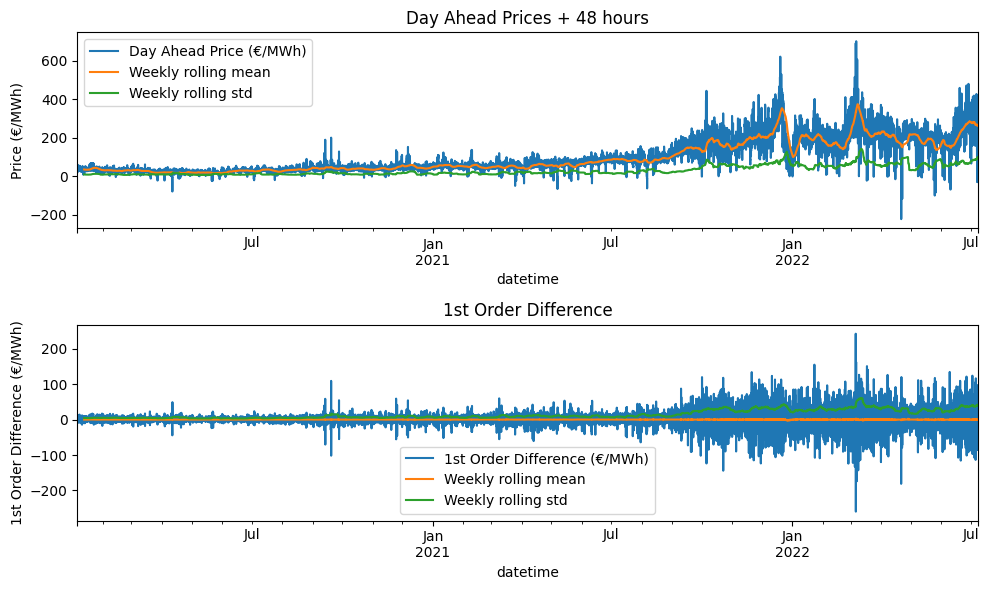

In [5]:
# Plot the hourly day ahead electricity price, along with the weekly rolling mean

fig, axs = plt.subplots(2, 1, figsize=(10, 6))

df_train.set_index('datetime')[target_name].plot(ax=axs[0],
                                                                title='Day Ahead Prices + 48 hours',
                                                                label='Day Ahead Price (€/MWh)',
                                                                ylabel='Price (€/MWh)')
df_train.set_index('datetime')[target_name].rolling(24*7).mean().plot(ax=axs[0], label='Weekly rolling mean')
df_train.set_index('datetime')[target_name].rolling(24*7).std().plot(ax=axs[0],label='Weekly rolling std')
axs[0].legend()

df_train.set_index('datetime')[target_name].diff().plot(ax=axs[1],
                                                               title='1st Order Difference',
                                                               label='1st Order Difference (€/MWh)',
                                                        ylabel='1st Order Difference (€/MWh)')
df_train.set_index('datetime')[target_name].diff().rolling(24*7).mean().plot(ax=axs[1], label='Weekly rolling mean')
df_train.set_index('datetime')[target_name].diff().rolling(24*7).std().plot(ax=axs[1],label='Weekly rolling std')
axs[1].legend()

plt.tight_layout()
plt.show()

In [7]:
df_train[target_name + "_first_diff"] = df_train[target_name].diff()

features = [target_name, target_name + "_first_diff"]

df_adfuller = [] 

for feature in features:

    temp_d = {}
    result = adfuller(df_train[feature].dropna().values)
    temp_d['Series Name'] = feature
    temp_d['ADF Statistic'] = result[0]
    temp_d['p-value'] = result[1]
    if temp_d['p-value'] <= 0.05:
        temp_d['Comment'] = "Reject H0, Data is stationary"
    elif temp_d['p-value'] > 0.05:
        temp_d['Comment'] = "Fail to reject H0, Data is non-stationary"
    
    df_adfuller.append(temp_d)

df_adfuller = pd.DataFrame(df_adfuller)
df_adfuller

Series Name  ADF Statistic   p-value  \
0             day_ahead_prices_lead_48      -3.536442  0.007099   
1  day_ahead_prices_lead_48_first_diff     -27.769725  0.000000   

                         Comment  
0  Reject H0, Data is stationary  
1  Reject H0, Data is stationary

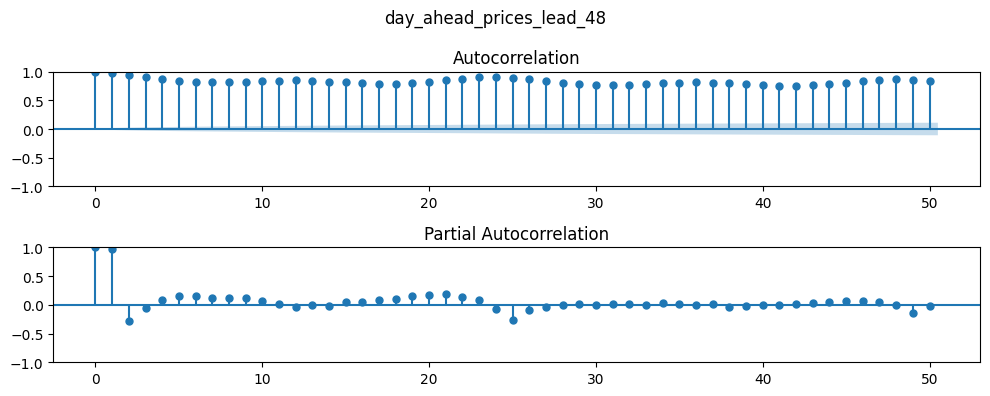

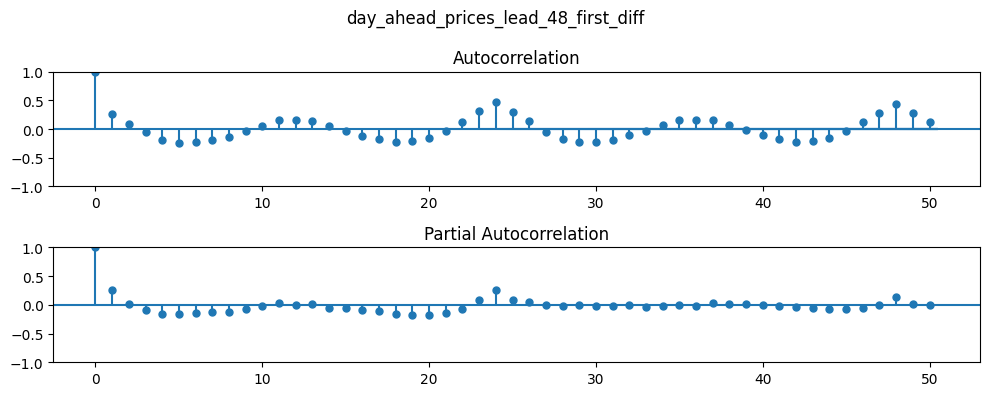

In [8]:
# Plot autocorrelation and partial autocorrelation plots

for feature in [target_name, target_name + "_first_diff"]:
    fig, axs = plt.subplots(2, 1, figsize=(10, 4))
    plot_acf(df_train[feature].dropna(), lags=50, ax=axs[0])
    plot_pacf(df_train[feature].dropna(), lags=50, ax=axs[1])
    fig.suptitle(feature)
    plt.tight_layout()
    plt.show()
    
df_train = df_train.drop(target_name + "_first_diff", axis=1)

Although we reject the null hypothesis of the Augmentented Dicky Fuller test, the plot of the time series does not look fully stationary so I will take the first difference.

The significant spike at lag 1 in the PACF plot above suggests a AR(1) and the significant spike at 24 suggests a seasonal AR(1) component.

The significant spike at lag 1 in the ACF plot above suggests a MA(1) and the significant spike at 24 suggests a seasonal MA(1) component.

This suggests a SARIMAX(1, 1, 1)x(1, 0, 1, 24) model. I will also fit the auto_arima to this time series to confirm these parameter selections

In [9]:
# Fit auto_arima function
data = df_train.set_index('datetime')[target_name].iloc[-200:]
stepwise_fit = auto_arima(data, max_p = 3, max_q = 3, m = 24, stepwise = True)     

In [10]:
# To print the summary 
stepwise_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                    y   No. Observations:                  200
Model:             SARIMAX(1, 0, 2)x(1, 0, [1], 24)   Log Likelihood                -959.276
Date:                              Sun, 23 Jun 2024   AIC                           1932.552
Time:                                      11:54:23   BIC                           1955.640
Sample:                                  06-29-2022   HQIC                          1941.895
                                       - 07-07-2022                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      1.4521      1.279      1.135      0.256      -1.055       3.959
ar.L1          0.8737      0.041     21.139      0.000       0.793       0.955
ma.L1          0.0940      0.070      1.335      0.182      -0.044       0.232
ma.L2          0.1736      0.074      2.347      0.019       0.029       0.319
ar.S.L24       0.9526      0.037     25.858      0.000       0.880       1.025
ma.S.L24      -0.6824      0.124     -5.508      0.000      -0.925      -0.440
sigma2       766.3195     70.326     10.897      0.000     628.483     904.156
===================================================================================
Ljung-Box (L1) (Q):                   0.08   Jarque-Bera (JB):                11.64
Prob(Q):                              0.78   Prob(JB):                         0.00
Heteroskedasticity (H):               1.59   Skew:                             0.11
Prob(H) (two-sided):                  0.06   Kurtosis:                         4.16
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Due to the time requried to fit the auto_arima funtion, I just fit it to the last 200 observations in the training set. The best model fit using auto_arima was SARIMAX(1, 0, 2)x(1, 0, 1, 24). I will fit all three models and compare their performance on the validation set.

####################
####################
Fitting SARIMAX(1, 1, 1)x(1, 0, 1, 24)

                                     SARIMAX Results                                      
Dep. Variable:           day_ahead_prices_lead_48   No. Observations:                21936
Model:             SARIMAX(1, 1, 1)x(1, 0, 1, 24)   Log Likelihood              -89862.787
Date:                            Sun, 23 Jun 2024   AIC                         179735.573
Time:                                    12:02:21   BIC                         179775.552
Sample:                                01-06-2020   HQIC                        179748.595
                                     - 07-07-2022                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8836      0.002

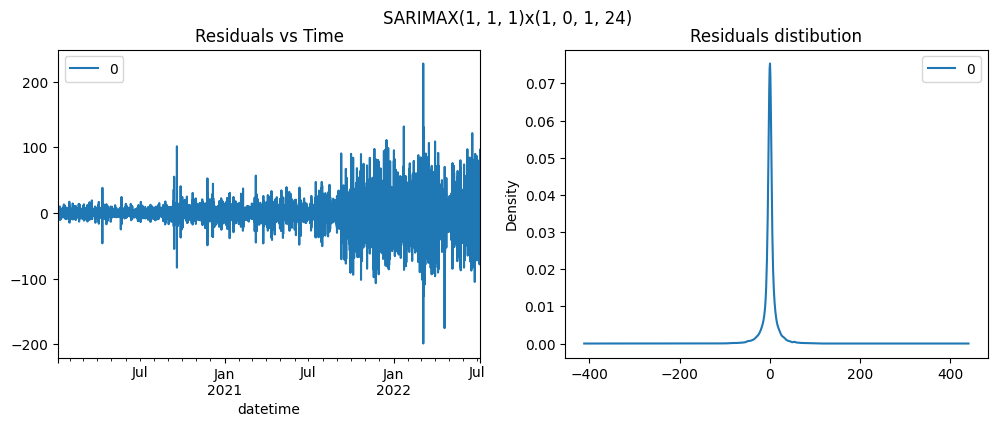

####################
####################
####################
####################
Fitting SARIMAX(1, 0, 2)x(1, 0, 1, 24)

                                      SARIMAX Results                                       
Dep. Variable:             day_ahead_prices_lead_48   No. Observations:                21936
Model:             SARIMAX(1, 0, 2)x(1, 0, [1], 24)   Log Likelihood              -89914.015
Date:                              Sun, 23 Jun 2024   AIC                         179840.030
Time:                                      12:02:55   BIC                         179888.006
Sample:                                  01-06-2020   HQIC                        179855.657
                                       - 07-07-2022                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------

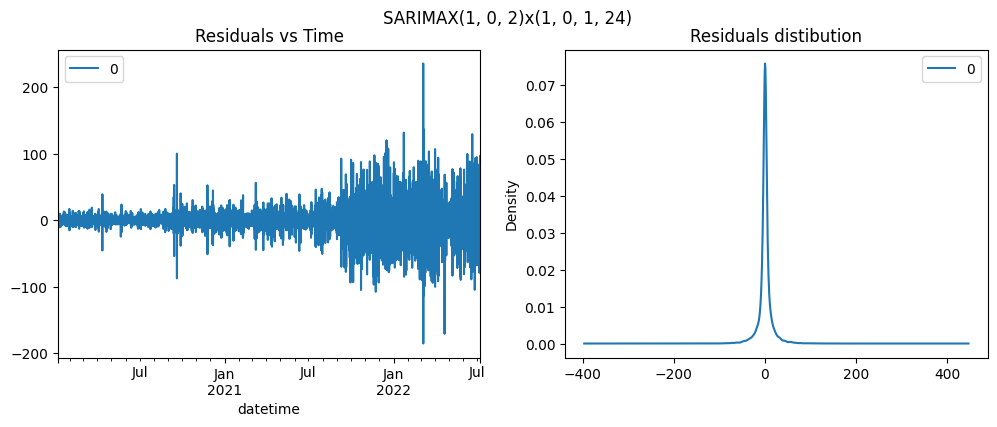

####################
####################


C:\Users\seamu\.pyenv\pyenv-win\versions\3.9.0\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


####################
####################
Fitting SARIMAX(1, 1, 2)x(1, 0, 1, 24)

                                      SARIMAX Results                                       
Dep. Variable:             day_ahead_prices_lead_48   No. Observations:                21936
Model:             SARIMAX(1, 1, 2)x(1, 0, [1], 24)   Log Likelihood              -89838.831
Date:                              Sun, 23 Jun 2024   AIC                         179689.662
Time:                                      12:03:35   BIC                         179737.637
Sample:                                  01-06-2020   HQIC                        179705.288
                                       - 07-07-2022                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0

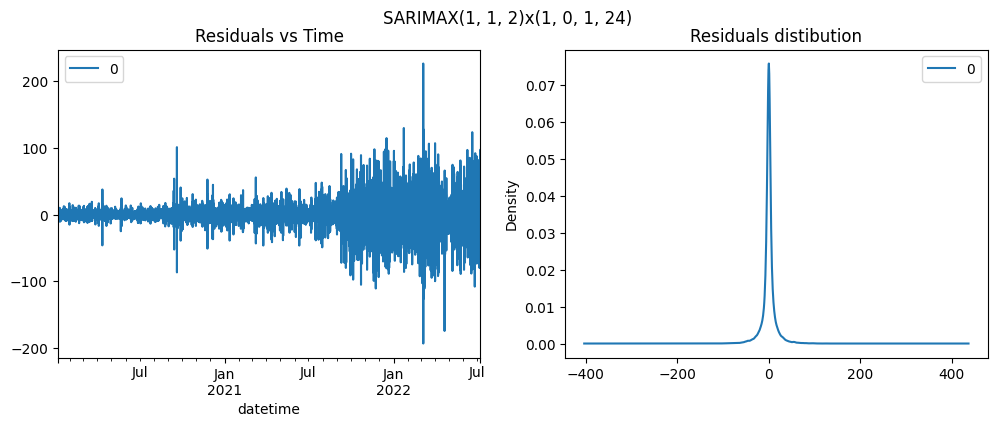

####################
####################


In [15]:
data = df_train.set_index('datetime')[target_name]
data.index.freq = 'h'

# SARIMAX(1, 1, 1)x(1, 0, 1, 24)
model_SARIMAX1 = SARIMAX(data, order=(1,1,1), seasonal_order=(1, 0, 1, 24)).fit()
statsmodel_fit_summary(model_SARIMAX1, "SARIMAX(1, 1, 1)x(1, 0, 1, 24)")

# SARIMAX(1, 0, 2)x(1, 0, 1, 24)
model_SARIMAX1 = SARIMAX(data, order=(1,0,2), seasonal_order=(1, 0, 1, 24)).fit()
statsmodel_fit_summary(model_SARIMAX1, "SARIMAX(1, 0, 2)x(1, 0, 1, 24)")

# SARIMAX(1, 1, 2)x(1, 0, 1, 24)
model_SARIMAX1 = SARIMAX(data, order=(1,1,2), seasonal_order=(1, 0, 1, 24)).fit()
statsmodel_fit_summary(model_SARIMAX1, "SARIMAX(1, 1, 2)x(1, 0, 1, 24)")

AIC is minimised by SARIMAX(1, 1, 2)x(1, 0, 1, 24)

I will choose between these three models and the number of training days to use by using the first 28 days of the validation set

In [48]:
validation_days = len(df_val) // 24
startdate_val = df_val["datetime"].dt.date.min()
y_val = df_val[target_name].values[:24 * validation_days]
horizon_days_val = 1

test_days = validation_days
startdate_test = startdate_val
y_test = np.array([])
horizon_days_test = horizon_days_val
covariate_names = []

dict_models = {
    'SARIMAX': {
        'training_days':[100, 200],
        'scale_data':False,
        'model_implementation':'statsmodels',
        'model_params':{
            'order':[(1, 1, 1), (1, 0, 2), (1, 1, 2)],
            'seasonal_order':[(1, 0, 1, 24)]
        }
    }
}

mlflow.set_experiment("/electricity-prices-sarimax-hyperparameteropt")

rws = RollingWindowSarimax()
df_arima_hypopt, _ = rws.train_models(df, target_name, y_val, dict_models, train_days, n_val_days, val_startdate, 
                                      temp_dict_pred_val, calc_rmae=False)

df_arima_hypopt = pd.DataFrame(df_arima_hypopt)

.\predictions\predictions_val_arima1_train_100d_2022-09-15.npy exists, loading
.\predictions\predictions_val_arima1_train_100d_2022-09-16.npy exists, loading
.\predictions\predictions_val_arima1_train_100d_2022-09-17.npy exists, loading
.\predictions\predictions_val_arima1_train_100d_2022-09-18.npy exists, loading
.\predictions\predictions_val_arima1_train_100d_2022-09-19.npy exists, loading
.\predictions\predictions_val_arima1_train_100d_2022-09-20.npy exists, loading
.\predictions\predictions_val_arima1_train_100d_2022-09-21.npy exists, loading
.\predictions\predictions_val_arima1_train_100d_2022-09-22.npy exists, loading
.\predictions\predictions_val_arima1_train_100d_2022-09-23.npy exists, loading
.\predictions\predictions_val_arima1_train_100d_2022-09-24.npy exists, loading
.\predictions\predictions_val_arima1_train_100d_2022-09-25.npy exists, loading
.\predictions\predictions_val_arima1_train_100d_2022-09-26.npy exists, loading
.\predictions\predictions_val_arima1_train_100d_2022

.\predictions\predictions_val_arima3_train_300d_2022-09-15.npy exists, loading
.\predictions\predictions_val_arima3_train_300d_2022-09-16.npy exists, loading
.\predictions\predictions_val_arima3_train_300d_2022-09-17.npy exists, loading
.\predictions\predictions_val_arima3_train_300d_2022-09-18.npy exists, loading
.\predictions\predictions_val_arima3_train_300d_2022-09-19.npy exists, loading
.\predictions\predictions_val_arima3_train_300d_2022-09-20.npy exists, loading
.\predictions\predictions_val_arima3_train_300d_2022-09-21.npy exists, loading
.\predictions\predictions_val_arima3_train_300d_2022-09-22.npy exists, loading
.\predictions\predictions_val_arima3_train_300d_2022-09-23.npy exists, loading
.\predictions\predictions_val_arima3_train_300d_2022-09-24.npy exists, loading
.\predictions\predictions_val_arima3_train_300d_2022-09-25.npy exists, loading
.\predictions\predictions_val_arima3_train_300d_2022-09-26.npy exists, loading
.\predictions\predictions_val_arima3_train_300d_2022

In [49]:
df_arima_hypopt.sort_values(['mae', 'rmse']).round(2)

dataset              model  rmse    r2          mape  smape    mae  rmae
4     val  arima2_train_200d  6.97  0.75  4.069189e+15  22.50  48.58   NaN
3     val  arima2_train_100d  6.99  0.75  4.018474e+15  22.73  48.84   NaN
5     val  arima2_train_300d  7.41  0.65  6.424344e+15  24.12  54.96   NaN
6     val  arima3_train_100d  7.62  0.58  6.241994e+15  25.93  58.14   NaN
7     val  arima3_train_200d  7.76  0.54  6.450581e+15  26.56  60.22   NaN
8     val  arima3_train_300d  7.80  0.54  6.543931e+15  26.77  60.81   NaN
1     val  arima1_train_200d  8.24  0.51  6.197059e+15  29.44  67.93   NaN
0     val  arima1_train_100d  8.26  0.51  6.182519e+15  29.61  68.25   NaN
2     val  arima1_train_300d  8.34  0.49  6.386197e+15  30.20  69.62   NaN

SARIMAX(2, 1, 1)x(1, 0, 1, 24) trained for 200 training days produced the best validation performance

In [30]:
n_val_days = (len(df_val) // 24) - 6
val_startdate = df_val["datetime"].dt.date.min()
y_val = df_val[target_name].values[:24 * n_val_days]
train_days = [200]

dict_models = {
#     'arima4':{
#         'order':(2,2,1),
#         'seasonal_order':(1, 0, 1, 24)
#     },
    'arima2':{
        'order':(2,1,1),
        'seasonal_order':(1, 0, 1, 24)
    }
}

mlflow.set_experiment("/electricity-prices")

rws = RollingWindowSarimax()
res_arima, dict_pred_val = rws.train_models(df, target_name, y_val, dict_models, train_days, n_val_days, val_startdate,
                                            dict_pred_val, calc_rmae=False)

.\predictions\predictions_val_arima2_train_200d_2022-09-15.npy exists, loading
.\predictions\predictions_val_arima2_train_200d_2022-09-16.npy exists, loading
.\predictions\predictions_val_arima2_train_200d_2022-09-17.npy exists, loading
.\predictions\predictions_val_arima2_train_200d_2022-09-18.npy exists, loading
.\predictions\predictions_val_arima2_train_200d_2022-09-19.npy exists, loading
.\predictions\predictions_val_arima2_train_200d_2022-09-20.npy exists, loading
.\predictions\predictions_val_arima2_train_200d_2022-09-21.npy exists, loading
.\predictions\predictions_val_arima2_train_200d_2022-09-22.npy exists, loading
.\predictions\predictions_val_arima2_train_200d_2022-09-23.npy exists, loading
.\predictions\predictions_val_arima2_train_200d_2022-09-24.npy exists, loading
.\predictions\predictions_val_arima2_train_200d_2022-09-25.npy exists, loading
.\predictions\predictions_val_arima2_train_200d_2022-09-26.npy exists, loading
.\predictions\predictions_val_arima2_train_200d_2022

## Linear Models

In [12]:
covariate_names = [col for col in df_train.columns]

for names in ['datetime', target_name]:
    covariate_names.remove(names)
    
binary_covariate_names = [
    'target_weekend',
    'target_is_holiday',
    'target_holiday_Eerste Kerstdag',
    'target_holiday_Eerste Pinksterdag',
    'target_holiday_Eerste paasdag',
    'target_holiday_Hemelvaartsdag',
    'target_holiday_Nieuwjaarsdag',
    'target_holiday_Tweede Kerstdag',
    'target_holiday_Tweede paasdag',
    'target_holiday_Tweede Pinksterdag',
]

categorical_covariate_names = [
    'target_hour_of_day',
    'target_day_of_week',
    'target_month'
]

save_predictions_flag = {
    'train':True,
    'val':True,
    'test':False
}

validation_days = len(df_val) // 24
startdate_val = df_val["datetime"].dt.date.min()
y_val = df_val[target_name].values
horizon_days_val = 1

# test_days = len(df_test) // 24
# startdate_test = df_test["datetime"].dt.date.min()
# y_test = df_test[target_name].values
# horizon_days_test = 1

test_days = validation_days
startdate_test = startdate_val
y_test = np.array([])
horizon_days_test = horizon_days_val

rwsklm = RollingWindowSklearn(df, y_val, startdate_val, validation_days, horizon_days_val, y_test, startdate_test,
                              test_days, horizon_days_test, gap_days, target_name, covariate_names,
                              binary_covariate_names, categorical_covariate_names)

I will tune the hyperparamters for these models using the validation set

### Lasso

In [14]:
dict_models = {
    'lasso': {
        'training_days':[100],
        'scale_data':True,
        'generate_dummy_features':True,
        'model_implementation':'sklearn',
        'model_instance': Lasso(random_state=0),
        'model_params':{
            'alpha':[0.01]
        },
        'fit_params':{}
    }
}


mlflow.set_experiment("/electricity-prices-lasso-hyperparameteropt")
_, _ = rwsklm.train_models(dict_models, save_predictions_flag)

Saving model cache to .\models\model_cache_lassoalpha_0.01_train_200d_train_period_2021-12-20_2022-07-07.joblib
Loading model cache from .\models\model_cache_lassoalpha_0.01_train_200d_train_period_2021-12-20_2022-07-07.joblib
Saving .\predictions\predictions_train_lassoalpha_0.01_train_200d_train_period_2021-12-20_2022-07-07.npy
Loading model cache from .\models\model_cache_lassoalpha_0.01_train_200d_train_period_2021-12-20_2022-07-07.joblib
Saving .\predictions\predictions_val_lassoalpha_0.01_train_200d_val_period_2022-07-08_2022-07-08.npy
Saving model cache to .\models\model_cache_lassoalpha_0.01_train_200d_train_period_2021-12-21_2022-07-08.joblib
Loading model cache from .\models\model_cache_lassoalpha_0.01_train_200d_train_period_2021-12-21_2022-07-08.joblib
Saving .\predictions\predictions_train_lassoalpha_0.01_train_200d_train_period_2021-12-21_2022-07-08.npy
Loading model cache from .\models\model_cache_lassoalpha_0.01_train_200d_train_period_2021-12-21_2022-07-08.joblib
Savin

Saving model cache to .\models\model_cache_lassoalpha_0.01_train_200d_train_period_2022-01-04_2022-07-22.joblib
Loading model cache from .\models\model_cache_lassoalpha_0.01_train_200d_train_period_2022-01-04_2022-07-22.joblib
Saving .\predictions\predictions_train_lassoalpha_0.01_train_200d_train_period_2022-01-04_2022-07-22.npy
Loading model cache from .\models\model_cache_lassoalpha_0.01_train_200d_train_period_2022-01-04_2022-07-22.joblib
Saving .\predictions\predictions_val_lassoalpha_0.01_train_200d_val_period_2022-07-23_2022-07-23.npy
Saving model cache to .\models\model_cache_lassoalpha_0.01_train_200d_train_period_2022-01-05_2022-07-23.joblib
Loading model cache from .\models\model_cache_lassoalpha_0.01_train_200d_train_period_2022-01-05_2022-07-23.joblib
Saving .\predictions\predictions_train_lassoalpha_0.01_train_200d_train_period_2022-01-05_2022-07-23.npy
Loading model cache from .\models\model_cache_lassoalpha_0.01_train_200d_train_period_2022-01-05_2022-07-23.joblib
Savin

Saving model cache to .\models\model_cache_lassoalpha_0.01_train_200d_train_period_2022-01-19_2022-08-06.joblib
Loading model cache from .\models\model_cache_lassoalpha_0.01_train_200d_train_period_2022-01-19_2022-08-06.joblib
Saving .\predictions\predictions_train_lassoalpha_0.01_train_200d_train_period_2022-01-19_2022-08-06.npy
Loading model cache from .\models\model_cache_lassoalpha_0.01_train_200d_train_period_2022-01-19_2022-08-06.joblib
Saving .\predictions\predictions_val_lassoalpha_0.01_train_200d_val_period_2022-08-07_2022-08-07.npy
Saving model cache to .\models\model_cache_lassoalpha_0.01_train_200d_train_period_2022-01-20_2022-08-07.joblib
Loading model cache from .\models\model_cache_lassoalpha_0.01_train_200d_train_period_2022-01-20_2022-08-07.joblib
Saving .\predictions\predictions_train_lassoalpha_0.01_train_200d_train_period_2022-01-20_2022-08-07.npy
Loading model cache from .\models\model_cache_lassoalpha_0.01_train_200d_train_period_2022-01-20_2022-08-07.joblib
Savin

Saving model cache to .\models\model_cache_lassoalpha_0.01_train_200d_train_period_2022-02-05_2022-08-23.joblib
Loading model cache from .\models\model_cache_lassoalpha_0.01_train_200d_train_period_2022-02-05_2022-08-23.joblib
Saving .\predictions\predictions_train_lassoalpha_0.01_train_200d_train_period_2022-02-05_2022-08-23.npy
Loading model cache from .\models\model_cache_lassoalpha_0.01_train_200d_train_period_2022-02-05_2022-08-23.joblib
Saving .\predictions\predictions_val_lassoalpha_0.01_train_200d_val_period_2022-08-24_2022-08-24.npy
Saving model cache to .\models\model_cache_lassoalpha_0.01_train_200d_train_period_2022-02-06_2022-08-24.joblib
Loading model cache from .\models\model_cache_lassoalpha_0.01_train_200d_train_period_2022-02-06_2022-08-24.joblib
Saving .\predictions\predictions_train_lassoalpha_0.01_train_200d_train_period_2022-02-06_2022-08-24.npy
Loading model cache from .\models\model_cache_lassoalpha_0.01_train_200d_train_period_2022-02-06_2022-08-24.joblib
Savin

Saving model cache to .\models\model_cache_lassoalpha_0.01_train_200d_train_period_2022-02-21_2022-09-08.joblib
Loading model cache from .\models\model_cache_lassoalpha_0.01_train_200d_train_period_2022-02-21_2022-09-08.joblib
Saving .\predictions\predictions_train_lassoalpha_0.01_train_200d_train_period_2022-02-21_2022-09-08.npy
Loading model cache from .\models\model_cache_lassoalpha_0.01_train_200d_train_period_2022-02-21_2022-09-08.joblib
Saving .\predictions\predictions_val_lassoalpha_0.01_train_200d_val_period_2022-09-09_2022-09-09.npy
Saving model cache to .\models\model_cache_lassoalpha_0.01_train_200d_train_period_2022-02-22_2022-09-09.joblib
Loading model cache from .\models\model_cache_lassoalpha_0.01_train_200d_train_period_2022-02-22_2022-09-09.joblib
Saving .\predictions\predictions_train_lassoalpha_0.01_train_200d_train_period_2022-02-22_2022-09-09.npy
Loading model cache from .\models\model_cache_lassoalpha_0.01_train_200d_train_period_2022-02-22_2022-09-09.joblib
Savin

Saving model cache to .\models\model_cache_lassoalpha_0.01_train_200d_train_period_2022-03-08_2022-09-23.joblib
Loading model cache from .\models\model_cache_lassoalpha_0.01_train_200d_train_period_2022-03-08_2022-09-23.joblib
Saving .\predictions\predictions_train_lassoalpha_0.01_train_200d_train_period_2022-03-08_2022-09-23.npy
Loading model cache from .\models\model_cache_lassoalpha_0.01_train_200d_train_period_2022-03-08_2022-09-23.joblib
Saving .\predictions\predictions_val_lassoalpha_0.01_train_200d_val_period_2022-09-24_2022-09-24.npy
Saving model cache to .\models\model_cache_lassoalpha_0.01_train_200d_train_period_2022-03-09_2022-09-24.joblib
Loading model cache from .\models\model_cache_lassoalpha_0.01_train_200d_train_period_2022-03-09_2022-09-24.joblib
Saving .\predictions\predictions_train_lassoalpha_0.01_train_200d_train_period_2022-03-09_2022-09-24.npy
Loading model cache from .\models\model_cache_lassoalpha_0.01_train_200d_train_period_2022-03-09_2022-09-24.joblib
Savin

Saving model cache to .\models\model_cache_lassoalpha_0.01_train_200d_train_period_2022-03-25_2022-10-10.joblib
Loading model cache from .\models\model_cache_lassoalpha_0.01_train_200d_train_period_2022-03-25_2022-10-10.joblib
Saving .\predictions\predictions_train_lassoalpha_0.01_train_200d_train_period_2022-03-25_2022-10-10.npy
Loading model cache from .\models\model_cache_lassoalpha_0.01_train_200d_train_period_2022-03-25_2022-10-10.joblib
Saving .\predictions\predictions_val_lassoalpha_0.01_train_200d_val_period_2022-10-11_2022-10-11.npy
Saving model cache to .\models\model_cache_lassoalpha_0.01_train_200d_train_period_2022-03-26_2022-10-11.joblib
Loading model cache from .\models\model_cache_lassoalpha_0.01_train_200d_train_period_2022-03-26_2022-10-11.joblib
Saving .\predictions\predictions_train_lassoalpha_0.01_train_200d_train_period_2022-03-26_2022-10-11.npy
Loading model cache from .\models\model_cache_lassoalpha_0.01_train_200d_train_period_2022-03-26_2022-10-11.joblib
Savin

Saving model cache to .\models\model_cache_lassoalpha_0.01_train_200d_train_period_2022-04-09_2022-10-25.joblib
Loading model cache from .\models\model_cache_lassoalpha_0.01_train_200d_train_period_2022-04-09_2022-10-25.joblib
Saving .\predictions\predictions_train_lassoalpha_0.01_train_200d_train_period_2022-04-09_2022-10-25.npy
Loading model cache from .\models\model_cache_lassoalpha_0.01_train_200d_train_period_2022-04-09_2022-10-25.joblib
Saving .\predictions\predictions_val_lassoalpha_0.01_train_200d_val_period_2022-10-26_2022-10-26.npy
Saving model cache to .\models\model_cache_lassoalpha_0.01_train_200d_train_period_2022-04-10_2022-10-26.joblib
Loading model cache from .\models\model_cache_lassoalpha_0.01_train_200d_train_period_2022-04-10_2022-10-26.joblib
Saving .\predictions\predictions_train_lassoalpha_0.01_train_200d_train_period_2022-04-10_2022-10-26.npy
Loading model cache from .\models\model_cache_lassoalpha_0.01_train_200d_train_period_2022-04-10_2022-10-26.joblib
Savin

Saving model cache to .\models\model_cache_lassoalpha_0.01_train_200d_train_period_2022-04-26_2022-11-11.joblib
Loading model cache from .\models\model_cache_lassoalpha_0.01_train_200d_train_period_2022-04-26_2022-11-11.joblib
Saving .\predictions\predictions_train_lassoalpha_0.01_train_200d_train_period_2022-04-26_2022-11-11.npy
Loading model cache from .\models\model_cache_lassoalpha_0.01_train_200d_train_period_2022-04-26_2022-11-11.joblib
Saving .\predictions\predictions_val_lassoalpha_0.01_train_200d_val_period_2022-11-12_2022-11-12.npy
Saving model cache to .\models\model_cache_lassoalpha_0.01_train_200d_train_period_2022-04-27_2022-11-12.joblib
Loading model cache from .\models\model_cache_lassoalpha_0.01_train_200d_train_period_2022-04-27_2022-11-12.joblib
Saving .\predictions\predictions_train_lassoalpha_0.01_train_200d_train_period_2022-04-27_2022-11-12.npy
Loading model cache from .\models\model_cache_lassoalpha_0.01_train_200d_train_period_2022-04-27_2022-11-12.joblib
Savin

Saving model cache to .\models\model_cache_lassoalpha_0.01_train_200d_train_period_2022-05-11_2022-11-26.joblib
Loading model cache from .\models\model_cache_lassoalpha_0.01_train_200d_train_period_2022-05-11_2022-11-26.joblib
Saving .\predictions\predictions_train_lassoalpha_0.01_train_200d_train_period_2022-05-11_2022-11-26.npy
Loading model cache from .\models\model_cache_lassoalpha_0.01_train_200d_train_period_2022-05-11_2022-11-26.joblib
Saving .\predictions\predictions_val_lassoalpha_0.01_train_200d_val_period_2022-11-27_2022-11-27.npy
Saving model cache to .\models\model_cache_lassoalpha_0.01_train_200d_train_period_2022-05-12_2022-11-27.joblib
Loading model cache from .\models\model_cache_lassoalpha_0.01_train_200d_train_period_2022-05-12_2022-11-27.joblib
Saving .\predictions\predictions_train_lassoalpha_0.01_train_200d_train_period_2022-05-12_2022-11-27.npy
Loading model cache from .\models\model_cache_lassoalpha_0.01_train_200d_train_period_2022-05-12_2022-11-27.joblib
Savin

Saving model cache to .\models\model_cache_lassoalpha_0.01_train_200d_train_period_2022-05-26_2022-12-11.joblib
Loading model cache from .\models\model_cache_lassoalpha_0.01_train_200d_train_period_2022-05-26_2022-12-11.joblib
Saving .\predictions\predictions_train_lassoalpha_0.01_train_200d_train_period_2022-05-26_2022-12-11.npy
Loading model cache from .\models\model_cache_lassoalpha_0.01_train_200d_train_period_2022-05-26_2022-12-11.joblib
Saving .\predictions\predictions_val_lassoalpha_0.01_train_200d_val_period_2022-12-12_2022-12-12.npy
Saving model cache to .\models\model_cache_lassoalpha_0.01_train_200d_train_period_2022-05-27_2022-12-12.joblib
Loading model cache from .\models\model_cache_lassoalpha_0.01_train_200d_train_period_2022-05-27_2022-12-12.joblib
Saving .\predictions\predictions_train_lassoalpha_0.01_train_200d_train_period_2022-05-27_2022-12-12.npy
Loading model cache from .\models\model_cache_lassoalpha_0.01_train_200d_train_period_2022-05-27_2022-12-12.joblib
Savin

Saving model cache to .\models\model_cache_lassoalpha_0.01_train_200d_train_period_2022-06-10_2022-12-26.joblib
Loading model cache from .\models\model_cache_lassoalpha_0.01_train_200d_train_period_2022-06-10_2022-12-26.joblib
Saving .\predictions\predictions_train_lassoalpha_0.01_train_200d_train_period_2022-06-10_2022-12-26.npy
Loading model cache from .\models\model_cache_lassoalpha_0.01_train_200d_train_period_2022-06-10_2022-12-26.joblib
Saving .\predictions\predictions_val_lassoalpha_0.01_train_200d_val_period_2022-12-27_2022-12-27.npy
Saving model cache to .\models\model_cache_lassoalpha_0.01_train_200d_train_period_2022-06-11_2022-12-27.joblib
Loading model cache from .\models\model_cache_lassoalpha_0.01_train_200d_train_period_2022-06-11_2022-12-27.joblib
Saving .\predictions\predictions_train_lassoalpha_0.01_train_200d_train_period_2022-06-11_2022-12-27.npy
Loading model cache from .\models\model_cache_lassoalpha_0.01_train_200d_train_period_2022-06-11_2022-12-27.joblib
Savin

Saving model cache to .\models\model_cache_lassoalpha_0.01_train_200d_train_period_2022-06-25_2023-01-10.joblib
Loading model cache from .\models\model_cache_lassoalpha_0.01_train_200d_train_period_2022-06-25_2023-01-10.joblib
Saving .\predictions\predictions_train_lassoalpha_0.01_train_200d_train_period_2022-06-25_2023-01-10.npy
Loading model cache from .\models\model_cache_lassoalpha_0.01_train_200d_train_period_2022-06-25_2023-01-10.joblib
Saving .\predictions\predictions_val_lassoalpha_0.01_train_200d_val_period_2023-01-11_2023-01-11.npy
Saving model cache to .\models\model_cache_lassoalpha_0.01_train_200d_train_period_2022-06-26_2023-01-11.joblib
Loading model cache from .\models\model_cache_lassoalpha_0.01_train_200d_train_period_2022-06-26_2023-01-11.joblib
Saving .\predictions\predictions_train_lassoalpha_0.01_train_200d_train_period_2022-06-26_2023-01-11.npy
Loading model cache from .\models\model_cache_lassoalpha_0.01_train_200d_train_period_2022-06-26_2023-01-11.joblib
Savin

Saving model cache to .\models\model_cache_lassoalpha_0.01_train_200d_train_period_2022-07-11_2023-01-26.joblib
Loading model cache from .\models\model_cache_lassoalpha_0.01_train_200d_train_period_2022-07-11_2023-01-26.joblib
Saving .\predictions\predictions_train_lassoalpha_0.01_train_200d_train_period_2022-07-11_2023-01-26.npy
Loading model cache from .\models\model_cache_lassoalpha_0.01_train_200d_train_period_2022-07-11_2023-01-26.joblib
Saving .\predictions\predictions_val_lassoalpha_0.01_train_200d_val_period_2023-01-27_2023-01-27.npy
Saving model cache to .\models\model_cache_lassoalpha_0.01_train_200d_train_period_2022-07-12_2023-01-27.joblib
Loading model cache from .\models\model_cache_lassoalpha_0.01_train_200d_train_period_2022-07-12_2023-01-27.joblib
Saving .\predictions\predictions_train_lassoalpha_0.01_train_200d_train_period_2022-07-12_2023-01-27.npy
Loading model cache from .\models\model_cache_lassoalpha_0.01_train_200d_train_period_2022-07-12_2023-01-27.joblib
Savin

Saving model cache to .\models\model_cache_lassoalpha_0.01_train_200d_train_period_2022-07-27_2023-02-11.joblib
Loading model cache from .\models\model_cache_lassoalpha_0.01_train_200d_train_period_2022-07-27_2023-02-11.joblib
Saving .\predictions\predictions_train_lassoalpha_0.01_train_200d_train_period_2022-07-27_2023-02-11.npy
Loading model cache from .\models\model_cache_lassoalpha_0.01_train_200d_train_period_2022-07-27_2023-02-11.joblib
Saving .\predictions\predictions_val_lassoalpha_0.01_train_200d_val_period_2023-02-12_2023-02-12.npy
Saving model cache to .\models\model_cache_lassoalpha_0.01_train_200d_train_period_2022-07-28_2023-02-12.joblib
Loading model cache from .\models\model_cache_lassoalpha_0.01_train_200d_train_period_2022-07-28_2023-02-12.joblib
Saving .\predictions\predictions_train_lassoalpha_0.01_train_200d_train_period_2022-07-28_2023-02-12.npy
Loading model cache from .\models\model_cache_lassoalpha_0.01_train_200d_train_period_2022-07-28_2023-02-12.joblib
Savin

Saving model cache to .\models\model_cache_lassoalpha_0.01_train_200d_train_period_2022-08-11_2023-02-26.joblib
Loading model cache from .\models\model_cache_lassoalpha_0.01_train_200d_train_period_2022-08-11_2023-02-26.joblib
Saving .\predictions\predictions_train_lassoalpha_0.01_train_200d_train_period_2022-08-11_2023-02-26.npy
Loading model cache from .\models\model_cache_lassoalpha_0.01_train_200d_train_period_2022-08-11_2023-02-26.joblib
Saving .\predictions\predictions_val_lassoalpha_0.01_train_200d_val_period_2023-02-27_2023-02-27.npy
Saving model cache to .\models\model_cache_lassoalpha_0.01_train_200d_train_period_2022-08-12_2023-02-27.joblib
Loading model cache from .\models\model_cache_lassoalpha_0.01_train_200d_train_period_2022-08-12_2023-02-27.joblib
Saving .\predictions\predictions_train_lassoalpha_0.01_train_200d_train_period_2022-08-12_2023-02-27.npy
Loading model cache from .\models\model_cache_lassoalpha_0.01_train_200d_train_period_2022-08-12_2023-02-27.joblib
Savin

Saving model cache to .\models\model_cache_lassoalpha_0.01_train_200d_train_period_2022-08-26_2023-03-13.joblib
Loading model cache from .\models\model_cache_lassoalpha_0.01_train_200d_train_period_2022-08-26_2023-03-13.joblib
Saving .\predictions\predictions_train_lassoalpha_0.01_train_200d_train_period_2022-08-26_2023-03-13.npy
Loading model cache from .\models\model_cache_lassoalpha_0.01_train_200d_train_period_2022-08-26_2023-03-13.joblib
Saving .\predictions\predictions_val_lassoalpha_0.01_train_200d_val_period_2023-03-14_2023-03-14.npy
Saving model cache to .\models\model_cache_lassoalpha_0.01_train_200d_train_period_2022-08-27_2023-03-14.joblib
Loading model cache from .\models\model_cache_lassoalpha_0.01_train_200d_train_period_2022-08-27_2023-03-14.joblib
Saving .\predictions\predictions_train_lassoalpha_0.01_train_200d_train_period_2022-08-27_2023-03-14.npy
Loading model cache from .\models\model_cache_lassoalpha_0.01_train_200d_train_period_2022-08-27_2023-03-14.joblib
Savin

Loading model cache from .\models\model_cache_lassoalpha_0.01_train_200d_train_period_2022-09-10_2023-03-28.joblib
Saving .\predictions\predictions_train_lassoalpha_0.01_train_200d_train_period_2022-09-10_2023-03-28.npy
Loading model cache from .\models\model_cache_lassoalpha_0.01_train_200d_train_period_2022-09-10_2023-03-28.joblib
Saving .\predictions\predictions_val_lassoalpha_0.01_train_200d_val_period_2023-03-29_2023-03-29.npy
Saving model cache to .\models\model_cache_lassoalpha_0.01_train_200d_train_period_2022-09-11_2023-03-29.joblib
Loading model cache from .\models\model_cache_lassoalpha_0.01_train_200d_train_period_2022-09-11_2023-03-29.joblib
Saving .\predictions\predictions_train_lassoalpha_0.01_train_200d_train_period_2022-09-11_2023-03-29.npy
Loading model cache from .\models\model_cache_lassoalpha_0.01_train_200d_train_period_2022-09-11_2023-03-29.joblib
Saving .\predictions\predictions_val_lassoalpha_0.01_train_200d_val_period_2023-03-30_2023-03-30.npy
Saving model cac

Saving model cache to .\models\model_cache_lassoalpha_0.01_train_200d_train_period_2022-09-27_2023-04-14.joblib
Loading model cache from .\models\model_cache_lassoalpha_0.01_train_200d_train_period_2022-09-27_2023-04-14.joblib
Saving .\predictions\predictions_train_lassoalpha_0.01_train_200d_train_period_2022-09-27_2023-04-14.npy
Loading model cache from .\models\model_cache_lassoalpha_0.01_train_200d_train_period_2022-09-27_2023-04-14.joblib
Saving .\predictions\predictions_val_lassoalpha_0.01_train_200d_val_period_2023-04-15_2023-04-15.npy
Saving model cache to .\models\model_cache_lassoalpha_0.01_train_200d_train_period_2022-09-28_2023-04-15.joblib
Loading model cache from .\models\model_cache_lassoalpha_0.01_train_200d_train_period_2022-09-28_2023-04-15.joblib
Saving .\predictions\predictions_train_lassoalpha_0.01_train_200d_train_period_2022-09-28_2023-04-15.npy
Loading model cache from .\models\model_cache_lassoalpha_0.01_train_200d_train_period_2022-09-28_2023-04-15.joblib
Savin

Saving model cache to .\models\model_cache_lassoalpha_0.01_train_200d_train_period_2022-10-12_2023-04-29.joblib
Loading model cache from .\models\model_cache_lassoalpha_0.01_train_200d_train_period_2022-10-12_2023-04-29.joblib
Saving .\predictions\predictions_train_lassoalpha_0.01_train_200d_train_period_2022-10-12_2023-04-29.npy
Loading model cache from .\models\model_cache_lassoalpha_0.01_train_200d_train_period_2022-10-12_2023-04-29.joblib
Saving .\predictions\predictions_val_lassoalpha_0.01_train_200d_val_period_2023-04-30_2023-04-30.npy
Saving model cache to .\models\model_cache_lassoalpha_0.01_train_200d_train_period_2022-10-13_2023-04-30.joblib
Loading model cache from .\models\model_cache_lassoalpha_0.01_train_200d_train_period_2022-10-13_2023-04-30.joblib
Saving .\predictions\predictions_train_lassoalpha_0.01_train_200d_train_period_2022-10-13_2023-04-30.npy
Loading model cache from .\models\model_cache_lassoalpha_0.01_train_200d_train_period_2022-10-13_2023-04-30.joblib
Savin

The best validation performance with the least overfitting is achieved using 200 days of training data and alpha = 0.1

### Ridge

In [23]:
dict_models = {
    'ridge': {
        'training_days':[200],
        'scale_data':True,
        'generate_dummy_features':True,
        'model_implementation':'sklearn',
        'model_instance': Ridge(random_state=0),
        'model_params':{
            'alpha':[5000.0]
        },
        'fit_params':{}
    }
}

mlflow.set_experiment("/electricity-prices-ridge-hyperparameteropt")
_, _ = rwsklm.train_models(dict_models, save_predictions_flag)

Saving model cache to .\models\model_cache_ridgealpha_15000.0_train_200d_train_period_2021-12-20_2022-07-07.joblib
Loading model cache from .\models\model_cache_ridgealpha_15000.0_train_200d_train_period_2021-12-20_2022-07-07.joblib
Saving .\predictions\predictions_train_ridgealpha_15000.0_train_200d_train_period_2021-12-20_2022-07-07.npy
Loading model cache from .\models\model_cache_ridgealpha_15000.0_train_200d_train_period_2021-12-20_2022-07-07.joblib
Saving .\predictions\predictions_val_ridgealpha_15000.0_train_200d_val_period_2022-07-08_2022-07-08.npy
Saving model cache to .\models\model_cache_ridgealpha_15000.0_train_200d_train_period_2021-12-21_2022-07-08.joblib
Loading model cache from .\models\model_cache_ridgealpha_15000.0_train_200d_train_period_2021-12-21_2022-07-08.joblib
Saving .\predictions\predictions_train_ridgealpha_15000.0_train_200d_train_period_2021-12-21_2022-07-08.npy
Loading model cache from .\models\model_cache_ridgealpha_15000.0_train_200d_train_period_2021-12

Saving model cache to .\models\model_cache_ridgealpha_15000.0_train_200d_train_period_2022-01-06_2022-07-24.joblib
Loading model cache from .\models\model_cache_ridgealpha_15000.0_train_200d_train_period_2022-01-06_2022-07-24.joblib
Saving .\predictions\predictions_train_ridgealpha_15000.0_train_200d_train_period_2022-01-06_2022-07-24.npy
Loading model cache from .\models\model_cache_ridgealpha_15000.0_train_200d_train_period_2022-01-06_2022-07-24.joblib
Saving .\predictions\predictions_val_ridgealpha_15000.0_train_200d_val_period_2022-07-25_2022-07-25.npy
Saving model cache to .\models\model_cache_ridgealpha_15000.0_train_200d_train_period_2022-01-07_2022-07-25.joblib
Loading model cache from .\models\model_cache_ridgealpha_15000.0_train_200d_train_period_2022-01-07_2022-07-25.joblib
Saving .\predictions\predictions_train_ridgealpha_15000.0_train_200d_train_period_2022-01-07_2022-07-25.npy
Loading model cache from .\models\model_cache_ridgealpha_15000.0_train_200d_train_period_2022-01

Saving model cache to .\models\model_cache_ridgealpha_15000.0_train_200d_train_period_2022-01-21_2022-08-08.joblib
Loading model cache from .\models\model_cache_ridgealpha_15000.0_train_200d_train_period_2022-01-21_2022-08-08.joblib
Saving .\predictions\predictions_train_ridgealpha_15000.0_train_200d_train_period_2022-01-21_2022-08-08.npy
Loading model cache from .\models\model_cache_ridgealpha_15000.0_train_200d_train_period_2022-01-21_2022-08-08.joblib
Saving .\predictions\predictions_val_ridgealpha_15000.0_train_200d_val_period_2022-08-09_2022-08-09.npy
Saving model cache to .\models\model_cache_ridgealpha_15000.0_train_200d_train_period_2022-01-22_2022-08-09.joblib
Loading model cache from .\models\model_cache_ridgealpha_15000.0_train_200d_train_period_2022-01-22_2022-08-09.joblib
Saving .\predictions\predictions_train_ridgealpha_15000.0_train_200d_train_period_2022-01-22_2022-08-09.npy
Loading model cache from .\models\model_cache_ridgealpha_15000.0_train_200d_train_period_2022-01

Saving model cache to .\models\model_cache_ridgealpha_15000.0_train_200d_train_period_2022-02-05_2022-08-23.joblib
Loading model cache from .\models\model_cache_ridgealpha_15000.0_train_200d_train_period_2022-02-05_2022-08-23.joblib
Saving .\predictions\predictions_train_ridgealpha_15000.0_train_200d_train_period_2022-02-05_2022-08-23.npy
Loading model cache from .\models\model_cache_ridgealpha_15000.0_train_200d_train_period_2022-02-05_2022-08-23.joblib
Saving .\predictions\predictions_val_ridgealpha_15000.0_train_200d_val_period_2022-08-24_2022-08-24.npy
Saving model cache to .\models\model_cache_ridgealpha_15000.0_train_200d_train_period_2022-02-06_2022-08-24.joblib
Loading model cache from .\models\model_cache_ridgealpha_15000.0_train_200d_train_period_2022-02-06_2022-08-24.joblib
Saving .\predictions\predictions_train_ridgealpha_15000.0_train_200d_train_period_2022-02-06_2022-08-24.npy
Loading model cache from .\models\model_cache_ridgealpha_15000.0_train_200d_train_period_2022-02

Saving model cache to .\models\model_cache_ridgealpha_15000.0_train_200d_train_period_2022-02-20_2022-09-07.joblib
Loading model cache from .\models\model_cache_ridgealpha_15000.0_train_200d_train_period_2022-02-20_2022-09-07.joblib
Saving .\predictions\predictions_train_ridgealpha_15000.0_train_200d_train_period_2022-02-20_2022-09-07.npy
Loading model cache from .\models\model_cache_ridgealpha_15000.0_train_200d_train_period_2022-02-20_2022-09-07.joblib
Saving .\predictions\predictions_val_ridgealpha_15000.0_train_200d_val_period_2022-09-08_2022-09-08.npy
Saving model cache to .\models\model_cache_ridgealpha_15000.0_train_200d_train_period_2022-02-21_2022-09-08.joblib
Loading model cache from .\models\model_cache_ridgealpha_15000.0_train_200d_train_period_2022-02-21_2022-09-08.joblib
Saving .\predictions\predictions_train_ridgealpha_15000.0_train_200d_train_period_2022-02-21_2022-09-08.npy
Loading model cache from .\models\model_cache_ridgealpha_15000.0_train_200d_train_period_2022-02

Saving model cache to .\models\model_cache_ridgealpha_15000.0_train_200d_train_period_2022-03-08_2022-09-23.joblib
Loading model cache from .\models\model_cache_ridgealpha_15000.0_train_200d_train_period_2022-03-08_2022-09-23.joblib
Saving .\predictions\predictions_train_ridgealpha_15000.0_train_200d_train_period_2022-03-08_2022-09-23.npy
Loading model cache from .\models\model_cache_ridgealpha_15000.0_train_200d_train_period_2022-03-08_2022-09-23.joblib
Saving .\predictions\predictions_val_ridgealpha_15000.0_train_200d_val_period_2022-09-24_2022-09-24.npy
Saving model cache to .\models\model_cache_ridgealpha_15000.0_train_200d_train_period_2022-03-09_2022-09-24.joblib
Loading model cache from .\models\model_cache_ridgealpha_15000.0_train_200d_train_period_2022-03-09_2022-09-24.joblib
Saving .\predictions\predictions_train_ridgealpha_15000.0_train_200d_train_period_2022-03-09_2022-09-24.npy
Loading model cache from .\models\model_cache_ridgealpha_15000.0_train_200d_train_period_2022-03

Saving model cache to .\models\model_cache_ridgealpha_15000.0_train_200d_train_period_2022-03-25_2022-10-10.joblib
Loading model cache from .\models\model_cache_ridgealpha_15000.0_train_200d_train_period_2022-03-25_2022-10-10.joblib
Saving .\predictions\predictions_train_ridgealpha_15000.0_train_200d_train_period_2022-03-25_2022-10-10.npy
Loading model cache from .\models\model_cache_ridgealpha_15000.0_train_200d_train_period_2022-03-25_2022-10-10.joblib
Saving .\predictions\predictions_val_ridgealpha_15000.0_train_200d_val_period_2022-10-11_2022-10-11.npy
Saving model cache to .\models\model_cache_ridgealpha_15000.0_train_200d_train_period_2022-03-26_2022-10-11.joblib
Loading model cache from .\models\model_cache_ridgealpha_15000.0_train_200d_train_period_2022-03-26_2022-10-11.joblib
Saving .\predictions\predictions_train_ridgealpha_15000.0_train_200d_train_period_2022-03-26_2022-10-11.npy
Loading model cache from .\models\model_cache_ridgealpha_15000.0_train_200d_train_period_2022-03

Saving model cache to .\models\model_cache_ridgealpha_15000.0_train_200d_train_period_2022-04-09_2022-10-25.joblib
Loading model cache from .\models\model_cache_ridgealpha_15000.0_train_200d_train_period_2022-04-09_2022-10-25.joblib
Saving .\predictions\predictions_train_ridgealpha_15000.0_train_200d_train_period_2022-04-09_2022-10-25.npy
Loading model cache from .\models\model_cache_ridgealpha_15000.0_train_200d_train_period_2022-04-09_2022-10-25.joblib
Saving .\predictions\predictions_val_ridgealpha_15000.0_train_200d_val_period_2022-10-26_2022-10-26.npy
Saving model cache to .\models\model_cache_ridgealpha_15000.0_train_200d_train_period_2022-04-10_2022-10-26.joblib
Loading model cache from .\models\model_cache_ridgealpha_15000.0_train_200d_train_period_2022-04-10_2022-10-26.joblib
Saving .\predictions\predictions_train_ridgealpha_15000.0_train_200d_train_period_2022-04-10_2022-10-26.npy
Loading model cache from .\models\model_cache_ridgealpha_15000.0_train_200d_train_period_2022-04

Saving model cache to .\models\model_cache_ridgealpha_15000.0_train_200d_train_period_2022-04-24_2022-11-09.joblib
Loading model cache from .\models\model_cache_ridgealpha_15000.0_train_200d_train_period_2022-04-24_2022-11-09.joblib
Saving .\predictions\predictions_train_ridgealpha_15000.0_train_200d_train_period_2022-04-24_2022-11-09.npy
Loading model cache from .\models\model_cache_ridgealpha_15000.0_train_200d_train_period_2022-04-24_2022-11-09.joblib
Saving .\predictions\predictions_val_ridgealpha_15000.0_train_200d_val_period_2022-11-10_2022-11-10.npy
Saving model cache to .\models\model_cache_ridgealpha_15000.0_train_200d_train_period_2022-04-25_2022-11-10.joblib
Loading model cache from .\models\model_cache_ridgealpha_15000.0_train_200d_train_period_2022-04-25_2022-11-10.joblib
Saving .\predictions\predictions_train_ridgealpha_15000.0_train_200d_train_period_2022-04-25_2022-11-10.npy
Loading model cache from .\models\model_cache_ridgealpha_15000.0_train_200d_train_period_2022-04

Saving model cache to .\models\model_cache_ridgealpha_15000.0_train_200d_train_period_2022-05-09_2022-11-24.joblib
Loading model cache from .\models\model_cache_ridgealpha_15000.0_train_200d_train_period_2022-05-09_2022-11-24.joblib
Saving .\predictions\predictions_train_ridgealpha_15000.0_train_200d_train_period_2022-05-09_2022-11-24.npy
Loading model cache from .\models\model_cache_ridgealpha_15000.0_train_200d_train_period_2022-05-09_2022-11-24.joblib
Saving .\predictions\predictions_val_ridgealpha_15000.0_train_200d_val_period_2022-11-25_2022-11-25.npy
Saving model cache to .\models\model_cache_ridgealpha_15000.0_train_200d_train_period_2022-05-10_2022-11-25.joblib
Loading model cache from .\models\model_cache_ridgealpha_15000.0_train_200d_train_period_2022-05-10_2022-11-25.joblib
Saving .\predictions\predictions_train_ridgealpha_15000.0_train_200d_train_period_2022-05-10_2022-11-25.npy
Loading model cache from .\models\model_cache_ridgealpha_15000.0_train_200d_train_period_2022-05

Saving model cache to .\models\model_cache_ridgealpha_15000.0_train_200d_train_period_2022-05-25_2022-12-10.joblib
Loading model cache from .\models\model_cache_ridgealpha_15000.0_train_200d_train_period_2022-05-25_2022-12-10.joblib
Saving .\predictions\predictions_train_ridgealpha_15000.0_train_200d_train_period_2022-05-25_2022-12-10.npy
Loading model cache from .\models\model_cache_ridgealpha_15000.0_train_200d_train_period_2022-05-25_2022-12-10.joblib
Saving .\predictions\predictions_val_ridgealpha_15000.0_train_200d_val_period_2022-12-11_2022-12-11.npy
Saving model cache to .\models\model_cache_ridgealpha_15000.0_train_200d_train_period_2022-05-26_2022-12-11.joblib
Loading model cache from .\models\model_cache_ridgealpha_15000.0_train_200d_train_period_2022-05-26_2022-12-11.joblib
Saving .\predictions\predictions_train_ridgealpha_15000.0_train_200d_train_period_2022-05-26_2022-12-11.npy
Loading model cache from .\models\model_cache_ridgealpha_15000.0_train_200d_train_period_2022-05

Saving model cache to .\models\model_cache_ridgealpha_15000.0_train_200d_train_period_2022-06-11_2022-12-27.joblib
Loading model cache from .\models\model_cache_ridgealpha_15000.0_train_200d_train_period_2022-06-11_2022-12-27.joblib
Saving .\predictions\predictions_train_ridgealpha_15000.0_train_200d_train_period_2022-06-11_2022-12-27.npy
Loading model cache from .\models\model_cache_ridgealpha_15000.0_train_200d_train_period_2022-06-11_2022-12-27.joblib
Saving .\predictions\predictions_val_ridgealpha_15000.0_train_200d_val_period_2022-12-28_2022-12-28.npy
Saving model cache to .\models\model_cache_ridgealpha_15000.0_train_200d_train_period_2022-06-12_2022-12-28.joblib
Loading model cache from .\models\model_cache_ridgealpha_15000.0_train_200d_train_period_2022-06-12_2022-12-28.joblib
Saving .\predictions\predictions_train_ridgealpha_15000.0_train_200d_train_period_2022-06-12_2022-12-28.npy
Loading model cache from .\models\model_cache_ridgealpha_15000.0_train_200d_train_period_2022-06

Saving model cache to .\models\model_cache_ridgealpha_15000.0_train_200d_train_period_2022-06-26_2023-01-11.joblib
Loading model cache from .\models\model_cache_ridgealpha_15000.0_train_200d_train_period_2022-06-26_2023-01-11.joblib
Saving .\predictions\predictions_train_ridgealpha_15000.0_train_200d_train_period_2022-06-26_2023-01-11.npy
Loading model cache from .\models\model_cache_ridgealpha_15000.0_train_200d_train_period_2022-06-26_2023-01-11.joblib
Saving .\predictions\predictions_val_ridgealpha_15000.0_train_200d_val_period_2023-01-12_2023-01-12.npy
Saving model cache to .\models\model_cache_ridgealpha_15000.0_train_200d_train_period_2022-06-27_2023-01-12.joblib
Loading model cache from .\models\model_cache_ridgealpha_15000.0_train_200d_train_period_2022-06-27_2023-01-12.joblib
Saving .\predictions\predictions_train_ridgealpha_15000.0_train_200d_train_period_2022-06-27_2023-01-12.npy
Loading model cache from .\models\model_cache_ridgealpha_15000.0_train_200d_train_period_2022-06

Saving model cache to .\models\model_cache_ridgealpha_15000.0_train_200d_train_period_2022-07-11_2023-01-26.joblib
Loading model cache from .\models\model_cache_ridgealpha_15000.0_train_200d_train_period_2022-07-11_2023-01-26.joblib
Saving .\predictions\predictions_train_ridgealpha_15000.0_train_200d_train_period_2022-07-11_2023-01-26.npy
Loading model cache from .\models\model_cache_ridgealpha_15000.0_train_200d_train_period_2022-07-11_2023-01-26.joblib
Saving .\predictions\predictions_val_ridgealpha_15000.0_train_200d_val_period_2023-01-27_2023-01-27.npy
Saving model cache to .\models\model_cache_ridgealpha_15000.0_train_200d_train_period_2022-07-12_2023-01-27.joblib
Loading model cache from .\models\model_cache_ridgealpha_15000.0_train_200d_train_period_2022-07-12_2023-01-27.joblib
Saving .\predictions\predictions_train_ridgealpha_15000.0_train_200d_train_period_2022-07-12_2023-01-27.npy
Loading model cache from .\models\model_cache_ridgealpha_15000.0_train_200d_train_period_2022-07

Saving model cache to .\models\model_cache_ridgealpha_15000.0_train_200d_train_period_2022-07-26_2023-02-10.joblib
Loading model cache from .\models\model_cache_ridgealpha_15000.0_train_200d_train_period_2022-07-26_2023-02-10.joblib
Saving .\predictions\predictions_train_ridgealpha_15000.0_train_200d_train_period_2022-07-26_2023-02-10.npy
Loading model cache from .\models\model_cache_ridgealpha_15000.0_train_200d_train_period_2022-07-26_2023-02-10.joblib
Saving .\predictions\predictions_val_ridgealpha_15000.0_train_200d_val_period_2023-02-11_2023-02-11.npy
Saving model cache to .\models\model_cache_ridgealpha_15000.0_train_200d_train_period_2022-07-27_2023-02-11.joblib
Loading model cache from .\models\model_cache_ridgealpha_15000.0_train_200d_train_period_2022-07-27_2023-02-11.joblib
Saving .\predictions\predictions_train_ridgealpha_15000.0_train_200d_train_period_2022-07-27_2023-02-11.npy
Loading model cache from .\models\model_cache_ridgealpha_15000.0_train_200d_train_period_2022-07

Saving model cache to .\models\model_cache_ridgealpha_15000.0_train_200d_train_period_2022-08-10_2023-02-25.joblib
Loading model cache from .\models\model_cache_ridgealpha_15000.0_train_200d_train_period_2022-08-10_2023-02-25.joblib
Saving .\predictions\predictions_train_ridgealpha_15000.0_train_200d_train_period_2022-08-10_2023-02-25.npy
Loading model cache from .\models\model_cache_ridgealpha_15000.0_train_200d_train_period_2022-08-10_2023-02-25.joblib
Saving .\predictions\predictions_val_ridgealpha_15000.0_train_200d_val_period_2023-02-26_2023-02-26.npy
Saving model cache to .\models\model_cache_ridgealpha_15000.0_train_200d_train_period_2022-08-11_2023-02-26.joblib
Loading model cache from .\models\model_cache_ridgealpha_15000.0_train_200d_train_period_2022-08-11_2023-02-26.joblib
Saving .\predictions\predictions_train_ridgealpha_15000.0_train_200d_train_period_2022-08-11_2023-02-26.npy
Loading model cache from .\models\model_cache_ridgealpha_15000.0_train_200d_train_period_2022-08

Saving model cache to .\models\model_cache_ridgealpha_15000.0_train_200d_train_period_2022-08-27_2023-03-14.joblib
Loading model cache from .\models\model_cache_ridgealpha_15000.0_train_200d_train_period_2022-08-27_2023-03-14.joblib
Saving .\predictions\predictions_train_ridgealpha_15000.0_train_200d_train_period_2022-08-27_2023-03-14.npy
Loading model cache from .\models\model_cache_ridgealpha_15000.0_train_200d_train_period_2022-08-27_2023-03-14.joblib
Saving .\predictions\predictions_val_ridgealpha_15000.0_train_200d_val_period_2023-03-15_2023-03-15.npy
Saving model cache to .\models\model_cache_ridgealpha_15000.0_train_200d_train_period_2022-08-28_2023-03-15.joblib
Loading model cache from .\models\model_cache_ridgealpha_15000.0_train_200d_train_period_2022-08-28_2023-03-15.joblib
Saving .\predictions\predictions_train_ridgealpha_15000.0_train_200d_train_period_2022-08-28_2023-03-15.npy
Loading model cache from .\models\model_cache_ridgealpha_15000.0_train_200d_train_period_2022-08

Saving model cache to .\models\model_cache_ridgealpha_15000.0_train_200d_train_period_2022-09-13_2023-03-31.joblib
Loading model cache from .\models\model_cache_ridgealpha_15000.0_train_200d_train_period_2022-09-13_2023-03-31.joblib
Saving .\predictions\predictions_train_ridgealpha_15000.0_train_200d_train_period_2022-09-13_2023-03-31.npy
Loading model cache from .\models\model_cache_ridgealpha_15000.0_train_200d_train_period_2022-09-13_2023-03-31.joblib
Saving .\predictions\predictions_val_ridgealpha_15000.0_train_200d_val_period_2023-04-01_2023-04-01.npy
Saving model cache to .\models\model_cache_ridgealpha_15000.0_train_200d_train_period_2022-09-14_2023-04-01.joblib
Loading model cache from .\models\model_cache_ridgealpha_15000.0_train_200d_train_period_2022-09-14_2023-04-01.joblib
Saving .\predictions\predictions_train_ridgealpha_15000.0_train_200d_train_period_2022-09-14_2023-04-01.npy
Loading model cache from .\models\model_cache_ridgealpha_15000.0_train_200d_train_period_2022-09

Saving model cache to .\models\model_cache_ridgealpha_15000.0_train_200d_train_period_2022-09-30_2023-04-17.joblib
Loading model cache from .\models\model_cache_ridgealpha_15000.0_train_200d_train_period_2022-09-30_2023-04-17.joblib
Saving .\predictions\predictions_train_ridgealpha_15000.0_train_200d_train_period_2022-09-30_2023-04-17.npy
Loading model cache from .\models\model_cache_ridgealpha_15000.0_train_200d_train_period_2022-09-30_2023-04-17.joblib
Saving .\predictions\predictions_val_ridgealpha_15000.0_train_200d_val_period_2023-04-18_2023-04-18.npy
Saving model cache to .\models\model_cache_ridgealpha_15000.0_train_200d_train_period_2022-10-01_2023-04-18.joblib
Loading model cache from .\models\model_cache_ridgealpha_15000.0_train_200d_train_period_2022-10-01_2023-04-18.joblib
Saving .\predictions\predictions_train_ridgealpha_15000.0_train_200d_train_period_2022-10-01_2023-04-18.npy
Loading model cache from .\models\model_cache_ridgealpha_15000.0_train_200d_train_period_2022-10

Saving model cache to .\models\model_cache_ridgealpha_15000.0_train_200d_train_period_2022-10-17_2023-05-04.joblib
Loading model cache from .\models\model_cache_ridgealpha_15000.0_train_200d_train_period_2022-10-17_2023-05-04.joblib
Saving .\predictions\predictions_train_ridgealpha_15000.0_train_200d_train_period_2022-10-17_2023-05-04.npy
Loading model cache from .\models\model_cache_ridgealpha_15000.0_train_200d_train_period_2022-10-17_2023-05-04.joblib
Saving .\predictions\predictions_val_ridgealpha_15000.0_train_200d_val_period_2023-05-05_2023-05-05.npy
Saving model cache to .\models\model_cache_ridgealpha_15000.0_train_200d_train_period_2022-10-18_2023-05-05.joblib
Loading model cache from .\models\model_cache_ridgealpha_15000.0_train_200d_train_period_2022-10-18_2023-05-05.joblib
Saving .\predictions\predictions_train_ridgealpha_15000.0_train_200d_train_period_2022-10-18_2023-05-05.npy
Loading model cache from .\models\model_cache_ridgealpha_15000.0_train_200d_train_period_2022-10

The best validation performance with the least overfitting is achieved using 200 days of training data and alpha = 5000.0

### Elastic Net

In [28]:
dict_models = {
    'elasticnet': {
        'training_days':[100],
        'scale_data':True,
        'generate_dummy_features':True,
        'model_implementation':'sklearn',
        'model_instance': ElasticNet(random_state=0),
        'model_params':{
            'alpha':[0.3],
            'l1_ratio':[0.1, 0.2, 0.3, 0.4, 0.6, 0.7, 0.8, 0.9]
        },
        'fit_params':{}
    }
}

mlflow.set_experiment("/electricity-prices-elasticnet-hyperparameteropt")
_, _ = rwsklm.train_models(dict_models, save_predictions_flag)

Saving model cache to .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.1_train_100d_train_period_2022-03-30_2022-07-07.joblib
Loading model cache from .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.1_train_100d_train_period_2022-03-30_2022-07-07.joblib
Saving .\predictions\predictions_train_elasticnetalpha_0.3_l1_ratio_0.1_train_100d_train_period_2022-03-30_2022-07-07.npy
Loading model cache from .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.1_train_100d_train_period_2022-03-30_2022-07-07.joblib
Saving .\predictions\predictions_val_elasticnetalpha_0.3_l1_ratio_0.1_train_100d_val_period_2022-07-08_2022-07-08.npy
Saving model cache to .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.1_train_100d_train_period_2022-03-31_2022-07-08.joblib
Loading model cache from .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.1_train_100d_train_period_2022-03-31_2022-07-08.joblib
Saving .\predictions\predictions_train_elasticnetalpha_0.3_l1_ratio_0.1_train_100d_train_period_2022-03-31

Saving model cache to .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.1_train_100d_train_period_2022-04-15_2022-07-23.joblib
Loading model cache from .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.1_train_100d_train_period_2022-04-15_2022-07-23.joblib
Saving .\predictions\predictions_train_elasticnetalpha_0.3_l1_ratio_0.1_train_100d_train_period_2022-04-15_2022-07-23.npy
Loading model cache from .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.1_train_100d_train_period_2022-04-15_2022-07-23.joblib
Saving .\predictions\predictions_val_elasticnetalpha_0.3_l1_ratio_0.1_train_100d_val_period_2022-07-24_2022-07-24.npy
Saving model cache to .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.1_train_100d_train_period_2022-04-16_2022-07-24.joblib
Loading model cache from .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.1_train_100d_train_period_2022-04-16_2022-07-24.joblib
Saving .\predictions\predictions_train_elasticnetalpha_0.3_l1_ratio_0.1_train_100d_train_period_2022-04-16

Saving model cache to .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.1_train_100d_train_period_2022-04-29_2022-08-06.joblib
Loading model cache from .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.1_train_100d_train_period_2022-04-29_2022-08-06.joblib
Saving .\predictions\predictions_train_elasticnetalpha_0.3_l1_ratio_0.1_train_100d_train_period_2022-04-29_2022-08-06.npy
Loading model cache from .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.1_train_100d_train_period_2022-04-29_2022-08-06.joblib
Saving .\predictions\predictions_val_elasticnetalpha_0.3_l1_ratio_0.1_train_100d_val_period_2022-08-07_2022-08-07.npy
Saving model cache to .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.1_train_100d_train_period_2022-04-30_2022-08-07.joblib
Loading model cache from .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.1_train_100d_train_period_2022-04-30_2022-08-07.joblib
Saving .\predictions\predictions_train_elasticnetalpha_0.3_l1_ratio_0.1_train_100d_train_period_2022-04-30

Saving model cache to .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.1_train_100d_train_period_2022-05-14_2022-08-21.joblib
Loading model cache from .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.1_train_100d_train_period_2022-05-14_2022-08-21.joblib
Saving .\predictions\predictions_train_elasticnetalpha_0.3_l1_ratio_0.1_train_100d_train_period_2022-05-14_2022-08-21.npy
Loading model cache from .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.1_train_100d_train_period_2022-05-14_2022-08-21.joblib
Saving .\predictions\predictions_val_elasticnetalpha_0.3_l1_ratio_0.1_train_100d_val_period_2022-08-22_2022-08-22.npy
Saving model cache to .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.1_train_100d_train_period_2022-05-15_2022-08-22.joblib
Loading model cache from .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.1_train_100d_train_period_2022-05-15_2022-08-22.joblib
Saving .\predictions\predictions_train_elasticnetalpha_0.3_l1_ratio_0.1_train_100d_train_period_2022-05-15

Saving model cache to .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.1_train_100d_train_period_2022-05-30_2022-09-06.joblib
Loading model cache from .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.1_train_100d_train_period_2022-05-30_2022-09-06.joblib
Saving .\predictions\predictions_train_elasticnetalpha_0.3_l1_ratio_0.1_train_100d_train_period_2022-05-30_2022-09-06.npy
Loading model cache from .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.1_train_100d_train_period_2022-05-30_2022-09-06.joblib
Saving .\predictions\predictions_val_elasticnetalpha_0.3_l1_ratio_0.1_train_100d_val_period_2022-09-07_2022-09-07.npy
Saving model cache to .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.1_train_100d_train_period_2022-05-31_2022-09-07.joblib
Loading model cache from .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.1_train_100d_train_period_2022-05-31_2022-09-07.joblib
Saving .\predictions\predictions_train_elasticnetalpha_0.3_l1_ratio_0.1_train_100d_train_period_2022-05-31

Saving model cache to .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.1_train_100d_train_period_2022-06-15_2022-09-22.joblib
Loading model cache from .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.1_train_100d_train_period_2022-06-15_2022-09-22.joblib
Saving .\predictions\predictions_train_elasticnetalpha_0.3_l1_ratio_0.1_train_100d_train_period_2022-06-15_2022-09-22.npy
Loading model cache from .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.1_train_100d_train_period_2022-06-15_2022-09-22.joblib
Saving .\predictions\predictions_val_elasticnetalpha_0.3_l1_ratio_0.1_train_100d_val_period_2022-09-23_2022-09-23.npy
Saving model cache to .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.1_train_100d_train_period_2022-06-16_2022-09-23.joblib
Loading model cache from .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.1_train_100d_train_period_2022-06-16_2022-09-23.joblib
Saving .\predictions\predictions_train_elasticnetalpha_0.3_l1_ratio_0.1_train_100d_train_period_2022-06-16

Saving model cache to .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.1_train_100d_train_period_2022-06-30_2022-10-07.joblib
Loading model cache from .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.1_train_100d_train_period_2022-06-30_2022-10-07.joblib
Saving .\predictions\predictions_train_elasticnetalpha_0.3_l1_ratio_0.1_train_100d_train_period_2022-06-30_2022-10-07.npy
Loading model cache from .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.1_train_100d_train_period_2022-06-30_2022-10-07.joblib
Saving .\predictions\predictions_val_elasticnetalpha_0.3_l1_ratio_0.1_train_100d_val_period_2022-10-08_2022-10-08.npy
Saving model cache to .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.1_train_100d_train_period_2022-07-01_2022-10-08.joblib
Loading model cache from .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.1_train_100d_train_period_2022-07-01_2022-10-08.joblib
Saving .\predictions\predictions_train_elasticnetalpha_0.3_l1_ratio_0.1_train_100d_train_period_2022-07-01

Saving model cache to .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.1_train_100d_train_period_2022-07-15_2022-10-22.joblib
Loading model cache from .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.1_train_100d_train_period_2022-07-15_2022-10-22.joblib
Saving .\predictions\predictions_train_elasticnetalpha_0.3_l1_ratio_0.1_train_100d_train_period_2022-07-15_2022-10-22.npy
Loading model cache from .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.1_train_100d_train_period_2022-07-15_2022-10-22.joblib
Saving .\predictions\predictions_val_elasticnetalpha_0.3_l1_ratio_0.1_train_100d_val_period_2022-10-23_2022-10-23.npy
Saving model cache to .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.1_train_100d_train_period_2022-07-16_2022-10-23.joblib
Loading model cache from .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.1_train_100d_train_period_2022-07-16_2022-10-23.joblib
Saving .\predictions\predictions_train_elasticnetalpha_0.3_l1_ratio_0.1_train_100d_train_period_2022-07-16

Loading model cache from .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.1_train_100d_train_period_2022-07-31_2022-11-07.joblib
Saving .\predictions\predictions_train_elasticnetalpha_0.3_l1_ratio_0.1_train_100d_train_period_2022-07-31_2022-11-07.npy
Loading model cache from .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.1_train_100d_train_period_2022-07-31_2022-11-07.joblib
Saving .\predictions\predictions_val_elasticnetalpha_0.3_l1_ratio_0.1_train_100d_val_period_2022-11-08_2022-11-08.npy
Saving model cache to .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.1_train_100d_train_period_2022-08-01_2022-11-08.joblib
Loading model cache from .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.1_train_100d_train_period_2022-08-01_2022-11-08.joblib
Saving .\predictions\predictions_train_elasticnetalpha_0.3_l1_ratio_0.1_train_100d_train_period_2022-08-01_2022-11-08.npy
Loading model cache from .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.1_train_100d_train_period_2022-08-01

Saving model cache to .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.1_train_100d_train_period_2022-08-16_2022-11-23.joblib
Loading model cache from .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.1_train_100d_train_period_2022-08-16_2022-11-23.joblib
Saving .\predictions\predictions_train_elasticnetalpha_0.3_l1_ratio_0.1_train_100d_train_period_2022-08-16_2022-11-23.npy
Loading model cache from .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.1_train_100d_train_period_2022-08-16_2022-11-23.joblib
Saving .\predictions\predictions_val_elasticnetalpha_0.3_l1_ratio_0.1_train_100d_val_period_2022-11-24_2022-11-24.npy
Saving model cache to .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.1_train_100d_train_period_2022-08-17_2022-11-24.joblib
Loading model cache from .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.1_train_100d_train_period_2022-08-17_2022-11-24.joblib
Saving .\predictions\predictions_train_elasticnetalpha_0.3_l1_ratio_0.1_train_100d_train_period_2022-08-17

Saving model cache to .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.1_train_100d_train_period_2022-08-30_2022-12-07.joblib
Loading model cache from .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.1_train_100d_train_period_2022-08-30_2022-12-07.joblib
Saving .\predictions\predictions_train_elasticnetalpha_0.3_l1_ratio_0.1_train_100d_train_period_2022-08-30_2022-12-07.npy
Loading model cache from .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.1_train_100d_train_period_2022-08-30_2022-12-07.joblib
Saving .\predictions\predictions_val_elasticnetalpha_0.3_l1_ratio_0.1_train_100d_val_period_2022-12-08_2022-12-08.npy
Saving model cache to .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.1_train_100d_train_period_2022-08-31_2022-12-08.joblib
Loading model cache from .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.1_train_100d_train_period_2022-08-31_2022-12-08.joblib
Saving .\predictions\predictions_train_elasticnetalpha_0.3_l1_ratio_0.1_train_100d_train_period_2022-08-31

Saving model cache to .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.1_train_100d_train_period_2022-09-15_2022-12-23.joblib
Loading model cache from .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.1_train_100d_train_period_2022-09-15_2022-12-23.joblib
Saving .\predictions\predictions_train_elasticnetalpha_0.3_l1_ratio_0.1_train_100d_train_period_2022-09-15_2022-12-23.npy
Loading model cache from .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.1_train_100d_train_period_2022-09-15_2022-12-23.joblib
Saving .\predictions\predictions_val_elasticnetalpha_0.3_l1_ratio_0.1_train_100d_val_period_2022-12-24_2022-12-24.npy
Saving model cache to .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.1_train_100d_train_period_2022-09-16_2022-12-24.joblib
Loading model cache from .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.1_train_100d_train_period_2022-09-16_2022-12-24.joblib
Saving .\predictions\predictions_train_elasticnetalpha_0.3_l1_ratio_0.1_train_100d_train_period_2022-09-16

Saving model cache to .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.1_train_100d_train_period_2022-10-02_2023-01-09.joblib
Loading model cache from .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.1_train_100d_train_period_2022-10-02_2023-01-09.joblib
Saving .\predictions\predictions_train_elasticnetalpha_0.3_l1_ratio_0.1_train_100d_train_period_2022-10-02_2023-01-09.npy
Loading model cache from .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.1_train_100d_train_period_2022-10-02_2023-01-09.joblib
Saving .\predictions\predictions_val_elasticnetalpha_0.3_l1_ratio_0.1_train_100d_val_period_2023-01-10_2023-01-10.npy
Saving model cache to .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.1_train_100d_train_period_2022-10-03_2023-01-10.joblib
Loading model cache from .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.1_train_100d_train_period_2022-10-03_2023-01-10.joblib
Saving .\predictions\predictions_train_elasticnetalpha_0.3_l1_ratio_0.1_train_100d_train_period_2022-10-03

Saving model cache to .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.1_train_100d_train_period_2022-10-18_2023-01-25.joblib
Loading model cache from .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.1_train_100d_train_period_2022-10-18_2023-01-25.joblib
Saving .\predictions\predictions_train_elasticnetalpha_0.3_l1_ratio_0.1_train_100d_train_period_2022-10-18_2023-01-25.npy
Loading model cache from .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.1_train_100d_train_period_2022-10-18_2023-01-25.joblib
Saving .\predictions\predictions_val_elasticnetalpha_0.3_l1_ratio_0.1_train_100d_val_period_2023-01-26_2023-01-26.npy
Saving model cache to .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.1_train_100d_train_period_2022-10-19_2023-01-26.joblib
Loading model cache from .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.1_train_100d_train_period_2022-10-19_2023-01-26.joblib
Saving .\predictions\predictions_train_elasticnetalpha_0.3_l1_ratio_0.1_train_100d_train_period_2022-10-19

Saving model cache to .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.1_train_100d_train_period_2022-11-03_2023-02-10.joblib
Loading model cache from .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.1_train_100d_train_period_2022-11-03_2023-02-10.joblib
Saving .\predictions\predictions_train_elasticnetalpha_0.3_l1_ratio_0.1_train_100d_train_period_2022-11-03_2023-02-10.npy
Loading model cache from .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.1_train_100d_train_period_2022-11-03_2023-02-10.joblib
Saving .\predictions\predictions_val_elasticnetalpha_0.3_l1_ratio_0.1_train_100d_val_period_2023-02-11_2023-02-11.npy
Saving model cache to .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.1_train_100d_train_period_2022-11-04_2023-02-11.joblib
Loading model cache from .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.1_train_100d_train_period_2022-11-04_2023-02-11.joblib
Saving .\predictions\predictions_train_elasticnetalpha_0.3_l1_ratio_0.1_train_100d_train_period_2022-11-04

Saving model cache to .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.1_train_100d_train_period_2022-11-19_2023-02-26.joblib
Loading model cache from .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.1_train_100d_train_period_2022-11-19_2023-02-26.joblib
Saving .\predictions\predictions_train_elasticnetalpha_0.3_l1_ratio_0.1_train_100d_train_period_2022-11-19_2023-02-26.npy
Loading model cache from .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.1_train_100d_train_period_2022-11-19_2023-02-26.joblib
Saving .\predictions\predictions_val_elasticnetalpha_0.3_l1_ratio_0.1_train_100d_val_period_2023-02-27_2023-02-27.npy
Saving model cache to .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.1_train_100d_train_period_2022-11-20_2023-02-27.joblib
Loading model cache from .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.1_train_100d_train_period_2022-11-20_2023-02-27.joblib
Saving .\predictions\predictions_train_elasticnetalpha_0.3_l1_ratio_0.1_train_100d_train_period_2022-11-20

Loading model cache from .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.1_train_100d_train_period_2022-12-05_2023-03-14.joblib
Saving .\predictions\predictions_train_elasticnetalpha_0.3_l1_ratio_0.1_train_100d_train_period_2022-12-05_2023-03-14.npy
Loading model cache from .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.1_train_100d_train_period_2022-12-05_2023-03-14.joblib
Saving .\predictions\predictions_val_elasticnetalpha_0.3_l1_ratio_0.1_train_100d_val_period_2023-03-15_2023-03-15.npy
Saving model cache to .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.1_train_100d_train_period_2022-12-06_2023-03-15.joblib
Loading model cache from .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.1_train_100d_train_period_2022-12-06_2023-03-15.joblib
Saving .\predictions\predictions_train_elasticnetalpha_0.3_l1_ratio_0.1_train_100d_train_period_2022-12-06_2023-03-15.npy
Loading model cache from .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.1_train_100d_train_period_2022-12-06

Loading model cache from .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.1_train_100d_train_period_2022-12-19_2023-03-28.joblib
Saving .\predictions\predictions_train_elasticnetalpha_0.3_l1_ratio_0.1_train_100d_train_period_2022-12-19_2023-03-28.npy
Loading model cache from .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.1_train_100d_train_period_2022-12-19_2023-03-28.joblib
Saving .\predictions\predictions_val_elasticnetalpha_0.3_l1_ratio_0.1_train_100d_val_period_2023-03-29_2023-03-29.npy
Saving model cache to .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.1_train_100d_train_period_2022-12-20_2023-03-29.joblib
Loading model cache from .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.1_train_100d_train_period_2022-12-20_2023-03-29.joblib
Saving .\predictions\predictions_train_elasticnetalpha_0.3_l1_ratio_0.1_train_100d_train_period_2022-12-20_2023-03-29.npy
Loading model cache from .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.1_train_100d_train_period_2022-12-20

Saving model cache to .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.1_train_100d_train_period_2023-01-04_2023-04-13.joblib
Loading model cache from .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.1_train_100d_train_period_2023-01-04_2023-04-13.joblib
Saving .\predictions\predictions_train_elasticnetalpha_0.3_l1_ratio_0.1_train_100d_train_period_2023-01-04_2023-04-13.npy
Loading model cache from .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.1_train_100d_train_period_2023-01-04_2023-04-13.joblib
Saving .\predictions\predictions_val_elasticnetalpha_0.3_l1_ratio_0.1_train_100d_val_period_2023-04-14_2023-04-14.npy
Saving model cache to .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.1_train_100d_train_period_2023-01-05_2023-04-14.joblib
Loading model cache from .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.1_train_100d_train_period_2023-01-05_2023-04-14.joblib
Saving .\predictions\predictions_train_elasticnetalpha_0.3_l1_ratio_0.1_train_100d_train_period_2023-01-05

Saving model cache to .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.1_train_100d_train_period_2023-01-21_2023-04-30.joblib
Loading model cache from .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.1_train_100d_train_period_2023-01-21_2023-04-30.joblib
Saving .\predictions\predictions_train_elasticnetalpha_0.3_l1_ratio_0.1_train_100d_train_period_2023-01-21_2023-04-30.npy
Loading model cache from .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.1_train_100d_train_period_2023-01-21_2023-04-30.joblib
Saving .\predictions\predictions_val_elasticnetalpha_0.3_l1_ratio_0.1_train_100d_val_period_2023-05-01_2023-05-01.npy
Saving model cache to .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.1_train_100d_train_period_2023-01-22_2023-05-01.joblib
Loading model cache from .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.1_train_100d_train_period_2023-01-22_2023-05-01.joblib
Saving .\predictions\predictions_train_elasticnetalpha_0.3_l1_ratio_0.1_train_100d_train_period_2023-01-22

Loading model cache from .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.2_train_100d_train_period_2022-04-03_2022-07-11.joblib
Saving .\predictions\predictions_val_elasticnetalpha_0.3_l1_ratio_0.2_train_100d_val_period_2022-07-12_2022-07-12.npy
Saving model cache to .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.2_train_100d_train_period_2022-04-04_2022-07-12.joblib
Loading model cache from .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.2_train_100d_train_period_2022-04-04_2022-07-12.joblib
Saving .\predictions\predictions_train_elasticnetalpha_0.3_l1_ratio_0.2_train_100d_train_period_2022-04-04_2022-07-12.npy
Loading model cache from .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.2_train_100d_train_period_2022-04-04_2022-07-12.joblib
Saving .\predictions\predictions_val_elasticnetalpha_0.3_l1_ratio_0.2_train_100d_val_period_2022-07-13_2022-07-13.npy
Saving model cache to .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.2_train_100d_train_period_2022-04-05_2022-0

Saving .\predictions\predictions_val_elasticnetalpha_0.3_l1_ratio_0.2_train_100d_val_period_2022-07-25_2022-07-25.npy
Saving model cache to .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.2_train_100d_train_period_2022-04-17_2022-07-25.joblib
Loading model cache from .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.2_train_100d_train_period_2022-04-17_2022-07-25.joblib
Saving .\predictions\predictions_train_elasticnetalpha_0.3_l1_ratio_0.2_train_100d_train_period_2022-04-17_2022-07-25.npy
Loading model cache from .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.2_train_100d_train_period_2022-04-17_2022-07-25.joblib
Saving .\predictions\predictions_val_elasticnetalpha_0.3_l1_ratio_0.2_train_100d_val_period_2022-07-26_2022-07-26.npy
Saving model cache to .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.2_train_100d_train_period_2022-04-18_2022-07-26.joblib
Loading model cache from .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.2_train_100d_train_period_2022-04-18_2022-0

Saving model cache to .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.2_train_100d_train_period_2022-05-03_2022-08-10.joblib
Loading model cache from .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.2_train_100d_train_period_2022-05-03_2022-08-10.joblib
Saving .\predictions\predictions_train_elasticnetalpha_0.3_l1_ratio_0.2_train_100d_train_period_2022-05-03_2022-08-10.npy
Loading model cache from .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.2_train_100d_train_period_2022-05-03_2022-08-10.joblib
Saving .\predictions\predictions_val_elasticnetalpha_0.3_l1_ratio_0.2_train_100d_val_period_2022-08-11_2022-08-11.npy
Saving model cache to .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.2_train_100d_train_period_2022-05-04_2022-08-11.joblib
Loading model cache from .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.2_train_100d_train_period_2022-05-04_2022-08-11.joblib
Saving .\predictions\predictions_train_elasticnetalpha_0.3_l1_ratio_0.2_train_100d_train_period_2022-05-04

Loading model cache from .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.2_train_100d_train_period_2022-05-19_2022-08-26.joblib
Saving .\predictions\predictions_train_elasticnetalpha_0.3_l1_ratio_0.2_train_100d_train_period_2022-05-19_2022-08-26.npy
Loading model cache from .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.2_train_100d_train_period_2022-05-19_2022-08-26.joblib
Saving .\predictions\predictions_val_elasticnetalpha_0.3_l1_ratio_0.2_train_100d_val_period_2022-08-27_2022-08-27.npy
Saving model cache to .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.2_train_100d_train_period_2022-05-20_2022-08-27.joblib
Loading model cache from .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.2_train_100d_train_period_2022-05-20_2022-08-27.joblib
Saving .\predictions\predictions_train_elasticnetalpha_0.3_l1_ratio_0.2_train_100d_train_period_2022-05-20_2022-08-27.npy
Loading model cache from .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.2_train_100d_train_period_2022-05-20

Loading model cache from .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.2_train_100d_train_period_2022-06-01_2022-09-08.joblib
Saving .\predictions\predictions_train_elasticnetalpha_0.3_l1_ratio_0.2_train_100d_train_period_2022-06-01_2022-09-08.npy
Loading model cache from .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.2_train_100d_train_period_2022-06-01_2022-09-08.joblib
Saving .\predictions\predictions_val_elasticnetalpha_0.3_l1_ratio_0.2_train_100d_val_period_2022-09-09_2022-09-09.npy
Saving model cache to .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.2_train_100d_train_period_2022-06-02_2022-09-09.joblib
Loading model cache from .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.2_train_100d_train_period_2022-06-02_2022-09-09.joblib
Saving .\predictions\predictions_train_elasticnetalpha_0.3_l1_ratio_0.2_train_100d_train_period_2022-06-02_2022-09-09.npy
Loading model cache from .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.2_train_100d_train_period_2022-06-02

Saving model cache to .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.2_train_100d_train_period_2022-06-17_2022-09-24.joblib
Loading model cache from .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.2_train_100d_train_period_2022-06-17_2022-09-24.joblib
Saving .\predictions\predictions_train_elasticnetalpha_0.3_l1_ratio_0.2_train_100d_train_period_2022-06-17_2022-09-24.npy
Loading model cache from .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.2_train_100d_train_period_2022-06-17_2022-09-24.joblib
Saving .\predictions\predictions_val_elasticnetalpha_0.3_l1_ratio_0.2_train_100d_val_period_2022-09-25_2022-09-25.npy
Saving model cache to .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.2_train_100d_train_period_2022-06-18_2022-09-25.joblib
Loading model cache from .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.2_train_100d_train_period_2022-06-18_2022-09-25.joblib
Saving .\predictions\predictions_train_elasticnetalpha_0.3_l1_ratio_0.2_train_100d_train_period_2022-06-18

Saving model cache to .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.2_train_100d_train_period_2022-07-03_2022-10-10.joblib
Loading model cache from .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.2_train_100d_train_period_2022-07-03_2022-10-10.joblib
Saving .\predictions\predictions_train_elasticnetalpha_0.3_l1_ratio_0.2_train_100d_train_period_2022-07-03_2022-10-10.npy
Loading model cache from .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.2_train_100d_train_period_2022-07-03_2022-10-10.joblib
Saving .\predictions\predictions_val_elasticnetalpha_0.3_l1_ratio_0.2_train_100d_val_period_2022-10-11_2022-10-11.npy
Saving model cache to .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.2_train_100d_train_period_2022-07-04_2022-10-11.joblib
Loading model cache from .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.2_train_100d_train_period_2022-07-04_2022-10-11.joblib
Saving .\predictions\predictions_train_elasticnetalpha_0.3_l1_ratio_0.2_train_100d_train_period_2022-07-04

Loading model cache from .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.2_train_100d_train_period_2022-07-19_2022-10-26.joblib
Saving .\predictions\predictions_train_elasticnetalpha_0.3_l1_ratio_0.2_train_100d_train_period_2022-07-19_2022-10-26.npy
Loading model cache from .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.2_train_100d_train_period_2022-07-19_2022-10-26.joblib
Saving .\predictions\predictions_val_elasticnetalpha_0.3_l1_ratio_0.2_train_100d_val_period_2022-10-27_2022-10-27.npy
Saving model cache to .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.2_train_100d_train_period_2022-07-20_2022-10-27.joblib
Loading model cache from .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.2_train_100d_train_period_2022-07-20_2022-10-27.joblib
Saving .\predictions\predictions_train_elasticnetalpha_0.3_l1_ratio_0.2_train_100d_train_period_2022-07-20_2022-10-27.npy
Loading model cache from .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.2_train_100d_train_period_2022-07-20

Loading model cache from .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.2_train_100d_train_period_2022-08-04_2022-11-11.joblib
Saving .\predictions\predictions_train_elasticnetalpha_0.3_l1_ratio_0.2_train_100d_train_period_2022-08-04_2022-11-11.npy
Loading model cache from .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.2_train_100d_train_period_2022-08-04_2022-11-11.joblib
Saving .\predictions\predictions_val_elasticnetalpha_0.3_l1_ratio_0.2_train_100d_val_period_2022-11-12_2022-11-12.npy
Saving model cache to .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.2_train_100d_train_period_2022-08-05_2022-11-12.joblib
Loading model cache from .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.2_train_100d_train_period_2022-08-05_2022-11-12.joblib
Saving .\predictions\predictions_train_elasticnetalpha_0.3_l1_ratio_0.2_train_100d_train_period_2022-08-05_2022-11-12.npy
Loading model cache from .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.2_train_100d_train_period_2022-08-05

Loading model cache from .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.2_train_100d_train_period_2022-08-20_2022-11-27.joblib
Saving .\predictions\predictions_train_elasticnetalpha_0.3_l1_ratio_0.2_train_100d_train_period_2022-08-20_2022-11-27.npy
Loading model cache from .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.2_train_100d_train_period_2022-08-20_2022-11-27.joblib
Saving .\predictions\predictions_val_elasticnetalpha_0.3_l1_ratio_0.2_train_100d_val_period_2022-11-28_2022-11-28.npy
Saving model cache to .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.2_train_100d_train_period_2022-08-21_2022-11-28.joblib
Loading model cache from .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.2_train_100d_train_period_2022-08-21_2022-11-28.joblib
Saving .\predictions\predictions_train_elasticnetalpha_0.3_l1_ratio_0.2_train_100d_train_period_2022-08-21_2022-11-28.npy
Loading model cache from .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.2_train_100d_train_period_2022-08-21

Saving model cache to .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.2_train_100d_train_period_2022-09-05_2022-12-13.joblib
Loading model cache from .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.2_train_100d_train_period_2022-09-05_2022-12-13.joblib
Saving .\predictions\predictions_train_elasticnetalpha_0.3_l1_ratio_0.2_train_100d_train_period_2022-09-05_2022-12-13.npy
Loading model cache from .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.2_train_100d_train_period_2022-09-05_2022-12-13.joblib
Saving .\predictions\predictions_val_elasticnetalpha_0.3_l1_ratio_0.2_train_100d_val_period_2022-12-14_2022-12-14.npy
Saving model cache to .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.2_train_100d_train_period_2022-09-06_2022-12-14.joblib
Loading model cache from .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.2_train_100d_train_period_2022-09-06_2022-12-14.joblib
Saving .\predictions\predictions_train_elasticnetalpha_0.3_l1_ratio_0.2_train_100d_train_period_2022-09-06

Saving model cache to .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.2_train_100d_train_period_2022-09-21_2022-12-29.joblib
Loading model cache from .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.2_train_100d_train_period_2022-09-21_2022-12-29.joblib
Saving .\predictions\predictions_train_elasticnetalpha_0.3_l1_ratio_0.2_train_100d_train_period_2022-09-21_2022-12-29.npy
Loading model cache from .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.2_train_100d_train_period_2022-09-21_2022-12-29.joblib
Saving .\predictions\predictions_val_elasticnetalpha_0.3_l1_ratio_0.2_train_100d_val_period_2022-12-30_2022-12-30.npy
Saving model cache to .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.2_train_100d_train_period_2022-09-22_2022-12-30.joblib
Loading model cache from .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.2_train_100d_train_period_2022-09-22_2022-12-30.joblib
Saving .\predictions\predictions_train_elasticnetalpha_0.3_l1_ratio_0.2_train_100d_train_period_2022-09-22

Saving model cache to .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.2_train_100d_train_period_2022-10-04_2023-01-11.joblib
Loading model cache from .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.2_train_100d_train_period_2022-10-04_2023-01-11.joblib
Saving .\predictions\predictions_train_elasticnetalpha_0.3_l1_ratio_0.2_train_100d_train_period_2022-10-04_2023-01-11.npy
Loading model cache from .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.2_train_100d_train_period_2022-10-04_2023-01-11.joblib
Saving .\predictions\predictions_val_elasticnetalpha_0.3_l1_ratio_0.2_train_100d_val_period_2023-01-12_2023-01-12.npy
Saving model cache to .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.2_train_100d_train_period_2022-10-05_2023-01-12.joblib
Loading model cache from .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.2_train_100d_train_period_2022-10-05_2023-01-12.joblib
Saving .\predictions\predictions_train_elasticnetalpha_0.3_l1_ratio_0.2_train_100d_train_period_2022-10-05

Saving model cache to .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.2_train_100d_train_period_2022-10-20_2023-01-27.joblib
Loading model cache from .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.2_train_100d_train_period_2022-10-20_2023-01-27.joblib
Saving .\predictions\predictions_train_elasticnetalpha_0.3_l1_ratio_0.2_train_100d_train_period_2022-10-20_2023-01-27.npy
Loading model cache from .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.2_train_100d_train_period_2022-10-20_2023-01-27.joblib
Saving .\predictions\predictions_val_elasticnetalpha_0.3_l1_ratio_0.2_train_100d_val_period_2023-01-28_2023-01-28.npy
Saving model cache to .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.2_train_100d_train_period_2022-10-21_2023-01-28.joblib
Loading model cache from .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.2_train_100d_train_period_2022-10-21_2023-01-28.joblib
Saving .\predictions\predictions_train_elasticnetalpha_0.3_l1_ratio_0.2_train_100d_train_period_2022-10-21

Saving model cache to .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.2_train_100d_train_period_2022-11-05_2023-02-12.joblib
Loading model cache from .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.2_train_100d_train_period_2022-11-05_2023-02-12.joblib
Saving .\predictions\predictions_train_elasticnetalpha_0.3_l1_ratio_0.2_train_100d_train_period_2022-11-05_2023-02-12.npy
Loading model cache from .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.2_train_100d_train_period_2022-11-05_2023-02-12.joblib
Saving .\predictions\predictions_val_elasticnetalpha_0.3_l1_ratio_0.2_train_100d_val_period_2023-02-13_2023-02-13.npy
Saving model cache to .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.2_train_100d_train_period_2022-11-06_2023-02-13.joblib
Loading model cache from .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.2_train_100d_train_period_2022-11-06_2023-02-13.joblib
Saving .\predictions\predictions_train_elasticnetalpha_0.3_l1_ratio_0.2_train_100d_train_period_2022-11-06

Saving model cache to .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.2_train_100d_train_period_2022-11-21_2023-02-28.joblib
Loading model cache from .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.2_train_100d_train_period_2022-11-21_2023-02-28.joblib
Saving .\predictions\predictions_train_elasticnetalpha_0.3_l1_ratio_0.2_train_100d_train_period_2022-11-21_2023-02-28.npy
Loading model cache from .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.2_train_100d_train_period_2022-11-21_2023-02-28.joblib
Saving .\predictions\predictions_val_elasticnetalpha_0.3_l1_ratio_0.2_train_100d_val_period_2023-03-01_2023-03-01.npy
Saving model cache to .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.2_train_100d_train_period_2022-11-22_2023-03-01.joblib
Loading model cache from .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.2_train_100d_train_period_2022-11-22_2023-03-01.joblib
Saving .\predictions\predictions_train_elasticnetalpha_0.3_l1_ratio_0.2_train_100d_train_period_2022-11-22

Saving model cache to .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.2_train_100d_train_period_2022-12-08_2023-03-17.joblib
Loading model cache from .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.2_train_100d_train_period_2022-12-08_2023-03-17.joblib
Saving .\predictions\predictions_train_elasticnetalpha_0.3_l1_ratio_0.2_train_100d_train_period_2022-12-08_2023-03-17.npy
Loading model cache from .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.2_train_100d_train_period_2022-12-08_2023-03-17.joblib
Saving .\predictions\predictions_val_elasticnetalpha_0.3_l1_ratio_0.2_train_100d_val_period_2023-03-18_2023-03-18.npy
Saving model cache to .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.2_train_100d_train_period_2022-12-09_2023-03-18.joblib
Loading model cache from .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.2_train_100d_train_period_2022-12-09_2023-03-18.joblib
Saving .\predictions\predictions_train_elasticnetalpha_0.3_l1_ratio_0.2_train_100d_train_period_2022-12-09

Saving model cache to .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.2_train_100d_train_period_2022-12-24_2023-04-02.joblib
Loading model cache from .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.2_train_100d_train_period_2022-12-24_2023-04-02.joblib
Saving .\predictions\predictions_train_elasticnetalpha_0.3_l1_ratio_0.2_train_100d_train_period_2022-12-24_2023-04-02.npy
Loading model cache from .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.2_train_100d_train_period_2022-12-24_2023-04-02.joblib
Saving .\predictions\predictions_val_elasticnetalpha_0.3_l1_ratio_0.2_train_100d_val_period_2023-04-03_2023-04-03.npy
Saving model cache to .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.2_train_100d_train_period_2022-12-25_2023-04-03.joblib
Loading model cache from .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.2_train_100d_train_period_2022-12-25_2023-04-03.joblib
Saving .\predictions\predictions_train_elasticnetalpha_0.3_l1_ratio_0.2_train_100d_train_period_2022-12-25

Saving model cache to .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.2_train_100d_train_period_2023-01-09_2023-04-18.joblib
Loading model cache from .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.2_train_100d_train_period_2023-01-09_2023-04-18.joblib
Saving .\predictions\predictions_train_elasticnetalpha_0.3_l1_ratio_0.2_train_100d_train_period_2023-01-09_2023-04-18.npy
Loading model cache from .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.2_train_100d_train_period_2023-01-09_2023-04-18.joblib
Saving .\predictions\predictions_val_elasticnetalpha_0.3_l1_ratio_0.2_train_100d_val_period_2023-04-19_2023-04-19.npy
Saving model cache to .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.2_train_100d_train_period_2023-01-10_2023-04-19.joblib
Loading model cache from .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.2_train_100d_train_period_2023-01-10_2023-04-19.joblib
Saving .\predictions\predictions_train_elasticnetalpha_0.3_l1_ratio_0.2_train_100d_train_period_2023-01-10

Saving model cache to .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.2_train_100d_train_period_2023-01-25_2023-05-04.joblib
Loading model cache from .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.2_train_100d_train_period_2023-01-25_2023-05-04.joblib
Saving .\predictions\predictions_train_elasticnetalpha_0.3_l1_ratio_0.2_train_100d_train_period_2023-01-25_2023-05-04.npy
Loading model cache from .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.2_train_100d_train_period_2023-01-25_2023-05-04.joblib
Saving .\predictions\predictions_val_elasticnetalpha_0.3_l1_ratio_0.2_train_100d_val_period_2023-05-05_2023-05-05.npy
Saving model cache to .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.2_train_100d_train_period_2023-01-26_2023-05-05.joblib
Loading model cache from .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.2_train_100d_train_period_2023-01-26_2023-05-05.joblib
Saving .\predictions\predictions_train_elasticnetalpha_0.3_l1_ratio_0.2_train_100d_train_period_2023-01-26

Saving model cache to .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.3_train_100d_train_period_2022-04-08_2022-07-16.joblib
Loading model cache from .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.3_train_100d_train_period_2022-04-08_2022-07-16.joblib
Saving .\predictions\predictions_train_elasticnetalpha_0.3_l1_ratio_0.3_train_100d_train_period_2022-04-08_2022-07-16.npy
Loading model cache from .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.3_train_100d_train_period_2022-04-08_2022-07-16.joblib
Saving .\predictions\predictions_val_elasticnetalpha_0.3_l1_ratio_0.3_train_100d_val_period_2022-07-17_2022-07-17.npy
Saving model cache to .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.3_train_100d_train_period_2022-04-09_2022-07-17.joblib
Loading model cache from .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.3_train_100d_train_period_2022-04-09_2022-07-17.joblib
Saving .\predictions\predictions_train_elasticnetalpha_0.3_l1_ratio_0.3_train_100d_train_period_2022-04-09

Saving model cache to .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.3_train_100d_train_period_2022-04-24_2022-08-01.joblib
Loading model cache from .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.3_train_100d_train_period_2022-04-24_2022-08-01.joblib
Saving .\predictions\predictions_train_elasticnetalpha_0.3_l1_ratio_0.3_train_100d_train_period_2022-04-24_2022-08-01.npy
Loading model cache from .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.3_train_100d_train_period_2022-04-24_2022-08-01.joblib
Saving .\predictions\predictions_val_elasticnetalpha_0.3_l1_ratio_0.3_train_100d_val_period_2022-08-02_2022-08-02.npy
Saving model cache to .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.3_train_100d_train_period_2022-04-25_2022-08-02.joblib
Loading model cache from .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.3_train_100d_train_period_2022-04-25_2022-08-02.joblib
Saving .\predictions\predictions_train_elasticnetalpha_0.3_l1_ratio_0.3_train_100d_train_period_2022-04-25

Saving model cache to .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.3_train_100d_train_period_2022-05-09_2022-08-16.joblib
Loading model cache from .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.3_train_100d_train_period_2022-05-09_2022-08-16.joblib
Saving .\predictions\predictions_train_elasticnetalpha_0.3_l1_ratio_0.3_train_100d_train_period_2022-05-09_2022-08-16.npy
Loading model cache from .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.3_train_100d_train_period_2022-05-09_2022-08-16.joblib
Saving .\predictions\predictions_val_elasticnetalpha_0.3_l1_ratio_0.3_train_100d_val_period_2022-08-17_2022-08-17.npy
Saving model cache to .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.3_train_100d_train_period_2022-05-10_2022-08-17.joblib
Loading model cache from .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.3_train_100d_train_period_2022-05-10_2022-08-17.joblib
Saving .\predictions\predictions_train_elasticnetalpha_0.3_l1_ratio_0.3_train_100d_train_period_2022-05-10

Saving .\predictions\predictions_train_elasticnetalpha_0.3_l1_ratio_0.3_train_100d_train_period_2022-05-25_2022-09-01.npy
Loading model cache from .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.3_train_100d_train_period_2022-05-25_2022-09-01.joblib
Saving .\predictions\predictions_val_elasticnetalpha_0.3_l1_ratio_0.3_train_100d_val_period_2022-09-02_2022-09-02.npy
Saving model cache to .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.3_train_100d_train_period_2022-05-26_2022-09-02.joblib
Loading model cache from .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.3_train_100d_train_period_2022-05-26_2022-09-02.joblib
Saving .\predictions\predictions_train_elasticnetalpha_0.3_l1_ratio_0.3_train_100d_train_period_2022-05-26_2022-09-02.npy
Loading model cache from .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.3_train_100d_train_period_2022-05-26_2022-09-02.joblib
Saving .\predictions\predictions_val_elasticnetalpha_0.3_l1_ratio_0.3_train_100d_val_period_2022-09-03_2022-09-03

Saving model cache to .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.3_train_100d_train_period_2022-06-10_2022-09-17.joblib
Loading model cache from .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.3_train_100d_train_period_2022-06-10_2022-09-17.joblib
Saving .\predictions\predictions_train_elasticnetalpha_0.3_l1_ratio_0.3_train_100d_train_period_2022-06-10_2022-09-17.npy
Loading model cache from .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.3_train_100d_train_period_2022-06-10_2022-09-17.joblib
Saving .\predictions\predictions_val_elasticnetalpha_0.3_l1_ratio_0.3_train_100d_val_period_2022-09-18_2022-09-18.npy
Saving model cache to .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.3_train_100d_train_period_2022-06-11_2022-09-18.joblib
Loading model cache from .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.3_train_100d_train_period_2022-06-11_2022-09-18.joblib
Saving .\predictions\predictions_train_elasticnetalpha_0.3_l1_ratio_0.3_train_100d_train_period_2022-06-11

Saving model cache to .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.3_train_100d_train_period_2022-06-26_2022-10-03.joblib
Loading model cache from .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.3_train_100d_train_period_2022-06-26_2022-10-03.joblib
Saving .\predictions\predictions_train_elasticnetalpha_0.3_l1_ratio_0.3_train_100d_train_period_2022-06-26_2022-10-03.npy
Loading model cache from .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.3_train_100d_train_period_2022-06-26_2022-10-03.joblib
Saving .\predictions\predictions_val_elasticnetalpha_0.3_l1_ratio_0.3_train_100d_val_period_2022-10-04_2022-10-04.npy
Saving model cache to .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.3_train_100d_train_period_2022-06-27_2022-10-04.joblib
Loading model cache from .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.3_train_100d_train_period_2022-06-27_2022-10-04.joblib
Saving .\predictions\predictions_train_elasticnetalpha_0.3_l1_ratio_0.3_train_100d_train_period_2022-06-27

Saving model cache to .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.3_train_100d_train_period_2022-07-12_2022-10-19.joblib
Loading model cache from .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.3_train_100d_train_period_2022-07-12_2022-10-19.joblib
Saving .\predictions\predictions_train_elasticnetalpha_0.3_l1_ratio_0.3_train_100d_train_period_2022-07-12_2022-10-19.npy
Loading model cache from .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.3_train_100d_train_period_2022-07-12_2022-10-19.joblib
Saving .\predictions\predictions_val_elasticnetalpha_0.3_l1_ratio_0.3_train_100d_val_period_2022-10-20_2022-10-20.npy
Saving model cache to .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.3_train_100d_train_period_2022-07-13_2022-10-20.joblib
Loading model cache from .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.3_train_100d_train_period_2022-07-13_2022-10-20.joblib
Saving .\predictions\predictions_train_elasticnetalpha_0.3_l1_ratio_0.3_train_100d_train_period_2022-07-13

Saving model cache to .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.3_train_100d_train_period_2022-07-28_2022-11-04.joblib
Loading model cache from .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.3_train_100d_train_period_2022-07-28_2022-11-04.joblib
Saving .\predictions\predictions_train_elasticnetalpha_0.3_l1_ratio_0.3_train_100d_train_period_2022-07-28_2022-11-04.npy
Loading model cache from .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.3_train_100d_train_period_2022-07-28_2022-11-04.joblib
Saving .\predictions\predictions_val_elasticnetalpha_0.3_l1_ratio_0.3_train_100d_val_period_2022-11-05_2022-11-05.npy
Saving model cache to .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.3_train_100d_train_period_2022-07-29_2022-11-05.joblib
Loading model cache from .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.3_train_100d_train_period_2022-07-29_2022-11-05.joblib
Saving .\predictions\predictions_train_elasticnetalpha_0.3_l1_ratio_0.3_train_100d_train_period_2022-07-29

Saving model cache to .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.3_train_100d_train_period_2022-08-13_2022-11-20.joblib
Loading model cache from .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.3_train_100d_train_period_2022-08-13_2022-11-20.joblib
Saving .\predictions\predictions_train_elasticnetalpha_0.3_l1_ratio_0.3_train_100d_train_period_2022-08-13_2022-11-20.npy
Loading model cache from .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.3_train_100d_train_period_2022-08-13_2022-11-20.joblib
Saving .\predictions\predictions_val_elasticnetalpha_0.3_l1_ratio_0.3_train_100d_val_period_2022-11-21_2022-11-21.npy
Saving model cache to .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.3_train_100d_train_period_2022-08-14_2022-11-21.joblib
Loading model cache from .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.3_train_100d_train_period_2022-08-14_2022-11-21.joblib
Saving .\predictions\predictions_train_elasticnetalpha_0.3_l1_ratio_0.3_train_100d_train_period_2022-08-14

Saving model cache to .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.3_train_100d_train_period_2022-08-26_2022-12-03.joblib
Loading model cache from .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.3_train_100d_train_period_2022-08-26_2022-12-03.joblib
Saving .\predictions\predictions_train_elasticnetalpha_0.3_l1_ratio_0.3_train_100d_train_period_2022-08-26_2022-12-03.npy
Loading model cache from .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.3_train_100d_train_period_2022-08-26_2022-12-03.joblib
Saving .\predictions\predictions_val_elasticnetalpha_0.3_l1_ratio_0.3_train_100d_val_period_2022-12-04_2022-12-04.npy
Saving model cache to .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.3_train_100d_train_period_2022-08-27_2022-12-04.joblib
Loading model cache from .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.3_train_100d_train_period_2022-08-27_2022-12-04.joblib
Saving .\predictions\predictions_train_elasticnetalpha_0.3_l1_ratio_0.3_train_100d_train_period_2022-08-27

Saving model cache to .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.3_train_100d_train_period_2022-09-09_2022-12-17.joblib
Loading model cache from .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.3_train_100d_train_period_2022-09-09_2022-12-17.joblib
Saving .\predictions\predictions_train_elasticnetalpha_0.3_l1_ratio_0.3_train_100d_train_period_2022-09-09_2022-12-17.npy
Loading model cache from .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.3_train_100d_train_period_2022-09-09_2022-12-17.joblib
Saving .\predictions\predictions_val_elasticnetalpha_0.3_l1_ratio_0.3_train_100d_val_period_2022-12-18_2022-12-18.npy
Saving model cache to .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.3_train_100d_train_period_2022-09-10_2022-12-18.joblib
Loading model cache from .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.3_train_100d_train_period_2022-09-10_2022-12-18.joblib
Saving .\predictions\predictions_train_elasticnetalpha_0.3_l1_ratio_0.3_train_100d_train_period_2022-09-10

Saving model cache to .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.3_train_100d_train_period_2022-09-23_2022-12-31.joblib
Loading model cache from .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.3_train_100d_train_period_2022-09-23_2022-12-31.joblib
Saving .\predictions\predictions_train_elasticnetalpha_0.3_l1_ratio_0.3_train_100d_train_period_2022-09-23_2022-12-31.npy
Loading model cache from .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.3_train_100d_train_period_2022-09-23_2022-12-31.joblib
Saving .\predictions\predictions_val_elasticnetalpha_0.3_l1_ratio_0.3_train_100d_val_period_2023-01-01_2023-01-01.npy
Saving model cache to .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.3_train_100d_train_period_2022-09-24_2023-01-01.joblib
Loading model cache from .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.3_train_100d_train_period_2022-09-24_2023-01-01.joblib
Saving .\predictions\predictions_train_elasticnetalpha_0.3_l1_ratio_0.3_train_100d_train_period_2022-09-24

Saving model cache to .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.3_train_100d_train_period_2022-10-07_2023-01-14.joblib
Loading model cache from .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.3_train_100d_train_period_2022-10-07_2023-01-14.joblib
Saving .\predictions\predictions_train_elasticnetalpha_0.3_l1_ratio_0.3_train_100d_train_period_2022-10-07_2023-01-14.npy
Loading model cache from .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.3_train_100d_train_period_2022-10-07_2023-01-14.joblib
Saving .\predictions\predictions_val_elasticnetalpha_0.3_l1_ratio_0.3_train_100d_val_period_2023-01-15_2023-01-15.npy
Saving model cache to .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.3_train_100d_train_period_2022-10-08_2023-01-15.joblib
Loading model cache from .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.3_train_100d_train_period_2022-10-08_2023-01-15.joblib
Saving .\predictions\predictions_train_elasticnetalpha_0.3_l1_ratio_0.3_train_100d_train_period_2022-10-08

Saving model cache to .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.3_train_100d_train_period_2022-10-22_2023-01-29.joblib
Loading model cache from .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.3_train_100d_train_period_2022-10-22_2023-01-29.joblib
Saving .\predictions\predictions_train_elasticnetalpha_0.3_l1_ratio_0.3_train_100d_train_period_2022-10-22_2023-01-29.npy
Loading model cache from .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.3_train_100d_train_period_2022-10-22_2023-01-29.joblib
Saving .\predictions\predictions_val_elasticnetalpha_0.3_l1_ratio_0.3_train_100d_val_period_2023-01-30_2023-01-30.npy
Saving model cache to .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.3_train_100d_train_period_2022-10-23_2023-01-30.joblib
Loading model cache from .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.3_train_100d_train_period_2022-10-23_2023-01-30.joblib
Saving .\predictions\predictions_train_elasticnetalpha_0.3_l1_ratio_0.3_train_100d_train_period_2022-10-23

Saving .\predictions\predictions_train_elasticnetalpha_0.3_l1_ratio_0.3_train_100d_train_period_2022-11-06_2023-02-13.npy
Loading model cache from .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.3_train_100d_train_period_2022-11-06_2023-02-13.joblib
Saving .\predictions\predictions_val_elasticnetalpha_0.3_l1_ratio_0.3_train_100d_val_period_2023-02-14_2023-02-14.npy
Saving model cache to .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.3_train_100d_train_period_2022-11-07_2023-02-14.joblib
Loading model cache from .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.3_train_100d_train_period_2022-11-07_2023-02-14.joblib
Saving .\predictions\predictions_train_elasticnetalpha_0.3_l1_ratio_0.3_train_100d_train_period_2022-11-07_2023-02-14.npy
Loading model cache from .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.3_train_100d_train_period_2022-11-07_2023-02-14.joblib
Saving .\predictions\predictions_val_elasticnetalpha_0.3_l1_ratio_0.3_train_100d_val_period_2023-02-15_2023-02-15

Saving model cache to .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.3_train_100d_train_period_2022-11-22_2023-03-01.joblib
Loading model cache from .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.3_train_100d_train_period_2022-11-22_2023-03-01.joblib
Saving .\predictions\predictions_train_elasticnetalpha_0.3_l1_ratio_0.3_train_100d_train_period_2022-11-22_2023-03-01.npy
Loading model cache from .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.3_train_100d_train_period_2022-11-22_2023-03-01.joblib
Saving .\predictions\predictions_val_elasticnetalpha_0.3_l1_ratio_0.3_train_100d_val_period_2023-03-02_2023-03-02.npy
Saving model cache to .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.3_train_100d_train_period_2022-11-23_2023-03-02.joblib
Loading model cache from .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.3_train_100d_train_period_2022-11-23_2023-03-02.joblib
Saving .\predictions\predictions_train_elasticnetalpha_0.3_l1_ratio_0.3_train_100d_train_period_2022-11-23

Saving model cache to .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.3_train_100d_train_period_2022-12-08_2023-03-17.joblib
Loading model cache from .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.3_train_100d_train_period_2022-12-08_2023-03-17.joblib
Saving .\predictions\predictions_train_elasticnetalpha_0.3_l1_ratio_0.3_train_100d_train_period_2022-12-08_2023-03-17.npy
Loading model cache from .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.3_train_100d_train_period_2022-12-08_2023-03-17.joblib
Saving .\predictions\predictions_val_elasticnetalpha_0.3_l1_ratio_0.3_train_100d_val_period_2023-03-18_2023-03-18.npy
Saving model cache to .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.3_train_100d_train_period_2022-12-09_2023-03-18.joblib
Loading model cache from .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.3_train_100d_train_period_2022-12-09_2023-03-18.joblib
Saving .\predictions\predictions_train_elasticnetalpha_0.3_l1_ratio_0.3_train_100d_train_period_2022-12-09

Saving model cache to .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.3_train_100d_train_period_2022-12-24_2023-04-02.joblib
Loading model cache from .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.3_train_100d_train_period_2022-12-24_2023-04-02.joblib
Saving .\predictions\predictions_train_elasticnetalpha_0.3_l1_ratio_0.3_train_100d_train_period_2022-12-24_2023-04-02.npy
Loading model cache from .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.3_train_100d_train_period_2022-12-24_2023-04-02.joblib
Saving .\predictions\predictions_val_elasticnetalpha_0.3_l1_ratio_0.3_train_100d_val_period_2023-04-03_2023-04-03.npy
Saving model cache to .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.3_train_100d_train_period_2022-12-25_2023-04-03.joblib
Loading model cache from .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.3_train_100d_train_period_2022-12-25_2023-04-03.joblib
Saving .\predictions\predictions_train_elasticnetalpha_0.3_l1_ratio_0.3_train_100d_train_period_2022-12-25

Saving model cache to .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.3_train_100d_train_period_2023-01-06_2023-04-15.joblib
Loading model cache from .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.3_train_100d_train_period_2023-01-06_2023-04-15.joblib
Saving .\predictions\predictions_train_elasticnetalpha_0.3_l1_ratio_0.3_train_100d_train_period_2023-01-06_2023-04-15.npy
Loading model cache from .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.3_train_100d_train_period_2023-01-06_2023-04-15.joblib
Saving .\predictions\predictions_val_elasticnetalpha_0.3_l1_ratio_0.3_train_100d_val_period_2023-04-16_2023-04-16.npy
Saving model cache to .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.3_train_100d_train_period_2023-01-07_2023-04-16.joblib
Loading model cache from .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.3_train_100d_train_period_2023-01-07_2023-04-16.joblib
Saving .\predictions\predictions_train_elasticnetalpha_0.3_l1_ratio_0.3_train_100d_train_period_2023-01-07

Saving model cache to .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.3_train_100d_train_period_2023-01-19_2023-04-28.joblib
Loading model cache from .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.3_train_100d_train_period_2023-01-19_2023-04-28.joblib
Saving .\predictions\predictions_train_elasticnetalpha_0.3_l1_ratio_0.3_train_100d_train_period_2023-01-19_2023-04-28.npy
Loading model cache from .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.3_train_100d_train_period_2023-01-19_2023-04-28.joblib
Saving .\predictions\predictions_val_elasticnetalpha_0.3_l1_ratio_0.3_train_100d_val_period_2023-04-29_2023-04-29.npy
Saving model cache to .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.3_train_100d_train_period_2023-01-20_2023-04-29.joblib
Loading model cache from .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.3_train_100d_train_period_2023-01-20_2023-04-29.joblib
Saving .\predictions\predictions_train_elasticnetalpha_0.3_l1_ratio_0.3_train_100d_train_period_2023-01-20

Saving model cache to .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.4_train_100d_train_period_2022-03-30_2022-07-07.joblib
Loading model cache from .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.4_train_100d_train_period_2022-03-30_2022-07-07.joblib
Saving .\predictions\predictions_train_elasticnetalpha_0.3_l1_ratio_0.4_train_100d_train_period_2022-03-30_2022-07-07.npy
Loading model cache from .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.4_train_100d_train_period_2022-03-30_2022-07-07.joblib
Saving .\predictions\predictions_val_elasticnetalpha_0.3_l1_ratio_0.4_train_100d_val_period_2022-07-08_2022-07-08.npy
Saving model cache to .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.4_train_100d_train_period_2022-03-31_2022-07-08.joblib
Loading model cache from .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.4_train_100d_train_period_2022-03-31_2022-07-08.joblib
Saving .\predictions\predictions_train_elasticnetalpha_0.3_l1_ratio_0.4_train_100d_train_period_2022-03-31

Saving model cache to .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.4_train_100d_train_period_2022-04-13_2022-07-21.joblib
Loading model cache from .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.4_train_100d_train_period_2022-04-13_2022-07-21.joblib
Saving .\predictions\predictions_train_elasticnetalpha_0.3_l1_ratio_0.4_train_100d_train_period_2022-04-13_2022-07-21.npy
Loading model cache from .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.4_train_100d_train_period_2022-04-13_2022-07-21.joblib
Saving .\predictions\predictions_val_elasticnetalpha_0.3_l1_ratio_0.4_train_100d_val_period_2022-07-22_2022-07-22.npy
Saving model cache to .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.4_train_100d_train_period_2022-04-14_2022-07-22.joblib
Loading model cache from .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.4_train_100d_train_period_2022-04-14_2022-07-22.joblib
Saving .\predictions\predictions_train_elasticnetalpha_0.3_l1_ratio_0.4_train_100d_train_period_2022-04-14

Loading model cache from .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.4_train_100d_train_period_2022-04-27_2022-08-04.joblib
Saving .\predictions\predictions_val_elasticnetalpha_0.3_l1_ratio_0.4_train_100d_val_period_2022-08-05_2022-08-05.npy
Saving model cache to .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.4_train_100d_train_period_2022-04-28_2022-08-05.joblib
Loading model cache from .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.4_train_100d_train_period_2022-04-28_2022-08-05.joblib
Saving .\predictions\predictions_train_elasticnetalpha_0.3_l1_ratio_0.4_train_100d_train_period_2022-04-28_2022-08-05.npy
Loading model cache from .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.4_train_100d_train_period_2022-04-28_2022-08-05.joblib
Saving .\predictions\predictions_val_elasticnetalpha_0.3_l1_ratio_0.4_train_100d_val_period_2022-08-06_2022-08-06.npy
Saving model cache to .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.4_train_100d_train_period_2022-04-29_2022-0

Saving model cache to .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.4_train_100d_train_period_2022-05-13_2022-08-20.joblib
Loading model cache from .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.4_train_100d_train_period_2022-05-13_2022-08-20.joblib
Saving .\predictions\predictions_train_elasticnetalpha_0.3_l1_ratio_0.4_train_100d_train_period_2022-05-13_2022-08-20.npy
Loading model cache from .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.4_train_100d_train_period_2022-05-13_2022-08-20.joblib
Saving .\predictions\predictions_val_elasticnetalpha_0.3_l1_ratio_0.4_train_100d_val_period_2022-08-21_2022-08-21.npy
Saving model cache to .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.4_train_100d_train_period_2022-05-14_2022-08-21.joblib
Loading model cache from .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.4_train_100d_train_period_2022-05-14_2022-08-21.joblib
Saving .\predictions\predictions_train_elasticnetalpha_0.3_l1_ratio_0.4_train_100d_train_period_2022-05-14

Saving model cache to .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.4_train_100d_train_period_2022-05-26_2022-09-02.joblib
Loading model cache from .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.4_train_100d_train_period_2022-05-26_2022-09-02.joblib
Saving .\predictions\predictions_train_elasticnetalpha_0.3_l1_ratio_0.4_train_100d_train_period_2022-05-26_2022-09-02.npy
Loading model cache from .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.4_train_100d_train_period_2022-05-26_2022-09-02.joblib
Saving .\predictions\predictions_val_elasticnetalpha_0.3_l1_ratio_0.4_train_100d_val_period_2022-09-03_2022-09-03.npy
Saving model cache to .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.4_train_100d_train_period_2022-05-27_2022-09-03.joblib
Loading model cache from .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.4_train_100d_train_period_2022-05-27_2022-09-03.joblib
Saving .\predictions\predictions_train_elasticnetalpha_0.3_l1_ratio_0.4_train_100d_train_period_2022-05-27

Saving model cache to .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.4_train_100d_train_period_2022-06-10_2022-09-17.joblib
Loading model cache from .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.4_train_100d_train_period_2022-06-10_2022-09-17.joblib
Saving .\predictions\predictions_train_elasticnetalpha_0.3_l1_ratio_0.4_train_100d_train_period_2022-06-10_2022-09-17.npy
Loading model cache from .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.4_train_100d_train_period_2022-06-10_2022-09-17.joblib
Saving .\predictions\predictions_val_elasticnetalpha_0.3_l1_ratio_0.4_train_100d_val_period_2022-09-18_2022-09-18.npy
Saving model cache to .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.4_train_100d_train_period_2022-06-11_2022-09-18.joblib
Loading model cache from .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.4_train_100d_train_period_2022-06-11_2022-09-18.joblib
Saving .\predictions\predictions_train_elasticnetalpha_0.3_l1_ratio_0.4_train_100d_train_period_2022-06-11

Saving model cache to .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.4_train_100d_train_period_2022-06-25_2022-10-02.joblib
Loading model cache from .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.4_train_100d_train_period_2022-06-25_2022-10-02.joblib
Saving .\predictions\predictions_train_elasticnetalpha_0.3_l1_ratio_0.4_train_100d_train_period_2022-06-25_2022-10-02.npy
Loading model cache from .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.4_train_100d_train_period_2022-06-25_2022-10-02.joblib
Saving .\predictions\predictions_val_elasticnetalpha_0.3_l1_ratio_0.4_train_100d_val_period_2022-10-03_2022-10-03.npy
Saving model cache to .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.4_train_100d_train_period_2022-06-26_2022-10-03.joblib
Loading model cache from .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.4_train_100d_train_period_2022-06-26_2022-10-03.joblib
Saving .\predictions\predictions_train_elasticnetalpha_0.3_l1_ratio_0.4_train_100d_train_period_2022-06-26

Saving .\predictions\predictions_train_elasticnetalpha_0.3_l1_ratio_0.4_train_100d_train_period_2022-07-09_2022-10-16.npy
Loading model cache from .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.4_train_100d_train_period_2022-07-09_2022-10-16.joblib
Saving .\predictions\predictions_val_elasticnetalpha_0.3_l1_ratio_0.4_train_100d_val_period_2022-10-17_2022-10-17.npy
Saving model cache to .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.4_train_100d_train_period_2022-07-10_2022-10-17.joblib
Loading model cache from .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.4_train_100d_train_period_2022-07-10_2022-10-17.joblib
Saving .\predictions\predictions_train_elasticnetalpha_0.3_l1_ratio_0.4_train_100d_train_period_2022-07-10_2022-10-17.npy
Loading model cache from .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.4_train_100d_train_period_2022-07-10_2022-10-17.joblib
Saving .\predictions\predictions_val_elasticnetalpha_0.3_l1_ratio_0.4_train_100d_val_period_2022-10-18_2022-10-18

Saving model cache to .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.4_train_100d_train_period_2022-07-23_2022-10-30.joblib
Loading model cache from .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.4_train_100d_train_period_2022-07-23_2022-10-30.joblib
Saving .\predictions\predictions_train_elasticnetalpha_0.3_l1_ratio_0.4_train_100d_train_period_2022-07-23_2022-10-30.npy
Loading model cache from .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.4_train_100d_train_period_2022-07-23_2022-10-30.joblib
Saving .\predictions\predictions_val_elasticnetalpha_0.3_l1_ratio_0.4_train_100d_val_period_2022-10-31_2022-10-31.npy
Saving model cache to .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.4_train_100d_train_period_2022-07-24_2022-10-31.joblib
Loading model cache from .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.4_train_100d_train_period_2022-07-24_2022-10-31.joblib
Saving .\predictions\predictions_train_elasticnetalpha_0.3_l1_ratio_0.4_train_100d_train_period_2022-07-24

Saving model cache to .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.4_train_100d_train_period_2022-08-05_2022-11-12.joblib
Loading model cache from .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.4_train_100d_train_period_2022-08-05_2022-11-12.joblib
Saving .\predictions\predictions_train_elasticnetalpha_0.3_l1_ratio_0.4_train_100d_train_period_2022-08-05_2022-11-12.npy
Loading model cache from .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.4_train_100d_train_period_2022-08-05_2022-11-12.joblib
Saving .\predictions\predictions_val_elasticnetalpha_0.3_l1_ratio_0.4_train_100d_val_period_2022-11-13_2022-11-13.npy
Saving model cache to .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.4_train_100d_train_period_2022-08-06_2022-11-13.joblib
Loading model cache from .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.4_train_100d_train_period_2022-08-06_2022-11-13.joblib
Saving .\predictions\predictions_train_elasticnetalpha_0.3_l1_ratio_0.4_train_100d_train_period_2022-08-06

Loading model cache from .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.4_train_100d_train_period_2022-08-19_2022-11-26.joblib
Saving .\predictions\predictions_train_elasticnetalpha_0.3_l1_ratio_0.4_train_100d_train_period_2022-08-19_2022-11-26.npy
Loading model cache from .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.4_train_100d_train_period_2022-08-19_2022-11-26.joblib
Saving .\predictions\predictions_val_elasticnetalpha_0.3_l1_ratio_0.4_train_100d_val_period_2022-11-27_2022-11-27.npy
Saving model cache to .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.4_train_100d_train_period_2022-08-20_2022-11-27.joblib
Loading model cache from .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.4_train_100d_train_period_2022-08-20_2022-11-27.joblib
Saving .\predictions\predictions_train_elasticnetalpha_0.3_l1_ratio_0.4_train_100d_train_period_2022-08-20_2022-11-27.npy
Loading model cache from .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.4_train_100d_train_period_2022-08-20

Saving model cache to .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.4_train_100d_train_period_2022-09-02_2022-12-10.joblib
Loading model cache from .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.4_train_100d_train_period_2022-09-02_2022-12-10.joblib
Saving .\predictions\predictions_train_elasticnetalpha_0.3_l1_ratio_0.4_train_100d_train_period_2022-09-02_2022-12-10.npy
Loading model cache from .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.4_train_100d_train_period_2022-09-02_2022-12-10.joblib
Saving .\predictions\predictions_val_elasticnetalpha_0.3_l1_ratio_0.4_train_100d_val_period_2022-12-11_2022-12-11.npy
Saving model cache to .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.4_train_100d_train_period_2022-09-03_2022-12-11.joblib
Loading model cache from .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.4_train_100d_train_period_2022-09-03_2022-12-11.joblib
Saving .\predictions\predictions_train_elasticnetalpha_0.3_l1_ratio_0.4_train_100d_train_period_2022-09-03

Saving model cache to .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.4_train_100d_train_period_2022-09-17_2022-12-25.joblib
Loading model cache from .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.4_train_100d_train_period_2022-09-17_2022-12-25.joblib
Saving .\predictions\predictions_train_elasticnetalpha_0.3_l1_ratio_0.4_train_100d_train_period_2022-09-17_2022-12-25.npy
Loading model cache from .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.4_train_100d_train_period_2022-09-17_2022-12-25.joblib
Saving .\predictions\predictions_val_elasticnetalpha_0.3_l1_ratio_0.4_train_100d_val_period_2022-12-26_2022-12-26.npy
Saving model cache to .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.4_train_100d_train_period_2022-09-18_2022-12-26.joblib
Loading model cache from .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.4_train_100d_train_period_2022-09-18_2022-12-26.joblib
Saving .\predictions\predictions_train_elasticnetalpha_0.3_l1_ratio_0.4_train_100d_train_period_2022-09-18

Saving model cache to .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.4_train_100d_train_period_2022-10-03_2023-01-10.joblib
Loading model cache from .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.4_train_100d_train_period_2022-10-03_2023-01-10.joblib
Saving .\predictions\predictions_train_elasticnetalpha_0.3_l1_ratio_0.4_train_100d_train_period_2022-10-03_2023-01-10.npy
Loading model cache from .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.4_train_100d_train_period_2022-10-03_2023-01-10.joblib
Saving .\predictions\predictions_val_elasticnetalpha_0.3_l1_ratio_0.4_train_100d_val_period_2023-01-11_2023-01-11.npy
Saving model cache to .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.4_train_100d_train_period_2022-10-04_2023-01-11.joblib
Loading model cache from .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.4_train_100d_train_period_2022-10-04_2023-01-11.joblib
Saving .\predictions\predictions_train_elasticnetalpha_0.3_l1_ratio_0.4_train_100d_train_period_2022-10-04

Saving model cache to .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.4_train_100d_train_period_2022-10-18_2023-01-25.joblib
Loading model cache from .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.4_train_100d_train_period_2022-10-18_2023-01-25.joblib
Saving .\predictions\predictions_train_elasticnetalpha_0.3_l1_ratio_0.4_train_100d_train_period_2022-10-18_2023-01-25.npy
Loading model cache from .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.4_train_100d_train_period_2022-10-18_2023-01-25.joblib
Saving .\predictions\predictions_val_elasticnetalpha_0.3_l1_ratio_0.4_train_100d_val_period_2023-01-26_2023-01-26.npy
Saving model cache to .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.4_train_100d_train_period_2022-10-19_2023-01-26.joblib
Loading model cache from .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.4_train_100d_train_period_2022-10-19_2023-01-26.joblib
Saving .\predictions\predictions_train_elasticnetalpha_0.3_l1_ratio_0.4_train_100d_train_period_2022-10-19

Loading model cache from .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.4_train_100d_train_period_2022-11-01_2023-02-08.joblib
Saving .\predictions\predictions_train_elasticnetalpha_0.3_l1_ratio_0.4_train_100d_train_period_2022-11-01_2023-02-08.npy
Loading model cache from .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.4_train_100d_train_period_2022-11-01_2023-02-08.joblib
Saving .\predictions\predictions_val_elasticnetalpha_0.3_l1_ratio_0.4_train_100d_val_period_2023-02-09_2023-02-09.npy
Saving model cache to .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.4_train_100d_train_period_2022-11-02_2023-02-09.joblib
Loading model cache from .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.4_train_100d_train_period_2022-11-02_2023-02-09.joblib
Saving .\predictions\predictions_train_elasticnetalpha_0.3_l1_ratio_0.4_train_100d_train_period_2022-11-02_2023-02-09.npy
Loading model cache from .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.4_train_100d_train_period_2022-11-02

Saving model cache to .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.4_train_100d_train_period_2022-11-15_2023-02-22.joblib
Loading model cache from .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.4_train_100d_train_period_2022-11-15_2023-02-22.joblib
Saving .\predictions\predictions_train_elasticnetalpha_0.3_l1_ratio_0.4_train_100d_train_period_2022-11-15_2023-02-22.npy
Loading model cache from .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.4_train_100d_train_period_2022-11-15_2023-02-22.joblib
Saving .\predictions\predictions_val_elasticnetalpha_0.3_l1_ratio_0.4_train_100d_val_period_2023-02-23_2023-02-23.npy
Saving model cache to .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.4_train_100d_train_period_2022-11-16_2023-02-23.joblib
Loading model cache from .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.4_train_100d_train_period_2022-11-16_2023-02-23.joblib
Saving .\predictions\predictions_train_elasticnetalpha_0.3_l1_ratio_0.4_train_100d_train_period_2022-11-16

Saving model cache to .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.4_train_100d_train_period_2022-12-01_2023-03-10.joblib
Loading model cache from .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.4_train_100d_train_period_2022-12-01_2023-03-10.joblib
Saving .\predictions\predictions_train_elasticnetalpha_0.3_l1_ratio_0.4_train_100d_train_period_2022-12-01_2023-03-10.npy
Loading model cache from .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.4_train_100d_train_period_2022-12-01_2023-03-10.joblib
Saving .\predictions\predictions_val_elasticnetalpha_0.3_l1_ratio_0.4_train_100d_val_period_2023-03-11_2023-03-11.npy
Saving model cache to .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.4_train_100d_train_period_2022-12-02_2023-03-11.joblib
Loading model cache from .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.4_train_100d_train_period_2022-12-02_2023-03-11.joblib
Saving .\predictions\predictions_train_elasticnetalpha_0.3_l1_ratio_0.4_train_100d_train_period_2022-12-02

Saving model cache to .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.4_train_100d_train_period_2022-12-15_2023-03-24.joblib
Loading model cache from .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.4_train_100d_train_period_2022-12-15_2023-03-24.joblib
Saving .\predictions\predictions_train_elasticnetalpha_0.3_l1_ratio_0.4_train_100d_train_period_2022-12-15_2023-03-24.npy
Loading model cache from .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.4_train_100d_train_period_2022-12-15_2023-03-24.joblib
Saving .\predictions\predictions_val_elasticnetalpha_0.3_l1_ratio_0.4_train_100d_val_period_2023-03-25_2023-03-25.npy
Saving model cache to .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.4_train_100d_train_period_2022-12-16_2023-03-25.joblib
Loading model cache from .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.4_train_100d_train_period_2022-12-16_2023-03-25.joblib
Saving .\predictions\predictions_train_elasticnetalpha_0.3_l1_ratio_0.4_train_100d_train_period_2022-12-16

Saving model cache to .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.4_train_100d_train_period_2022-12-30_2023-04-08.joblib
Loading model cache from .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.4_train_100d_train_period_2022-12-30_2023-04-08.joblib
Saving .\predictions\predictions_train_elasticnetalpha_0.3_l1_ratio_0.4_train_100d_train_period_2022-12-30_2023-04-08.npy
Loading model cache from .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.4_train_100d_train_period_2022-12-30_2023-04-08.joblib
Saving .\predictions\predictions_val_elasticnetalpha_0.3_l1_ratio_0.4_train_100d_val_period_2023-04-09_2023-04-09.npy
Saving model cache to .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.4_train_100d_train_period_2022-12-31_2023-04-09.joblib
Loading model cache from .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.4_train_100d_train_period_2022-12-31_2023-04-09.joblib
Saving .\predictions\predictions_train_elasticnetalpha_0.3_l1_ratio_0.4_train_100d_train_period_2022-12-31

Saving model cache to .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.4_train_100d_train_period_2023-01-13_2023-04-22.joblib
Loading model cache from .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.4_train_100d_train_period_2023-01-13_2023-04-22.joblib
Saving .\predictions\predictions_train_elasticnetalpha_0.3_l1_ratio_0.4_train_100d_train_period_2023-01-13_2023-04-22.npy
Loading model cache from .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.4_train_100d_train_period_2023-01-13_2023-04-22.joblib
Saving .\predictions\predictions_val_elasticnetalpha_0.3_l1_ratio_0.4_train_100d_val_period_2023-04-23_2023-04-23.npy
Saving model cache to .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.4_train_100d_train_period_2023-01-14_2023-04-23.joblib
Loading model cache from .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.4_train_100d_train_period_2023-01-14_2023-04-23.joblib
Saving .\predictions\predictions_train_elasticnetalpha_0.3_l1_ratio_0.4_train_100d_train_period_2023-01-14

Saving model cache to .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.4_train_100d_train_period_2023-01-29_2023-05-08.joblib
Loading model cache from .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.4_train_100d_train_period_2023-01-29_2023-05-08.joblib
Saving .\predictions\predictions_train_elasticnetalpha_0.3_l1_ratio_0.4_train_100d_train_period_2023-01-29_2023-05-08.npy
Loading model cache from .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.4_train_100d_train_period_2023-01-29_2023-05-08.joblib
Saving .\predictions\predictions_val_elasticnetalpha_0.3_l1_ratio_0.4_train_100d_val_period_2023-05-09_2023-05-09.npy
Saving model cache to .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.4_train_100d_train_period_2023-01-30_2023-05-09.joblib
Loading model cache from .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.4_train_100d_train_period_2023-01-30_2023-05-09.joblib
Saving .\predictions\predictions_train_elasticnetalpha_0.3_l1_ratio_0.4_train_100d_train_period_2023-01-30

Saving model cache to .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.6_train_100d_train_period_2022-04-11_2022-07-19.joblib
Loading model cache from .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.6_train_100d_train_period_2022-04-11_2022-07-19.joblib
Saving .\predictions\predictions_train_elasticnetalpha_0.3_l1_ratio_0.6_train_100d_train_period_2022-04-11_2022-07-19.npy
Loading model cache from .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.6_train_100d_train_period_2022-04-11_2022-07-19.joblib
Saving .\predictions\predictions_val_elasticnetalpha_0.3_l1_ratio_0.6_train_100d_val_period_2022-07-20_2022-07-20.npy
Saving model cache to .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.6_train_100d_train_period_2022-04-12_2022-07-20.joblib
Loading model cache from .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.6_train_100d_train_period_2022-04-12_2022-07-20.joblib
Saving .\predictions\predictions_train_elasticnetalpha_0.3_l1_ratio_0.6_train_100d_train_period_2022-04-12

Saving model cache to .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.6_train_100d_train_period_2022-04-25_2022-08-02.joblib
Loading model cache from .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.6_train_100d_train_period_2022-04-25_2022-08-02.joblib
Saving .\predictions\predictions_train_elasticnetalpha_0.3_l1_ratio_0.6_train_100d_train_period_2022-04-25_2022-08-02.npy
Loading model cache from .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.6_train_100d_train_period_2022-04-25_2022-08-02.joblib
Saving .\predictions\predictions_val_elasticnetalpha_0.3_l1_ratio_0.6_train_100d_val_period_2022-08-03_2022-08-03.npy
Saving model cache to .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.6_train_100d_train_period_2022-04-26_2022-08-03.joblib
Loading model cache from .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.6_train_100d_train_period_2022-04-26_2022-08-03.joblib
Saving .\predictions\predictions_train_elasticnetalpha_0.3_l1_ratio_0.6_train_100d_train_period_2022-04-26

Saving model cache to .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.6_train_100d_train_period_2022-05-11_2022-08-18.joblib
Loading model cache from .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.6_train_100d_train_period_2022-05-11_2022-08-18.joblib
Saving .\predictions\predictions_train_elasticnetalpha_0.3_l1_ratio_0.6_train_100d_train_period_2022-05-11_2022-08-18.npy
Loading model cache from .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.6_train_100d_train_period_2022-05-11_2022-08-18.joblib
Saving .\predictions\predictions_val_elasticnetalpha_0.3_l1_ratio_0.6_train_100d_val_period_2022-08-19_2022-08-19.npy
Saving model cache to .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.6_train_100d_train_period_2022-05-12_2022-08-19.joblib
Loading model cache from .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.6_train_100d_train_period_2022-05-12_2022-08-19.joblib
Saving .\predictions\predictions_train_elasticnetalpha_0.3_l1_ratio_0.6_train_100d_train_period_2022-05-12

Saving model cache to .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.6_train_100d_train_period_2022-05-27_2022-09-03.joblib
Loading model cache from .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.6_train_100d_train_period_2022-05-27_2022-09-03.joblib
Saving .\predictions\predictions_train_elasticnetalpha_0.3_l1_ratio_0.6_train_100d_train_period_2022-05-27_2022-09-03.npy
Loading model cache from .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.6_train_100d_train_period_2022-05-27_2022-09-03.joblib
Saving .\predictions\predictions_val_elasticnetalpha_0.3_l1_ratio_0.6_train_100d_val_period_2022-09-04_2022-09-04.npy
Saving model cache to .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.6_train_100d_train_period_2022-05-28_2022-09-04.joblib
Loading model cache from .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.6_train_100d_train_period_2022-05-28_2022-09-04.joblib
Saving .\predictions\predictions_train_elasticnetalpha_0.3_l1_ratio_0.6_train_100d_train_period_2022-05-28

Saving model cache to .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.6_train_100d_train_period_2022-06-11_2022-09-18.joblib
Loading model cache from .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.6_train_100d_train_period_2022-06-11_2022-09-18.joblib
Saving .\predictions\predictions_train_elasticnetalpha_0.3_l1_ratio_0.6_train_100d_train_period_2022-06-11_2022-09-18.npy
Loading model cache from .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.6_train_100d_train_period_2022-06-11_2022-09-18.joblib
Saving .\predictions\predictions_val_elasticnetalpha_0.3_l1_ratio_0.6_train_100d_val_period_2022-09-19_2022-09-19.npy
Saving model cache to .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.6_train_100d_train_period_2022-06-12_2022-09-19.joblib
Loading model cache from .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.6_train_100d_train_period_2022-06-12_2022-09-19.joblib
Saving .\predictions\predictions_train_elasticnetalpha_0.3_l1_ratio_0.6_train_100d_train_period_2022-06-12

Saving model cache to .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.6_train_100d_train_period_2022-06-24_2022-10-01.joblib
Loading model cache from .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.6_train_100d_train_period_2022-06-24_2022-10-01.joblib
Saving .\predictions\predictions_train_elasticnetalpha_0.3_l1_ratio_0.6_train_100d_train_period_2022-06-24_2022-10-01.npy
Loading model cache from .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.6_train_100d_train_period_2022-06-24_2022-10-01.joblib
Saving .\predictions\predictions_val_elasticnetalpha_0.3_l1_ratio_0.6_train_100d_val_period_2022-10-02_2022-10-02.npy
Saving model cache to .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.6_train_100d_train_period_2022-06-25_2022-10-02.joblib
Loading model cache from .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.6_train_100d_train_period_2022-06-25_2022-10-02.joblib
Saving .\predictions\predictions_train_elasticnetalpha_0.3_l1_ratio_0.6_train_100d_train_period_2022-06-25

Saving model cache to .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.6_train_100d_train_period_2022-07-10_2022-10-17.joblib
Loading model cache from .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.6_train_100d_train_period_2022-07-10_2022-10-17.joblib
Saving .\predictions\predictions_train_elasticnetalpha_0.3_l1_ratio_0.6_train_100d_train_period_2022-07-10_2022-10-17.npy
Loading model cache from .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.6_train_100d_train_period_2022-07-10_2022-10-17.joblib
Saving .\predictions\predictions_val_elasticnetalpha_0.3_l1_ratio_0.6_train_100d_val_period_2022-10-18_2022-10-18.npy
Saving model cache to .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.6_train_100d_train_period_2022-07-11_2022-10-18.joblib
Loading model cache from .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.6_train_100d_train_period_2022-07-11_2022-10-18.joblib
Saving .\predictions\predictions_train_elasticnetalpha_0.3_l1_ratio_0.6_train_100d_train_period_2022-07-11

Loading model cache from .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.6_train_100d_train_period_2022-07-26_2022-11-02.joblib
Saving .\predictions\predictions_train_elasticnetalpha_0.3_l1_ratio_0.6_train_100d_train_period_2022-07-26_2022-11-02.npy
Loading model cache from .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.6_train_100d_train_period_2022-07-26_2022-11-02.joblib
Saving .\predictions\predictions_val_elasticnetalpha_0.3_l1_ratio_0.6_train_100d_val_period_2022-11-03_2022-11-03.npy
Saving model cache to .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.6_train_100d_train_period_2022-07-27_2022-11-03.joblib
Loading model cache from .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.6_train_100d_train_period_2022-07-27_2022-11-03.joblib
Saving .\predictions\predictions_train_elasticnetalpha_0.3_l1_ratio_0.6_train_100d_train_period_2022-07-27_2022-11-03.npy
Loading model cache from .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.6_train_100d_train_period_2022-07-27

Loading model cache from .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.6_train_100d_train_period_2022-08-08_2022-11-15.joblib
Saving .\predictions\predictions_train_elasticnetalpha_0.3_l1_ratio_0.6_train_100d_train_period_2022-08-08_2022-11-15.npy
Loading model cache from .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.6_train_100d_train_period_2022-08-08_2022-11-15.joblib
Saving .\predictions\predictions_val_elasticnetalpha_0.3_l1_ratio_0.6_train_100d_val_period_2022-11-16_2022-11-16.npy
Saving model cache to .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.6_train_100d_train_period_2022-08-09_2022-11-16.joblib
Loading model cache from .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.6_train_100d_train_period_2022-08-09_2022-11-16.joblib
Saving .\predictions\predictions_train_elasticnetalpha_0.3_l1_ratio_0.6_train_100d_train_period_2022-08-09_2022-11-16.npy
Loading model cache from .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.6_train_100d_train_period_2022-08-09

Saving model cache to .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.6_train_100d_train_period_2022-08-24_2022-12-01.joblib
Loading model cache from .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.6_train_100d_train_period_2022-08-24_2022-12-01.joblib
Saving .\predictions\predictions_train_elasticnetalpha_0.3_l1_ratio_0.6_train_100d_train_period_2022-08-24_2022-12-01.npy
Loading model cache from .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.6_train_100d_train_period_2022-08-24_2022-12-01.joblib
Saving .\predictions\predictions_val_elasticnetalpha_0.3_l1_ratio_0.6_train_100d_val_period_2022-12-02_2022-12-02.npy
Saving model cache to .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.6_train_100d_train_period_2022-08-25_2022-12-02.joblib
Loading model cache from .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.6_train_100d_train_period_2022-08-25_2022-12-02.joblib
Saving .\predictions\predictions_train_elasticnetalpha_0.3_l1_ratio_0.6_train_100d_train_period_2022-08-25

Saving model cache to .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.6_train_100d_train_period_2022-09-08_2022-12-16.joblib
Loading model cache from .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.6_train_100d_train_period_2022-09-08_2022-12-16.joblib
Saving .\predictions\predictions_train_elasticnetalpha_0.3_l1_ratio_0.6_train_100d_train_period_2022-09-08_2022-12-16.npy
Loading model cache from .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.6_train_100d_train_period_2022-09-08_2022-12-16.joblib
Saving .\predictions\predictions_val_elasticnetalpha_0.3_l1_ratio_0.6_train_100d_val_period_2022-12-17_2022-12-17.npy
Saving model cache to .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.6_train_100d_train_period_2022-09-09_2022-12-17.joblib
Loading model cache from .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.6_train_100d_train_period_2022-09-09_2022-12-17.joblib
Saving .\predictions\predictions_train_elasticnetalpha_0.3_l1_ratio_0.6_train_100d_train_period_2022-09-09

Saving model cache to .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.6_train_100d_train_period_2022-09-24_2023-01-01.joblib
Loading model cache from .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.6_train_100d_train_period_2022-09-24_2023-01-01.joblib
Saving .\predictions\predictions_train_elasticnetalpha_0.3_l1_ratio_0.6_train_100d_train_period_2022-09-24_2023-01-01.npy
Loading model cache from .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.6_train_100d_train_period_2022-09-24_2023-01-01.joblib
Saving .\predictions\predictions_val_elasticnetalpha_0.3_l1_ratio_0.6_train_100d_val_period_2023-01-02_2023-01-02.npy
Saving model cache to .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.6_train_100d_train_period_2022-09-25_2023-01-02.joblib
Loading model cache from .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.6_train_100d_train_period_2022-09-25_2023-01-02.joblib
Saving .\predictions\predictions_train_elasticnetalpha_0.3_l1_ratio_0.6_train_100d_train_period_2022-09-25

Saving model cache to .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.6_train_100d_train_period_2022-10-08_2023-01-15.joblib
Loading model cache from .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.6_train_100d_train_period_2022-10-08_2023-01-15.joblib
Saving .\predictions\predictions_train_elasticnetalpha_0.3_l1_ratio_0.6_train_100d_train_period_2022-10-08_2023-01-15.npy
Loading model cache from .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.6_train_100d_train_period_2022-10-08_2023-01-15.joblib
Saving .\predictions\predictions_val_elasticnetalpha_0.3_l1_ratio_0.6_train_100d_val_period_2023-01-16_2023-01-16.npy
Saving model cache to .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.6_train_100d_train_period_2022-10-09_2023-01-16.joblib
Loading model cache from .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.6_train_100d_train_period_2022-10-09_2023-01-16.joblib
Saving .\predictions\predictions_train_elasticnetalpha_0.3_l1_ratio_0.6_train_100d_train_period_2022-10-09

Saving .\predictions\predictions_train_elasticnetalpha_0.3_l1_ratio_0.6_train_100d_train_period_2022-10-23_2023-01-30.npy
Loading model cache from .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.6_train_100d_train_period_2022-10-23_2023-01-30.joblib
Saving .\predictions\predictions_val_elasticnetalpha_0.3_l1_ratio_0.6_train_100d_val_period_2023-01-31_2023-01-31.npy
Saving model cache to .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.6_train_100d_train_period_2022-10-24_2023-01-31.joblib
Loading model cache from .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.6_train_100d_train_period_2022-10-24_2023-01-31.joblib
Saving .\predictions\predictions_train_elasticnetalpha_0.3_l1_ratio_0.6_train_100d_train_period_2022-10-24_2023-01-31.npy
Loading model cache from .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.6_train_100d_train_period_2022-10-24_2023-01-31.joblib
Saving .\predictions\predictions_val_elasticnetalpha_0.3_l1_ratio_0.6_train_100d_val_period_2023-02-01_2023-02-01

Saving model cache to .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.6_train_100d_train_period_2022-11-08_2023-02-15.joblib
Loading model cache from .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.6_train_100d_train_period_2022-11-08_2023-02-15.joblib
Saving .\predictions\predictions_train_elasticnetalpha_0.3_l1_ratio_0.6_train_100d_train_period_2022-11-08_2023-02-15.npy
Loading model cache from .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.6_train_100d_train_period_2022-11-08_2023-02-15.joblib
Saving .\predictions\predictions_val_elasticnetalpha_0.3_l1_ratio_0.6_train_100d_val_period_2023-02-16_2023-02-16.npy
Saving model cache to .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.6_train_100d_train_period_2022-11-09_2023-02-16.joblib
Loading model cache from .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.6_train_100d_train_period_2022-11-09_2023-02-16.joblib
Saving .\predictions\predictions_train_elasticnetalpha_0.3_l1_ratio_0.6_train_100d_train_period_2022-11-09

Loading model cache from .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.6_train_100d_train_period_2022-11-23_2023-03-02.joblib
Saving .\predictions\predictions_train_elasticnetalpha_0.3_l1_ratio_0.6_train_100d_train_period_2022-11-23_2023-03-02.npy
Loading model cache from .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.6_train_100d_train_period_2022-11-23_2023-03-02.joblib
Saving .\predictions\predictions_val_elasticnetalpha_0.3_l1_ratio_0.6_train_100d_val_period_2023-03-03_2023-03-03.npy
Saving model cache to .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.6_train_100d_train_period_2022-11-24_2023-03-03.joblib
Loading model cache from .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.6_train_100d_train_period_2022-11-24_2023-03-03.joblib
Saving .\predictions\predictions_train_elasticnetalpha_0.3_l1_ratio_0.6_train_100d_train_period_2022-11-24_2023-03-03.npy
Loading model cache from .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.6_train_100d_train_period_2022-11-24

Saving model cache to .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.6_train_100d_train_period_2022-12-08_2023-03-17.joblib
Loading model cache from .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.6_train_100d_train_period_2022-12-08_2023-03-17.joblib
Saving .\predictions\predictions_train_elasticnetalpha_0.3_l1_ratio_0.6_train_100d_train_period_2022-12-08_2023-03-17.npy
Loading model cache from .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.6_train_100d_train_period_2022-12-08_2023-03-17.joblib
Saving .\predictions\predictions_val_elasticnetalpha_0.3_l1_ratio_0.6_train_100d_val_period_2023-03-18_2023-03-18.npy
Saving model cache to .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.6_train_100d_train_period_2022-12-09_2023-03-18.joblib
Loading model cache from .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.6_train_100d_train_period_2022-12-09_2023-03-18.joblib
Saving .\predictions\predictions_train_elasticnetalpha_0.3_l1_ratio_0.6_train_100d_train_period_2022-12-09

Saving model cache to .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.6_train_100d_train_period_2022-12-22_2023-03-31.joblib
Loading model cache from .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.6_train_100d_train_period_2022-12-22_2023-03-31.joblib
Saving .\predictions\predictions_train_elasticnetalpha_0.3_l1_ratio_0.6_train_100d_train_period_2022-12-22_2023-03-31.npy
Loading model cache from .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.6_train_100d_train_period_2022-12-22_2023-03-31.joblib
Saving .\predictions\predictions_val_elasticnetalpha_0.3_l1_ratio_0.6_train_100d_val_period_2023-04-01_2023-04-01.npy
Saving model cache to .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.6_train_100d_train_period_2022-12-23_2023-04-01.joblib
Loading model cache from .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.6_train_100d_train_period_2022-12-23_2023-04-01.joblib
Saving .\predictions\predictions_train_elasticnetalpha_0.3_l1_ratio_0.6_train_100d_train_period_2022-12-23

Saving model cache to .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.6_train_100d_train_period_2023-01-07_2023-04-16.joblib
Loading model cache from .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.6_train_100d_train_period_2023-01-07_2023-04-16.joblib
Saving .\predictions\predictions_train_elasticnetalpha_0.3_l1_ratio_0.6_train_100d_train_period_2023-01-07_2023-04-16.npy
Loading model cache from .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.6_train_100d_train_period_2023-01-07_2023-04-16.joblib
Saving .\predictions\predictions_val_elasticnetalpha_0.3_l1_ratio_0.6_train_100d_val_period_2023-04-17_2023-04-17.npy
Saving model cache to .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.6_train_100d_train_period_2023-01-08_2023-04-17.joblib
Loading model cache from .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.6_train_100d_train_period_2023-01-08_2023-04-17.joblib
Saving .\predictions\predictions_train_elasticnetalpha_0.3_l1_ratio_0.6_train_100d_train_period_2023-01-08

Saving model cache to .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.6_train_100d_train_period_2023-01-21_2023-04-30.joblib
Loading model cache from .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.6_train_100d_train_period_2023-01-21_2023-04-30.joblib
Saving .\predictions\predictions_train_elasticnetalpha_0.3_l1_ratio_0.6_train_100d_train_period_2023-01-21_2023-04-30.npy
Loading model cache from .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.6_train_100d_train_period_2023-01-21_2023-04-30.joblib
Saving .\predictions\predictions_val_elasticnetalpha_0.3_l1_ratio_0.6_train_100d_val_period_2023-05-01_2023-05-01.npy
Saving model cache to .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.6_train_100d_train_period_2023-01-22_2023-05-01.joblib
Loading model cache from .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.6_train_100d_train_period_2023-01-22_2023-05-01.joblib
Saving .\predictions\predictions_train_elasticnetalpha_0.3_l1_ratio_0.6_train_100d_train_period_2023-01-22

Saving model cache to .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.7_train_100d_train_period_2022-04-03_2022-07-11.joblib
Loading model cache from .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.7_train_100d_train_period_2022-04-03_2022-07-11.joblib
Saving .\predictions\predictions_train_elasticnetalpha_0.3_l1_ratio_0.7_train_100d_train_period_2022-04-03_2022-07-11.npy
Loading model cache from .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.7_train_100d_train_period_2022-04-03_2022-07-11.joblib
Saving .\predictions\predictions_val_elasticnetalpha_0.3_l1_ratio_0.7_train_100d_val_period_2022-07-12_2022-07-12.npy
Saving model cache to .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.7_train_100d_train_period_2022-04-04_2022-07-12.joblib
Loading model cache from .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.7_train_100d_train_period_2022-04-04_2022-07-12.joblib
Saving .\predictions\predictions_train_elasticnetalpha_0.3_l1_ratio_0.7_train_100d_train_period_2022-04-04

Loading model cache from .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.7_train_100d_train_period_2022-04-18_2022-07-26.joblib
Saving .\predictions\predictions_train_elasticnetalpha_0.3_l1_ratio_0.7_train_100d_train_period_2022-04-18_2022-07-26.npy
Loading model cache from .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.7_train_100d_train_period_2022-04-18_2022-07-26.joblib
Saving .\predictions\predictions_val_elasticnetalpha_0.3_l1_ratio_0.7_train_100d_val_period_2022-07-27_2022-07-27.npy
Saving model cache to .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.7_train_100d_train_period_2022-04-19_2022-07-27.joblib
Loading model cache from .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.7_train_100d_train_period_2022-04-19_2022-07-27.joblib
Saving .\predictions\predictions_train_elasticnetalpha_0.3_l1_ratio_0.7_train_100d_train_period_2022-04-19_2022-07-27.npy
Loading model cache from .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.7_train_100d_train_period_2022-04-19

Saving model cache to .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.7_train_100d_train_period_2022-05-03_2022-08-10.joblib
Loading model cache from .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.7_train_100d_train_period_2022-05-03_2022-08-10.joblib
Saving .\predictions\predictions_train_elasticnetalpha_0.3_l1_ratio_0.7_train_100d_train_period_2022-05-03_2022-08-10.npy
Loading model cache from .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.7_train_100d_train_period_2022-05-03_2022-08-10.joblib
Saving .\predictions\predictions_val_elasticnetalpha_0.3_l1_ratio_0.7_train_100d_val_period_2022-08-11_2022-08-11.npy
Saving model cache to .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.7_train_100d_train_period_2022-05-04_2022-08-11.joblib
Loading model cache from .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.7_train_100d_train_period_2022-05-04_2022-08-11.joblib
Saving .\predictions\predictions_train_elasticnetalpha_0.3_l1_ratio_0.7_train_100d_train_period_2022-05-04

Loading model cache from .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.7_train_100d_train_period_2022-05-17_2022-08-24.joblib
Saving .\predictions\predictions_train_elasticnetalpha_0.3_l1_ratio_0.7_train_100d_train_period_2022-05-17_2022-08-24.npy
Loading model cache from .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.7_train_100d_train_period_2022-05-17_2022-08-24.joblib
Saving .\predictions\predictions_val_elasticnetalpha_0.3_l1_ratio_0.7_train_100d_val_period_2022-08-25_2022-08-25.npy
Saving model cache to .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.7_train_100d_train_period_2022-05-18_2022-08-25.joblib
Loading model cache from .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.7_train_100d_train_period_2022-05-18_2022-08-25.joblib
Saving .\predictions\predictions_train_elasticnetalpha_0.3_l1_ratio_0.7_train_100d_train_period_2022-05-18_2022-08-25.npy
Loading model cache from .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.7_train_100d_train_period_2022-05-18

Loading model cache from .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.7_train_100d_train_period_2022-05-30_2022-09-06.joblib
Saving .\predictions\predictions_train_elasticnetalpha_0.3_l1_ratio_0.7_train_100d_train_period_2022-05-30_2022-09-06.npy
Loading model cache from .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.7_train_100d_train_period_2022-05-30_2022-09-06.joblib
Saving .\predictions\predictions_val_elasticnetalpha_0.3_l1_ratio_0.7_train_100d_val_period_2022-09-07_2022-09-07.npy
Saving model cache to .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.7_train_100d_train_period_2022-05-31_2022-09-07.joblib
Loading model cache from .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.7_train_100d_train_period_2022-05-31_2022-09-07.joblib
Saving .\predictions\predictions_train_elasticnetalpha_0.3_l1_ratio_0.7_train_100d_train_period_2022-05-31_2022-09-07.npy
Loading model cache from .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.7_train_100d_train_period_2022-05-31

Saving model cache to .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.7_train_100d_train_period_2022-06-14_2022-09-21.joblib
Loading model cache from .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.7_train_100d_train_period_2022-06-14_2022-09-21.joblib
Saving .\predictions\predictions_train_elasticnetalpha_0.3_l1_ratio_0.7_train_100d_train_period_2022-06-14_2022-09-21.npy
Loading model cache from .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.7_train_100d_train_period_2022-06-14_2022-09-21.joblib
Saving .\predictions\predictions_val_elasticnetalpha_0.3_l1_ratio_0.7_train_100d_val_period_2022-09-22_2022-09-22.npy
Saving model cache to .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.7_train_100d_train_period_2022-06-15_2022-09-22.joblib
Loading model cache from .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.7_train_100d_train_period_2022-06-15_2022-09-22.joblib
Saving .\predictions\predictions_train_elasticnetalpha_0.3_l1_ratio_0.7_train_100d_train_period_2022-06-15

Saving model cache to .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.7_train_100d_train_period_2022-06-27_2022-10-04.joblib
Loading model cache from .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.7_train_100d_train_period_2022-06-27_2022-10-04.joblib
Saving .\predictions\predictions_train_elasticnetalpha_0.3_l1_ratio_0.7_train_100d_train_period_2022-06-27_2022-10-04.npy
Loading model cache from .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.7_train_100d_train_period_2022-06-27_2022-10-04.joblib
Saving .\predictions\predictions_val_elasticnetalpha_0.3_l1_ratio_0.7_train_100d_val_period_2022-10-05_2022-10-05.npy
Saving model cache to .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.7_train_100d_train_period_2022-06-28_2022-10-05.joblib
Loading model cache from .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.7_train_100d_train_period_2022-06-28_2022-10-05.joblib
Saving .\predictions\predictions_train_elasticnetalpha_0.3_l1_ratio_0.7_train_100d_train_period_2022-06-28

Saving model cache to .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.7_train_100d_train_period_2022-07-11_2022-10-18.joblib
Loading model cache from .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.7_train_100d_train_period_2022-07-11_2022-10-18.joblib
Saving .\predictions\predictions_train_elasticnetalpha_0.3_l1_ratio_0.7_train_100d_train_period_2022-07-11_2022-10-18.npy
Loading model cache from .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.7_train_100d_train_period_2022-07-11_2022-10-18.joblib
Saving .\predictions\predictions_val_elasticnetalpha_0.3_l1_ratio_0.7_train_100d_val_period_2022-10-19_2022-10-19.npy
Saving model cache to .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.7_train_100d_train_period_2022-07-12_2022-10-19.joblib
Loading model cache from .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.7_train_100d_train_period_2022-07-12_2022-10-19.joblib
Saving .\predictions\predictions_train_elasticnetalpha_0.3_l1_ratio_0.7_train_100d_train_period_2022-07-12

Saving model cache to .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.7_train_100d_train_period_2022-07-26_2022-11-02.joblib
Loading model cache from .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.7_train_100d_train_period_2022-07-26_2022-11-02.joblib
Saving .\predictions\predictions_train_elasticnetalpha_0.3_l1_ratio_0.7_train_100d_train_period_2022-07-26_2022-11-02.npy
Loading model cache from .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.7_train_100d_train_period_2022-07-26_2022-11-02.joblib
Saving .\predictions\predictions_val_elasticnetalpha_0.3_l1_ratio_0.7_train_100d_val_period_2022-11-03_2022-11-03.npy
Saving model cache to .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.7_train_100d_train_period_2022-07-27_2022-11-03.joblib
Loading model cache from .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.7_train_100d_train_period_2022-07-27_2022-11-03.joblib
Saving .\predictions\predictions_train_elasticnetalpha_0.3_l1_ratio_0.7_train_100d_train_period_2022-07-27

Saving model cache to .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.7_train_100d_train_period_2022-08-11_2022-11-18.joblib
Loading model cache from .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.7_train_100d_train_period_2022-08-11_2022-11-18.joblib
Saving .\predictions\predictions_train_elasticnetalpha_0.3_l1_ratio_0.7_train_100d_train_period_2022-08-11_2022-11-18.npy
Loading model cache from .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.7_train_100d_train_period_2022-08-11_2022-11-18.joblib
Saving .\predictions\predictions_val_elasticnetalpha_0.3_l1_ratio_0.7_train_100d_val_period_2022-11-19_2022-11-19.npy
Saving model cache to .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.7_train_100d_train_period_2022-08-12_2022-11-19.joblib
Loading model cache from .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.7_train_100d_train_period_2022-08-12_2022-11-19.joblib
Saving .\predictions\predictions_train_elasticnetalpha_0.3_l1_ratio_0.7_train_100d_train_period_2022-08-12

Saving model cache to .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.7_train_100d_train_period_2022-08-24_2022-12-01.joblib
Loading model cache from .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.7_train_100d_train_period_2022-08-24_2022-12-01.joblib
Saving .\predictions\predictions_train_elasticnetalpha_0.3_l1_ratio_0.7_train_100d_train_period_2022-08-24_2022-12-01.npy
Loading model cache from .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.7_train_100d_train_period_2022-08-24_2022-12-01.joblib
Saving .\predictions\predictions_val_elasticnetalpha_0.3_l1_ratio_0.7_train_100d_val_period_2022-12-02_2022-12-02.npy
Saving model cache to .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.7_train_100d_train_period_2022-08-25_2022-12-02.joblib
Loading model cache from .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.7_train_100d_train_period_2022-08-25_2022-12-02.joblib
Saving .\predictions\predictions_train_elasticnetalpha_0.3_l1_ratio_0.7_train_100d_train_period_2022-08-25

Saving model cache to .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.7_train_100d_train_period_2022-09-06_2022-12-14.joblib
Loading model cache from .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.7_train_100d_train_period_2022-09-06_2022-12-14.joblib
Saving .\predictions\predictions_train_elasticnetalpha_0.3_l1_ratio_0.7_train_100d_train_period_2022-09-06_2022-12-14.npy
Loading model cache from .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.7_train_100d_train_period_2022-09-06_2022-12-14.joblib
Saving .\predictions\predictions_val_elasticnetalpha_0.3_l1_ratio_0.7_train_100d_val_period_2022-12-15_2022-12-15.npy
Saving model cache to .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.7_train_100d_train_period_2022-09-07_2022-12-15.joblib
Loading model cache from .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.7_train_100d_train_period_2022-09-07_2022-12-15.joblib
Saving .\predictions\predictions_train_elasticnetalpha_0.3_l1_ratio_0.7_train_100d_train_period_2022-09-07

Saving model cache to .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.7_train_100d_train_period_2022-09-20_2022-12-28.joblib
Loading model cache from .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.7_train_100d_train_period_2022-09-20_2022-12-28.joblib
Saving .\predictions\predictions_train_elasticnetalpha_0.3_l1_ratio_0.7_train_100d_train_period_2022-09-20_2022-12-28.npy
Loading model cache from .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.7_train_100d_train_period_2022-09-20_2022-12-28.joblib
Saving .\predictions\predictions_val_elasticnetalpha_0.3_l1_ratio_0.7_train_100d_val_period_2022-12-29_2022-12-29.npy
Saving model cache to .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.7_train_100d_train_period_2022-09-21_2022-12-29.joblib
Loading model cache from .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.7_train_100d_train_period_2022-09-21_2022-12-29.joblib
Saving .\predictions\predictions_train_elasticnetalpha_0.3_l1_ratio_0.7_train_100d_train_period_2022-09-21

Saving model cache to .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.7_train_100d_train_period_2022-10-05_2023-01-12.joblib
Loading model cache from .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.7_train_100d_train_period_2022-10-05_2023-01-12.joblib
Saving .\predictions\predictions_train_elasticnetalpha_0.3_l1_ratio_0.7_train_100d_train_period_2022-10-05_2023-01-12.npy
Loading model cache from .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.7_train_100d_train_period_2022-10-05_2023-01-12.joblib
Saving .\predictions\predictions_val_elasticnetalpha_0.3_l1_ratio_0.7_train_100d_val_period_2023-01-13_2023-01-13.npy
Saving model cache to .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.7_train_100d_train_period_2022-10-06_2023-01-13.joblib
Loading model cache from .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.7_train_100d_train_period_2022-10-06_2023-01-13.joblib
Saving .\predictions\predictions_train_elasticnetalpha_0.3_l1_ratio_0.7_train_100d_train_period_2022-10-06

Loading model cache from .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.7_train_100d_train_period_2022-10-20_2023-01-27.joblib
Saving .\predictions\predictions_train_elasticnetalpha_0.3_l1_ratio_0.7_train_100d_train_period_2022-10-20_2023-01-27.npy
Loading model cache from .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.7_train_100d_train_period_2022-10-20_2023-01-27.joblib
Saving .\predictions\predictions_val_elasticnetalpha_0.3_l1_ratio_0.7_train_100d_val_period_2023-01-28_2023-01-28.npy
Saving model cache to .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.7_train_100d_train_period_2022-10-21_2023-01-28.joblib
Loading model cache from .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.7_train_100d_train_period_2022-10-21_2023-01-28.joblib
Saving .\predictions\predictions_train_elasticnetalpha_0.3_l1_ratio_0.7_train_100d_train_period_2022-10-21_2023-01-28.npy
Loading model cache from .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.7_train_100d_train_period_2022-10-21

Saving model cache to .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.7_train_100d_train_period_2022-11-05_2023-02-12.joblib
Loading model cache from .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.7_train_100d_train_period_2022-11-05_2023-02-12.joblib
Saving .\predictions\predictions_train_elasticnetalpha_0.3_l1_ratio_0.7_train_100d_train_period_2022-11-05_2023-02-12.npy
Loading model cache from .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.7_train_100d_train_period_2022-11-05_2023-02-12.joblib
Saving .\predictions\predictions_val_elasticnetalpha_0.3_l1_ratio_0.7_train_100d_val_period_2023-02-13_2023-02-13.npy
Saving model cache to .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.7_train_100d_train_period_2022-11-06_2023-02-13.joblib
Loading model cache from .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.7_train_100d_train_period_2022-11-06_2023-02-13.joblib
Saving .\predictions\predictions_train_elasticnetalpha_0.3_l1_ratio_0.7_train_100d_train_period_2022-11-06

Saving model cache to .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.7_train_100d_train_period_2022-11-19_2023-02-26.joblib
Loading model cache from .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.7_train_100d_train_period_2022-11-19_2023-02-26.joblib
Saving .\predictions\predictions_train_elasticnetalpha_0.3_l1_ratio_0.7_train_100d_train_period_2022-11-19_2023-02-26.npy
Loading model cache from .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.7_train_100d_train_period_2022-11-19_2023-02-26.joblib
Saving .\predictions\predictions_val_elasticnetalpha_0.3_l1_ratio_0.7_train_100d_val_period_2023-02-27_2023-02-27.npy
Saving model cache to .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.7_train_100d_train_period_2022-11-20_2023-02-27.joblib
Loading model cache from .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.7_train_100d_train_period_2022-11-20_2023-02-27.joblib
Saving .\predictions\predictions_train_elasticnetalpha_0.3_l1_ratio_0.7_train_100d_train_period_2022-11-20

Saving model cache to .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.7_train_100d_train_period_2022-12-05_2023-03-14.joblib
Loading model cache from .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.7_train_100d_train_period_2022-12-05_2023-03-14.joblib
Saving .\predictions\predictions_train_elasticnetalpha_0.3_l1_ratio_0.7_train_100d_train_period_2022-12-05_2023-03-14.npy
Loading model cache from .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.7_train_100d_train_period_2022-12-05_2023-03-14.joblib
Saving .\predictions\predictions_val_elasticnetalpha_0.3_l1_ratio_0.7_train_100d_val_period_2023-03-15_2023-03-15.npy
Saving model cache to .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.7_train_100d_train_period_2022-12-06_2023-03-15.joblib
Loading model cache from .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.7_train_100d_train_period_2022-12-06_2023-03-15.joblib
Saving .\predictions\predictions_train_elasticnetalpha_0.3_l1_ratio_0.7_train_100d_train_period_2022-12-06

Saving model cache to .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.7_train_100d_train_period_2022-12-20_2023-03-29.joblib
Loading model cache from .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.7_train_100d_train_period_2022-12-20_2023-03-29.joblib
Saving .\predictions\predictions_train_elasticnetalpha_0.3_l1_ratio_0.7_train_100d_train_period_2022-12-20_2023-03-29.npy
Loading model cache from .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.7_train_100d_train_period_2022-12-20_2023-03-29.joblib
Saving .\predictions\predictions_val_elasticnetalpha_0.3_l1_ratio_0.7_train_100d_val_period_2023-03-30_2023-03-30.npy
Saving model cache to .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.7_train_100d_train_period_2022-12-21_2023-03-30.joblib
Loading model cache from .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.7_train_100d_train_period_2022-12-21_2023-03-30.joblib
Saving .\predictions\predictions_train_elasticnetalpha_0.3_l1_ratio_0.7_train_100d_train_period_2022-12-21

Saving model cache to .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.7_train_100d_train_period_2023-01-05_2023-04-14.joblib
Loading model cache from .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.7_train_100d_train_period_2023-01-05_2023-04-14.joblib
Saving .\predictions\predictions_train_elasticnetalpha_0.3_l1_ratio_0.7_train_100d_train_period_2023-01-05_2023-04-14.npy
Loading model cache from .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.7_train_100d_train_period_2023-01-05_2023-04-14.joblib
Saving .\predictions\predictions_val_elasticnetalpha_0.3_l1_ratio_0.7_train_100d_val_period_2023-04-15_2023-04-15.npy
Saving model cache to .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.7_train_100d_train_period_2023-01-06_2023-04-15.joblib
Loading model cache from .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.7_train_100d_train_period_2023-01-06_2023-04-15.joblib
Saving .\predictions\predictions_train_elasticnetalpha_0.3_l1_ratio_0.7_train_100d_train_period_2023-01-06

Saving model cache to .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.7_train_100d_train_period_2023-01-19_2023-04-28.joblib
Loading model cache from .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.7_train_100d_train_period_2023-01-19_2023-04-28.joblib
Saving .\predictions\predictions_train_elasticnetalpha_0.3_l1_ratio_0.7_train_100d_train_period_2023-01-19_2023-04-28.npy
Loading model cache from .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.7_train_100d_train_period_2023-01-19_2023-04-28.joblib
Saving .\predictions\predictions_val_elasticnetalpha_0.3_l1_ratio_0.7_train_100d_val_period_2023-04-29_2023-04-29.npy
Saving model cache to .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.7_train_100d_train_period_2023-01-20_2023-04-29.joblib
Loading model cache from .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.7_train_100d_train_period_2023-01-20_2023-04-29.joblib
Saving .\predictions\predictions_train_elasticnetalpha_0.3_l1_ratio_0.7_train_100d_train_period_2023-01-20

Saving model cache to .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.8_train_100d_train_period_2022-03-30_2022-07-07.joblib
Loading model cache from .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.8_train_100d_train_period_2022-03-30_2022-07-07.joblib
Saving .\predictions\predictions_train_elasticnetalpha_0.3_l1_ratio_0.8_train_100d_train_period_2022-03-30_2022-07-07.npy
Loading model cache from .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.8_train_100d_train_period_2022-03-30_2022-07-07.joblib
Saving .\predictions\predictions_val_elasticnetalpha_0.3_l1_ratio_0.8_train_100d_val_period_2022-07-08_2022-07-08.npy
Saving model cache to .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.8_train_100d_train_period_2022-03-31_2022-07-08.joblib
Loading model cache from .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.8_train_100d_train_period_2022-03-31_2022-07-08.joblib
Saving .\predictions\predictions_train_elasticnetalpha_0.3_l1_ratio_0.8_train_100d_train_period_2022-03-31

Loading model cache from .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.8_train_100d_train_period_2022-04-12_2022-07-20.joblib
Saving .\predictions\predictions_val_elasticnetalpha_0.3_l1_ratio_0.8_train_100d_val_period_2022-07-21_2022-07-21.npy
Saving model cache to .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.8_train_100d_train_period_2022-04-13_2022-07-21.joblib
Loading model cache from .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.8_train_100d_train_period_2022-04-13_2022-07-21.joblib
Saving .\predictions\predictions_train_elasticnetalpha_0.3_l1_ratio_0.8_train_100d_train_period_2022-04-13_2022-07-21.npy
Loading model cache from .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.8_train_100d_train_period_2022-04-13_2022-07-21.joblib
Saving .\predictions\predictions_val_elasticnetalpha_0.3_l1_ratio_0.8_train_100d_val_period_2022-07-22_2022-07-22.npy
Saving model cache to .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.8_train_100d_train_period_2022-04-14_2022-0

Saving model cache to .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.8_train_100d_train_period_2022-04-29_2022-08-06.joblib
Loading model cache from .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.8_train_100d_train_period_2022-04-29_2022-08-06.joblib
Saving .\predictions\predictions_train_elasticnetalpha_0.3_l1_ratio_0.8_train_100d_train_period_2022-04-29_2022-08-06.npy
Loading model cache from .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.8_train_100d_train_period_2022-04-29_2022-08-06.joblib
Saving .\predictions\predictions_val_elasticnetalpha_0.3_l1_ratio_0.8_train_100d_val_period_2022-08-07_2022-08-07.npy
Saving model cache to .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.8_train_100d_train_period_2022-04-30_2022-08-07.joblib
Loading model cache from .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.8_train_100d_train_period_2022-04-30_2022-08-07.joblib
Saving .\predictions\predictions_train_elasticnetalpha_0.3_l1_ratio_0.8_train_100d_train_period_2022-04-30

Saving model cache to .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.8_train_100d_train_period_2022-05-15_2022-08-22.joblib
Loading model cache from .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.8_train_100d_train_period_2022-05-15_2022-08-22.joblib
Saving .\predictions\predictions_train_elasticnetalpha_0.3_l1_ratio_0.8_train_100d_train_period_2022-05-15_2022-08-22.npy
Loading model cache from .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.8_train_100d_train_period_2022-05-15_2022-08-22.joblib
Saving .\predictions\predictions_val_elasticnetalpha_0.3_l1_ratio_0.8_train_100d_val_period_2022-08-23_2022-08-23.npy
Saving model cache to .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.8_train_100d_train_period_2022-05-16_2022-08-23.joblib
Loading model cache from .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.8_train_100d_train_period_2022-05-16_2022-08-23.joblib
Saving .\predictions\predictions_train_elasticnetalpha_0.3_l1_ratio_0.8_train_100d_train_period_2022-05-16

Loading model cache from .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.8_train_100d_train_period_2022-05-31_2022-09-07.joblib
Saving .\predictions\predictions_train_elasticnetalpha_0.3_l1_ratio_0.8_train_100d_train_period_2022-05-31_2022-09-07.npy
Loading model cache from .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.8_train_100d_train_period_2022-05-31_2022-09-07.joblib
Saving .\predictions\predictions_val_elasticnetalpha_0.3_l1_ratio_0.8_train_100d_val_period_2022-09-08_2022-09-08.npy
Saving model cache to .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.8_train_100d_train_period_2022-06-01_2022-09-08.joblib
Loading model cache from .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.8_train_100d_train_period_2022-06-01_2022-09-08.joblib
Saving .\predictions\predictions_train_elasticnetalpha_0.3_l1_ratio_0.8_train_100d_train_period_2022-06-01_2022-09-08.npy
Loading model cache from .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.8_train_100d_train_period_2022-06-01

Saving model cache to .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.8_train_100d_train_period_2022-06-16_2022-09-23.joblib
Loading model cache from .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.8_train_100d_train_period_2022-06-16_2022-09-23.joblib
Saving .\predictions\predictions_train_elasticnetalpha_0.3_l1_ratio_0.8_train_100d_train_period_2022-06-16_2022-09-23.npy
Loading model cache from .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.8_train_100d_train_period_2022-06-16_2022-09-23.joblib
Saving .\predictions\predictions_val_elasticnetalpha_0.3_l1_ratio_0.8_train_100d_val_period_2022-09-24_2022-09-24.npy
Saving model cache to .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.8_train_100d_train_period_2022-06-17_2022-09-24.joblib
Loading model cache from .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.8_train_100d_train_period_2022-06-17_2022-09-24.joblib
Saving .\predictions\predictions_train_elasticnetalpha_0.3_l1_ratio_0.8_train_100d_train_period_2022-06-17

Saving model cache to .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.8_train_100d_train_period_2022-07-01_2022-10-08.joblib
Loading model cache from .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.8_train_100d_train_period_2022-07-01_2022-10-08.joblib
Saving .\predictions\predictions_train_elasticnetalpha_0.3_l1_ratio_0.8_train_100d_train_period_2022-07-01_2022-10-08.npy
Loading model cache from .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.8_train_100d_train_period_2022-07-01_2022-10-08.joblib
Saving .\predictions\predictions_val_elasticnetalpha_0.3_l1_ratio_0.8_train_100d_val_period_2022-10-09_2022-10-09.npy
Saving model cache to .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.8_train_100d_train_period_2022-07-02_2022-10-09.joblib
Loading model cache from .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.8_train_100d_train_period_2022-07-02_2022-10-09.joblib
Saving .\predictions\predictions_train_elasticnetalpha_0.3_l1_ratio_0.8_train_100d_train_period_2022-07-02

Saving model cache to .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.8_train_100d_train_period_2022-07-17_2022-10-24.joblib
Loading model cache from .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.8_train_100d_train_period_2022-07-17_2022-10-24.joblib
Saving .\predictions\predictions_train_elasticnetalpha_0.3_l1_ratio_0.8_train_100d_train_period_2022-07-17_2022-10-24.npy
Loading model cache from .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.8_train_100d_train_period_2022-07-17_2022-10-24.joblib
Saving .\predictions\predictions_val_elasticnetalpha_0.3_l1_ratio_0.8_train_100d_val_period_2022-10-25_2022-10-25.npy
Saving model cache to .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.8_train_100d_train_period_2022-07-18_2022-10-25.joblib
Loading model cache from .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.8_train_100d_train_period_2022-07-18_2022-10-25.joblib
Saving .\predictions\predictions_train_elasticnetalpha_0.3_l1_ratio_0.8_train_100d_train_period_2022-07-18

Saving model cache to .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.8_train_100d_train_period_2022-08-02_2022-11-09.joblib
Loading model cache from .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.8_train_100d_train_period_2022-08-02_2022-11-09.joblib
Saving .\predictions\predictions_train_elasticnetalpha_0.3_l1_ratio_0.8_train_100d_train_period_2022-08-02_2022-11-09.npy
Loading model cache from .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.8_train_100d_train_period_2022-08-02_2022-11-09.joblib
Saving .\predictions\predictions_val_elasticnetalpha_0.3_l1_ratio_0.8_train_100d_val_period_2022-11-10_2022-11-10.npy
Saving model cache to .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.8_train_100d_train_period_2022-08-03_2022-11-10.joblib
Loading model cache from .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.8_train_100d_train_period_2022-08-03_2022-11-10.joblib
Saving .\predictions\predictions_train_elasticnetalpha_0.3_l1_ratio_0.8_train_100d_train_period_2022-08-03

Saving model cache to .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.8_train_100d_train_period_2022-08-17_2022-11-24.joblib
Loading model cache from .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.8_train_100d_train_period_2022-08-17_2022-11-24.joblib
Saving .\predictions\predictions_train_elasticnetalpha_0.3_l1_ratio_0.8_train_100d_train_period_2022-08-17_2022-11-24.npy
Loading model cache from .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.8_train_100d_train_period_2022-08-17_2022-11-24.joblib
Saving .\predictions\predictions_val_elasticnetalpha_0.3_l1_ratio_0.8_train_100d_val_period_2022-11-25_2022-11-25.npy
Saving model cache to .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.8_train_100d_train_period_2022-08-18_2022-11-25.joblib
Loading model cache from .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.8_train_100d_train_period_2022-08-18_2022-11-25.joblib
Saving .\predictions\predictions_train_elasticnetalpha_0.3_l1_ratio_0.8_train_100d_train_period_2022-08-18

Saving .\predictions\predictions_train_elasticnetalpha_0.3_l1_ratio_0.8_train_100d_train_period_2022-09-01_2022-12-09.npy
Loading model cache from .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.8_train_100d_train_period_2022-09-01_2022-12-09.joblib
Saving .\predictions\predictions_val_elasticnetalpha_0.3_l1_ratio_0.8_train_100d_val_period_2022-12-10_2022-12-10.npy
Saving model cache to .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.8_train_100d_train_period_2022-09-02_2022-12-10.joblib
Loading model cache from .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.8_train_100d_train_period_2022-09-02_2022-12-10.joblib
Saving .\predictions\predictions_train_elasticnetalpha_0.3_l1_ratio_0.8_train_100d_train_period_2022-09-02_2022-12-10.npy
Loading model cache from .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.8_train_100d_train_period_2022-09-02_2022-12-10.joblib
Saving .\predictions\predictions_val_elasticnetalpha_0.3_l1_ratio_0.8_train_100d_val_period_2022-12-11_2022-12-11

Saving model cache to .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.8_train_100d_train_period_2022-09-17_2022-12-25.joblib
Loading model cache from .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.8_train_100d_train_period_2022-09-17_2022-12-25.joblib
Saving .\predictions\predictions_train_elasticnetalpha_0.3_l1_ratio_0.8_train_100d_train_period_2022-09-17_2022-12-25.npy
Loading model cache from .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.8_train_100d_train_period_2022-09-17_2022-12-25.joblib
Saving .\predictions\predictions_val_elasticnetalpha_0.3_l1_ratio_0.8_train_100d_val_period_2022-12-26_2022-12-26.npy
Saving model cache to .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.8_train_100d_train_period_2022-09-18_2022-12-26.joblib
Loading model cache from .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.8_train_100d_train_period_2022-09-18_2022-12-26.joblib
Saving .\predictions\predictions_train_elasticnetalpha_0.3_l1_ratio_0.8_train_100d_train_period_2022-09-18

Saving .\predictions\predictions_train_elasticnetalpha_0.3_l1_ratio_0.8_train_100d_train_period_2022-10-02_2023-01-09.npy
Loading model cache from .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.8_train_100d_train_period_2022-10-02_2023-01-09.joblib
Saving .\predictions\predictions_val_elasticnetalpha_0.3_l1_ratio_0.8_train_100d_val_period_2023-01-10_2023-01-10.npy
Saving model cache to .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.8_train_100d_train_period_2022-10-03_2023-01-10.joblib
Loading model cache from .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.8_train_100d_train_period_2022-10-03_2023-01-10.joblib
Saving .\predictions\predictions_train_elasticnetalpha_0.3_l1_ratio_0.8_train_100d_train_period_2022-10-03_2023-01-10.npy
Loading model cache from .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.8_train_100d_train_period_2022-10-03_2023-01-10.joblib
Saving .\predictions\predictions_val_elasticnetalpha_0.3_l1_ratio_0.8_train_100d_val_period_2023-01-11_2023-01-11

Saving model cache to .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.8_train_100d_train_period_2022-10-17_2023-01-24.joblib
Loading model cache from .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.8_train_100d_train_period_2022-10-17_2023-01-24.joblib
Saving .\predictions\predictions_train_elasticnetalpha_0.3_l1_ratio_0.8_train_100d_train_period_2022-10-17_2023-01-24.npy
Loading model cache from .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.8_train_100d_train_period_2022-10-17_2023-01-24.joblib
Saving .\predictions\predictions_val_elasticnetalpha_0.3_l1_ratio_0.8_train_100d_val_period_2023-01-25_2023-01-25.npy
Saving model cache to .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.8_train_100d_train_period_2022-10-18_2023-01-25.joblib
Loading model cache from .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.8_train_100d_train_period_2022-10-18_2023-01-25.joblib
Saving .\predictions\predictions_train_elasticnetalpha_0.3_l1_ratio_0.8_train_100d_train_period_2022-10-18

Saving model cache to .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.8_train_100d_train_period_2022-10-31_2023-02-07.joblib
Loading model cache from .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.8_train_100d_train_period_2022-10-31_2023-02-07.joblib
Saving .\predictions\predictions_train_elasticnetalpha_0.3_l1_ratio_0.8_train_100d_train_period_2022-10-31_2023-02-07.npy
Loading model cache from .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.8_train_100d_train_period_2022-10-31_2023-02-07.joblib
Saving .\predictions\predictions_val_elasticnetalpha_0.3_l1_ratio_0.8_train_100d_val_period_2023-02-08_2023-02-08.npy
Saving model cache to .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.8_train_100d_train_period_2022-11-01_2023-02-08.joblib
Loading model cache from .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.8_train_100d_train_period_2022-11-01_2023-02-08.joblib
Saving .\predictions\predictions_train_elasticnetalpha_0.3_l1_ratio_0.8_train_100d_train_period_2022-11-01

Saving model cache to .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.8_train_100d_train_period_2022-11-15_2023-02-22.joblib
Loading model cache from .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.8_train_100d_train_period_2022-11-15_2023-02-22.joblib
Saving .\predictions\predictions_train_elasticnetalpha_0.3_l1_ratio_0.8_train_100d_train_period_2022-11-15_2023-02-22.npy
Loading model cache from .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.8_train_100d_train_period_2022-11-15_2023-02-22.joblib
Saving .\predictions\predictions_val_elasticnetalpha_0.3_l1_ratio_0.8_train_100d_val_period_2023-02-23_2023-02-23.npy
Saving model cache to .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.8_train_100d_train_period_2022-11-16_2023-02-23.joblib
Loading model cache from .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.8_train_100d_train_period_2022-11-16_2023-02-23.joblib
Saving .\predictions\predictions_train_elasticnetalpha_0.3_l1_ratio_0.8_train_100d_train_period_2022-11-16

Loading model cache from .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.8_train_100d_train_period_2022-11-28_2023-03-07.joblib
Saving .\predictions\predictions_train_elasticnetalpha_0.3_l1_ratio_0.8_train_100d_train_period_2022-11-28_2023-03-07.npy
Loading model cache from .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.8_train_100d_train_period_2022-11-28_2023-03-07.joblib
Saving .\predictions\predictions_val_elasticnetalpha_0.3_l1_ratio_0.8_train_100d_val_period_2023-03-08_2023-03-08.npy
Saving model cache to .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.8_train_100d_train_period_2022-11-29_2023-03-08.joblib
Loading model cache from .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.8_train_100d_train_period_2022-11-29_2023-03-08.joblib
Saving .\predictions\predictions_train_elasticnetalpha_0.3_l1_ratio_0.8_train_100d_train_period_2022-11-29_2023-03-08.npy
Loading model cache from .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.8_train_100d_train_period_2022-11-29

Saving model cache to .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.8_train_100d_train_period_2022-12-13_2023-03-22.joblib
Loading model cache from .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.8_train_100d_train_period_2022-12-13_2023-03-22.joblib
Saving .\predictions\predictions_train_elasticnetalpha_0.3_l1_ratio_0.8_train_100d_train_period_2022-12-13_2023-03-22.npy
Loading model cache from .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.8_train_100d_train_period_2022-12-13_2023-03-22.joblib
Saving .\predictions\predictions_val_elasticnetalpha_0.3_l1_ratio_0.8_train_100d_val_period_2023-03-23_2023-03-23.npy
Saving model cache to .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.8_train_100d_train_period_2022-12-14_2023-03-23.joblib
Loading model cache from .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.8_train_100d_train_period_2022-12-14_2023-03-23.joblib
Saving .\predictions\predictions_train_elasticnetalpha_0.3_l1_ratio_0.8_train_100d_train_period_2022-12-14

Saving model cache to .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.8_train_100d_train_period_2022-12-28_2023-04-06.joblib
Loading model cache from .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.8_train_100d_train_period_2022-12-28_2023-04-06.joblib
Saving .\predictions\predictions_train_elasticnetalpha_0.3_l1_ratio_0.8_train_100d_train_period_2022-12-28_2023-04-06.npy
Loading model cache from .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.8_train_100d_train_period_2022-12-28_2023-04-06.joblib
Saving .\predictions\predictions_val_elasticnetalpha_0.3_l1_ratio_0.8_train_100d_val_period_2023-04-07_2023-04-07.npy
Saving model cache to .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.8_train_100d_train_period_2022-12-29_2023-04-07.joblib
Loading model cache from .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.8_train_100d_train_period_2022-12-29_2023-04-07.joblib
Saving .\predictions\predictions_train_elasticnetalpha_0.3_l1_ratio_0.8_train_100d_train_period_2022-12-29

Saving model cache to .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.8_train_100d_train_period_2023-01-11_2023-04-20.joblib
Loading model cache from .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.8_train_100d_train_period_2023-01-11_2023-04-20.joblib
Saving .\predictions\predictions_train_elasticnetalpha_0.3_l1_ratio_0.8_train_100d_train_period_2023-01-11_2023-04-20.npy
Loading model cache from .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.8_train_100d_train_period_2023-01-11_2023-04-20.joblib
Saving .\predictions\predictions_val_elasticnetalpha_0.3_l1_ratio_0.8_train_100d_val_period_2023-04-21_2023-04-21.npy
Saving model cache to .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.8_train_100d_train_period_2023-01-12_2023-04-21.joblib
Loading model cache from .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.8_train_100d_train_period_2023-01-12_2023-04-21.joblib
Saving .\predictions\predictions_train_elasticnetalpha_0.3_l1_ratio_0.8_train_100d_train_period_2023-01-12

Saving model cache to .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.8_train_100d_train_period_2023-01-27_2023-05-06.joblib
Loading model cache from .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.8_train_100d_train_period_2023-01-27_2023-05-06.joblib
Saving .\predictions\predictions_train_elasticnetalpha_0.3_l1_ratio_0.8_train_100d_train_period_2023-01-27_2023-05-06.npy
Loading model cache from .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.8_train_100d_train_period_2023-01-27_2023-05-06.joblib
Saving .\predictions\predictions_val_elasticnetalpha_0.3_l1_ratio_0.8_train_100d_val_period_2023-05-07_2023-05-07.npy
Saving model cache to .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.8_train_100d_train_period_2023-01-28_2023-05-07.joblib
Loading model cache from .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.8_train_100d_train_period_2023-01-28_2023-05-07.joblib
Saving .\predictions\predictions_train_elasticnetalpha_0.3_l1_ratio_0.8_train_100d_train_period_2023-01-28

Saving model cache to .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.9_train_100d_train_period_2022-04-07_2022-07-15.joblib
Loading model cache from .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.9_train_100d_train_period_2022-04-07_2022-07-15.joblib
Saving .\predictions\predictions_train_elasticnetalpha_0.3_l1_ratio_0.9_train_100d_train_period_2022-04-07_2022-07-15.npy
Loading model cache from .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.9_train_100d_train_period_2022-04-07_2022-07-15.joblib
Saving .\predictions\predictions_val_elasticnetalpha_0.3_l1_ratio_0.9_train_100d_val_period_2022-07-16_2022-07-16.npy
Saving model cache to .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.9_train_100d_train_period_2022-04-08_2022-07-16.joblib
Loading model cache from .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.9_train_100d_train_period_2022-04-08_2022-07-16.joblib
Saving .\predictions\predictions_train_elasticnetalpha_0.3_l1_ratio_0.9_train_100d_train_period_2022-04-08

Saving model cache to .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.9_train_100d_train_period_2022-04-23_2022-07-31.joblib
Loading model cache from .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.9_train_100d_train_period_2022-04-23_2022-07-31.joblib
Saving .\predictions\predictions_train_elasticnetalpha_0.3_l1_ratio_0.9_train_100d_train_period_2022-04-23_2022-07-31.npy
Loading model cache from .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.9_train_100d_train_period_2022-04-23_2022-07-31.joblib
Saving .\predictions\predictions_val_elasticnetalpha_0.3_l1_ratio_0.9_train_100d_val_period_2022-08-01_2022-08-01.npy
Saving model cache to .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.9_train_100d_train_period_2022-04-24_2022-08-01.joblib
Loading model cache from .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.9_train_100d_train_period_2022-04-24_2022-08-01.joblib
Saving .\predictions\predictions_train_elasticnetalpha_0.3_l1_ratio_0.9_train_100d_train_period_2022-04-24

Saving model cache to .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.9_train_100d_train_period_2022-05-09_2022-08-16.joblib
Loading model cache from .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.9_train_100d_train_period_2022-05-09_2022-08-16.joblib
Saving .\predictions\predictions_train_elasticnetalpha_0.3_l1_ratio_0.9_train_100d_train_period_2022-05-09_2022-08-16.npy
Loading model cache from .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.9_train_100d_train_period_2022-05-09_2022-08-16.joblib
Saving .\predictions\predictions_val_elasticnetalpha_0.3_l1_ratio_0.9_train_100d_val_period_2022-08-17_2022-08-17.npy
Saving model cache to .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.9_train_100d_train_period_2022-05-10_2022-08-17.joblib
Loading model cache from .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.9_train_100d_train_period_2022-05-10_2022-08-17.joblib
Saving .\predictions\predictions_train_elasticnetalpha_0.3_l1_ratio_0.9_train_100d_train_period_2022-05-10

Saving model cache to .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.9_train_100d_train_period_2022-05-25_2022-09-01.joblib
Loading model cache from .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.9_train_100d_train_period_2022-05-25_2022-09-01.joblib
Saving .\predictions\predictions_train_elasticnetalpha_0.3_l1_ratio_0.9_train_100d_train_period_2022-05-25_2022-09-01.npy
Loading model cache from .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.9_train_100d_train_period_2022-05-25_2022-09-01.joblib
Saving .\predictions\predictions_val_elasticnetalpha_0.3_l1_ratio_0.9_train_100d_val_period_2022-09-02_2022-09-02.npy
Saving model cache to .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.9_train_100d_train_period_2022-05-26_2022-09-02.joblib
Loading model cache from .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.9_train_100d_train_period_2022-05-26_2022-09-02.joblib
Saving .\predictions\predictions_train_elasticnetalpha_0.3_l1_ratio_0.9_train_100d_train_period_2022-05-26

Loading model cache from .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.9_train_100d_train_period_2022-06-10_2022-09-17.joblib
Saving .\predictions\predictions_val_elasticnetalpha_0.3_l1_ratio_0.9_train_100d_val_period_2022-09-18_2022-09-18.npy
Saving model cache to .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.9_train_100d_train_period_2022-06-11_2022-09-18.joblib
Loading model cache from .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.9_train_100d_train_period_2022-06-11_2022-09-18.joblib
Saving .\predictions\predictions_train_elasticnetalpha_0.3_l1_ratio_0.9_train_100d_train_period_2022-06-11_2022-09-18.npy
Loading model cache from .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.9_train_100d_train_period_2022-06-11_2022-09-18.joblib
Saving .\predictions\predictions_val_elasticnetalpha_0.3_l1_ratio_0.9_train_100d_val_period_2022-09-19_2022-09-19.npy
Saving model cache to .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.9_train_100d_train_period_2022-06-12_2022-0

Saving model cache to .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.9_train_100d_train_period_2022-06-25_2022-10-02.joblib
Loading model cache from .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.9_train_100d_train_period_2022-06-25_2022-10-02.joblib
Saving .\predictions\predictions_train_elasticnetalpha_0.3_l1_ratio_0.9_train_100d_train_period_2022-06-25_2022-10-02.npy
Loading model cache from .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.9_train_100d_train_period_2022-06-25_2022-10-02.joblib
Saving .\predictions\predictions_val_elasticnetalpha_0.3_l1_ratio_0.9_train_100d_val_period_2022-10-03_2022-10-03.npy
Saving model cache to .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.9_train_100d_train_period_2022-06-26_2022-10-03.joblib
Loading model cache from .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.9_train_100d_train_period_2022-06-26_2022-10-03.joblib
Saving .\predictions\predictions_train_elasticnetalpha_0.3_l1_ratio_0.9_train_100d_train_period_2022-06-26

Saving model cache to .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.9_train_100d_train_period_2022-07-10_2022-10-17.joblib
Loading model cache from .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.9_train_100d_train_period_2022-07-10_2022-10-17.joblib
Saving .\predictions\predictions_train_elasticnetalpha_0.3_l1_ratio_0.9_train_100d_train_period_2022-07-10_2022-10-17.npy
Loading model cache from .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.9_train_100d_train_period_2022-07-10_2022-10-17.joblib
Saving .\predictions\predictions_val_elasticnetalpha_0.3_l1_ratio_0.9_train_100d_val_period_2022-10-18_2022-10-18.npy
Saving model cache to .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.9_train_100d_train_period_2022-07-11_2022-10-18.joblib
Loading model cache from .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.9_train_100d_train_period_2022-07-11_2022-10-18.joblib
Saving .\predictions\predictions_train_elasticnetalpha_0.3_l1_ratio_0.9_train_100d_train_period_2022-07-11

Saving model cache to .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.9_train_100d_train_period_2022-07-27_2022-11-03.joblib
Loading model cache from .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.9_train_100d_train_period_2022-07-27_2022-11-03.joblib
Saving .\predictions\predictions_train_elasticnetalpha_0.3_l1_ratio_0.9_train_100d_train_period_2022-07-27_2022-11-03.npy
Loading model cache from .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.9_train_100d_train_period_2022-07-27_2022-11-03.joblib
Saving .\predictions\predictions_val_elasticnetalpha_0.3_l1_ratio_0.9_train_100d_val_period_2022-11-04_2022-11-04.npy
Saving model cache to .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.9_train_100d_train_period_2022-07-28_2022-11-04.joblib
Loading model cache from .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.9_train_100d_train_period_2022-07-28_2022-11-04.joblib
Saving .\predictions\predictions_train_elasticnetalpha_0.3_l1_ratio_0.9_train_100d_train_period_2022-07-28

Saving model cache to .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.9_train_100d_train_period_2022-08-12_2022-11-19.joblib
Loading model cache from .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.9_train_100d_train_period_2022-08-12_2022-11-19.joblib
Saving .\predictions\predictions_train_elasticnetalpha_0.3_l1_ratio_0.9_train_100d_train_period_2022-08-12_2022-11-19.npy
Loading model cache from .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.9_train_100d_train_period_2022-08-12_2022-11-19.joblib
Saving .\predictions\predictions_val_elasticnetalpha_0.3_l1_ratio_0.9_train_100d_val_period_2022-11-20_2022-11-20.npy
Saving model cache to .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.9_train_100d_train_period_2022-08-13_2022-11-20.joblib
Loading model cache from .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.9_train_100d_train_period_2022-08-13_2022-11-20.joblib
Saving .\predictions\predictions_train_elasticnetalpha_0.3_l1_ratio_0.9_train_100d_train_period_2022-08-13

Saving .\predictions\predictions_train_elasticnetalpha_0.3_l1_ratio_0.9_train_100d_train_period_2022-08-26_2022-12-03.npy
Loading model cache from .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.9_train_100d_train_period_2022-08-26_2022-12-03.joblib
Saving .\predictions\predictions_val_elasticnetalpha_0.3_l1_ratio_0.9_train_100d_val_period_2022-12-04_2022-12-04.npy
Saving model cache to .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.9_train_100d_train_period_2022-08-27_2022-12-04.joblib
Loading model cache from .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.9_train_100d_train_period_2022-08-27_2022-12-04.joblib
Saving .\predictions\predictions_train_elasticnetalpha_0.3_l1_ratio_0.9_train_100d_train_period_2022-08-27_2022-12-04.npy
Loading model cache from .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.9_train_100d_train_period_2022-08-27_2022-12-04.joblib
Saving .\predictions\predictions_val_elasticnetalpha_0.3_l1_ratio_0.9_train_100d_val_period_2022-12-05_2022-12-05

Saving model cache to .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.9_train_100d_train_period_2022-09-10_2022-12-18.joblib
Loading model cache from .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.9_train_100d_train_period_2022-09-10_2022-12-18.joblib
Saving .\predictions\predictions_train_elasticnetalpha_0.3_l1_ratio_0.9_train_100d_train_period_2022-09-10_2022-12-18.npy
Loading model cache from .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.9_train_100d_train_period_2022-09-10_2022-12-18.joblib
Saving .\predictions\predictions_val_elasticnetalpha_0.3_l1_ratio_0.9_train_100d_val_period_2022-12-19_2022-12-19.npy
Saving model cache to .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.9_train_100d_train_period_2022-09-11_2022-12-19.joblib
Loading model cache from .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.9_train_100d_train_period_2022-09-11_2022-12-19.joblib
Saving .\predictions\predictions_train_elasticnetalpha_0.3_l1_ratio_0.9_train_100d_train_period_2022-09-11

Saving model cache to .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.9_train_100d_train_period_2022-09-25_2023-01-02.joblib
Loading model cache from .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.9_train_100d_train_period_2022-09-25_2023-01-02.joblib
Saving .\predictions\predictions_train_elasticnetalpha_0.3_l1_ratio_0.9_train_100d_train_period_2022-09-25_2023-01-02.npy
Loading model cache from .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.9_train_100d_train_period_2022-09-25_2023-01-02.joblib
Saving .\predictions\predictions_val_elasticnetalpha_0.3_l1_ratio_0.9_train_100d_val_period_2023-01-03_2023-01-03.npy
Saving model cache to .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.9_train_100d_train_period_2022-09-26_2023-01-03.joblib
Loading model cache from .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.9_train_100d_train_period_2022-09-26_2023-01-03.joblib
Saving .\predictions\predictions_train_elasticnetalpha_0.3_l1_ratio_0.9_train_100d_train_period_2022-09-26

Saving model cache to .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.9_train_100d_train_period_2022-10-12_2023-01-19.joblib
Loading model cache from .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.9_train_100d_train_period_2022-10-12_2023-01-19.joblib
Saving .\predictions\predictions_train_elasticnetalpha_0.3_l1_ratio_0.9_train_100d_train_period_2022-10-12_2023-01-19.npy
Loading model cache from .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.9_train_100d_train_period_2022-10-12_2023-01-19.joblib
Saving .\predictions\predictions_val_elasticnetalpha_0.3_l1_ratio_0.9_train_100d_val_period_2023-01-20_2023-01-20.npy
Saving model cache to .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.9_train_100d_train_period_2022-10-13_2023-01-20.joblib
Loading model cache from .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.9_train_100d_train_period_2022-10-13_2023-01-20.joblib
Saving .\predictions\predictions_train_elasticnetalpha_0.3_l1_ratio_0.9_train_100d_train_period_2022-10-13

Saving .\predictions\predictions_train_elasticnetalpha_0.3_l1_ratio_0.9_train_100d_train_period_2022-10-27_2023-02-03.npy
Loading model cache from .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.9_train_100d_train_period_2022-10-27_2023-02-03.joblib
Saving .\predictions\predictions_val_elasticnetalpha_0.3_l1_ratio_0.9_train_100d_val_period_2023-02-04_2023-02-04.npy
Saving model cache to .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.9_train_100d_train_period_2022-10-28_2023-02-04.joblib
Loading model cache from .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.9_train_100d_train_period_2022-10-28_2023-02-04.joblib
Saving .\predictions\predictions_train_elasticnetalpha_0.3_l1_ratio_0.9_train_100d_train_period_2022-10-28_2023-02-04.npy
Loading model cache from .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.9_train_100d_train_period_2022-10-28_2023-02-04.joblib
Saving .\predictions\predictions_val_elasticnetalpha_0.3_l1_ratio_0.9_train_100d_val_period_2023-02-05_2023-02-05

Saving .\predictions\predictions_train_elasticnetalpha_0.3_l1_ratio_0.9_train_100d_train_period_2022-11-10_2023-02-17.npy
Loading model cache from .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.9_train_100d_train_period_2022-11-10_2023-02-17.joblib
Saving .\predictions\predictions_val_elasticnetalpha_0.3_l1_ratio_0.9_train_100d_val_period_2023-02-18_2023-02-18.npy
Saving model cache to .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.9_train_100d_train_period_2022-11-11_2023-02-18.joblib
Loading model cache from .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.9_train_100d_train_period_2022-11-11_2023-02-18.joblib
Saving .\predictions\predictions_train_elasticnetalpha_0.3_l1_ratio_0.9_train_100d_train_period_2022-11-11_2023-02-18.npy
Loading model cache from .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.9_train_100d_train_period_2022-11-11_2023-02-18.joblib
Saving .\predictions\predictions_val_elasticnetalpha_0.3_l1_ratio_0.9_train_100d_val_period_2023-02-19_2023-02-19

Loading model cache from .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.9_train_100d_train_period_2022-11-26_2023-03-05.joblib
Saving .\predictions\predictions_train_elasticnetalpha_0.3_l1_ratio_0.9_train_100d_train_period_2022-11-26_2023-03-05.npy
Loading model cache from .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.9_train_100d_train_period_2022-11-26_2023-03-05.joblib
Saving .\predictions\predictions_val_elasticnetalpha_0.3_l1_ratio_0.9_train_100d_val_period_2023-03-06_2023-03-06.npy
Saving model cache to .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.9_train_100d_train_period_2022-11-27_2023-03-06.joblib
Loading model cache from .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.9_train_100d_train_period_2022-11-27_2023-03-06.joblib
Saving .\predictions\predictions_train_elasticnetalpha_0.3_l1_ratio_0.9_train_100d_train_period_2022-11-27_2023-03-06.npy
Loading model cache from .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.9_train_100d_train_period_2022-11-27

Saving model cache to .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.9_train_100d_train_period_2022-12-13_2023-03-22.joblib
Loading model cache from .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.9_train_100d_train_period_2022-12-13_2023-03-22.joblib
Saving .\predictions\predictions_train_elasticnetalpha_0.3_l1_ratio_0.9_train_100d_train_period_2022-12-13_2023-03-22.npy
Loading model cache from .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.9_train_100d_train_period_2022-12-13_2023-03-22.joblib
Saving .\predictions\predictions_val_elasticnetalpha_0.3_l1_ratio_0.9_train_100d_val_period_2023-03-23_2023-03-23.npy
Saving model cache to .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.9_train_100d_train_period_2022-12-14_2023-03-23.joblib
Loading model cache from .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.9_train_100d_train_period_2022-12-14_2023-03-23.joblib
Saving .\predictions\predictions_train_elasticnetalpha_0.3_l1_ratio_0.9_train_100d_train_period_2022-12-14

Saving model cache to .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.9_train_100d_train_period_2022-12-27_2023-04-05.joblib
Loading model cache from .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.9_train_100d_train_period_2022-12-27_2023-04-05.joblib
Saving .\predictions\predictions_train_elasticnetalpha_0.3_l1_ratio_0.9_train_100d_train_period_2022-12-27_2023-04-05.npy
Loading model cache from .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.9_train_100d_train_period_2022-12-27_2023-04-05.joblib
Saving .\predictions\predictions_val_elasticnetalpha_0.3_l1_ratio_0.9_train_100d_val_period_2023-04-06_2023-04-06.npy
Saving model cache to .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.9_train_100d_train_period_2022-12-28_2023-04-06.joblib
Loading model cache from .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.9_train_100d_train_period_2022-12-28_2023-04-06.joblib
Saving .\predictions\predictions_train_elasticnetalpha_0.3_l1_ratio_0.9_train_100d_train_period_2022-12-28

Saving model cache to .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.9_train_100d_train_period_2023-01-10_2023-04-19.joblib
Loading model cache from .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.9_train_100d_train_period_2023-01-10_2023-04-19.joblib
Saving .\predictions\predictions_train_elasticnetalpha_0.3_l1_ratio_0.9_train_100d_train_period_2023-01-10_2023-04-19.npy
Loading model cache from .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.9_train_100d_train_period_2023-01-10_2023-04-19.joblib
Saving .\predictions\predictions_val_elasticnetalpha_0.3_l1_ratio_0.9_train_100d_val_period_2023-04-20_2023-04-20.npy
Saving model cache to .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.9_train_100d_train_period_2023-01-11_2023-04-20.joblib
Loading model cache from .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.9_train_100d_train_period_2023-01-11_2023-04-20.joblib
Saving .\predictions\predictions_train_elasticnetalpha_0.3_l1_ratio_0.9_train_100d_train_period_2023-01-11

Saving model cache to .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.9_train_100d_train_period_2023-01-26_2023-05-05.joblib
Loading model cache from .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.9_train_100d_train_period_2023-01-26_2023-05-05.joblib
Saving .\predictions\predictions_train_elasticnetalpha_0.3_l1_ratio_0.9_train_100d_train_period_2023-01-26_2023-05-05.npy
Loading model cache from .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.9_train_100d_train_period_2023-01-26_2023-05-05.joblib
Saving .\predictions\predictions_val_elasticnetalpha_0.3_l1_ratio_0.9_train_100d_val_period_2023-05-06_2023-05-06.npy
Saving model cache to .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.9_train_100d_train_period_2023-01-27_2023-05-06.joblib
Loading model cache from .\models\model_cache_elasticnetalpha_0.3_l1_ratio_0.9_train_100d_train_period_2023-01-27_2023-05-06.joblib
Saving .\predictions\predictions_train_elasticnetalpha_0.3_l1_ratio_0.9_train_100d_train_period_2023-01-27

The best validation performance is achieved using alpha=0.1 and l1_ratio=0.2. 

Generate results for the validation set using the optimial hyperparameters

In [13]:
dict_models = {
    'lasso': {
        'training_days':[100],
        'scale_data':True,
        'generate_dummy_features':True,
        'model_implementation':'sklearn',
        'model_instance': Lasso(random_state=0),
        'model_params':{
            'alpha':[0.1]
        },
        'fit_params':{}
    },
    'ridge': {
        'training_days':[200],
        'scale_data':True,
        'generate_dummy_features':True,
        'model_implementation':'sklearn',
        'model_instance': Ridge(random_state=0),
        'model_params':{
            'alpha':[5000.0]
        },
        'fit_params':{}
    },
    'elasticnet': {
        'training_days':[100],
        'scale_data':True,
        'generate_dummy_features':True,
        'model_implementation':'sklearn',
        'model_instance': ElasticNet(random_state=0),
        'model_params':{
            'alpha':[0.3],
            'l1_ratio':[0.5]
        },
        'fit_params':{}
    },    
}

mlflow.set_experiment("/electricity-prices")
predictions_linear, results_linear = rwsklm.train_models(dict_models, save_predictions_flag)

Saving model cache to .\models\model_cache_lasso_alpha_0.1_train_100d_train_period_2022-03-30_2022-07-07.joblib
Loading model cache from .\models\model_cache_lasso_alpha_0.1_train_100d_train_period_2022-03-30_2022-07-07.joblib
Saving .\predictions\predictions_train_lasso_alpha_0.1_train_100d_train_period_2022-03-30_2022-07-07.npy
Loading model cache from .\models\model_cache_lasso_alpha_0.1_train_100d_train_period_2022-03-30_2022-07-07.joblib
Saving .\predictions\predictions_val_lasso_alpha_0.1_train_100d_val_period_2022-07-08_2022-07-08.npy
Saving model cache to .\models\model_cache_lasso_alpha_0.1_train_100d_train_period_2022-03-31_2022-07-08.joblib
Loading model cache from .\models\model_cache_lasso_alpha_0.1_train_100d_train_period_2022-03-31_2022-07-08.joblib
Saving .\predictions\predictions_train_lasso_alpha_0.1_train_100d_train_period_2022-03-31_2022-07-08.npy
Loading model cache from .\models\model_cache_lasso_alpha_0.1_train_100d_train_period_2022-03-31_2022-07-08.joblib
Savin

Saving model cache to .\models\model_cache_lasso_alpha_0.1_train_100d_train_period_2022-04-15_2022-07-23.joblib
Loading model cache from .\models\model_cache_lasso_alpha_0.1_train_100d_train_period_2022-04-15_2022-07-23.joblib
Saving .\predictions\predictions_train_lasso_alpha_0.1_train_100d_train_period_2022-04-15_2022-07-23.npy
Loading model cache from .\models\model_cache_lasso_alpha_0.1_train_100d_train_period_2022-04-15_2022-07-23.joblib
Saving .\predictions\predictions_val_lasso_alpha_0.1_train_100d_val_period_2022-07-24_2022-07-24.npy
Saving model cache to .\models\model_cache_lasso_alpha_0.1_train_100d_train_period_2022-04-16_2022-07-24.joblib
Loading model cache from .\models\model_cache_lasso_alpha_0.1_train_100d_train_period_2022-04-16_2022-07-24.joblib
Saving .\predictions\predictions_train_lasso_alpha_0.1_train_100d_train_period_2022-04-16_2022-07-24.npy
Loading model cache from .\models\model_cache_lasso_alpha_0.1_train_100d_train_period_2022-04-16_2022-07-24.joblib
Savin

Loading model cache from .\models\model_cache_lasso_alpha_0.1_train_100d_train_period_2022-05-01_2022-08-08.joblib
Saving .\predictions\predictions_train_lasso_alpha_0.1_train_100d_train_period_2022-05-01_2022-08-08.npy
Loading model cache from .\models\model_cache_lasso_alpha_0.1_train_100d_train_period_2022-05-01_2022-08-08.joblib
Saving .\predictions\predictions_val_lasso_alpha_0.1_train_100d_val_period_2022-08-09_2022-08-09.npy
Saving model cache to .\models\model_cache_lasso_alpha_0.1_train_100d_train_period_2022-05-02_2022-08-09.joblib
Loading model cache from .\models\model_cache_lasso_alpha_0.1_train_100d_train_period_2022-05-02_2022-08-09.joblib
Saving .\predictions\predictions_train_lasso_alpha_0.1_train_100d_train_period_2022-05-02_2022-08-09.npy
Loading model cache from .\models\model_cache_lasso_alpha_0.1_train_100d_train_period_2022-05-02_2022-08-09.joblib
Saving .\predictions\predictions_val_lasso_alpha_0.1_train_100d_val_period_2022-08-10_2022-08-10.npy
Saving model cac

Saving model cache to .\models\model_cache_lasso_alpha_0.1_train_100d_train_period_2022-05-19_2022-08-26.joblib
Loading model cache from .\models\model_cache_lasso_alpha_0.1_train_100d_train_period_2022-05-19_2022-08-26.joblib
Saving .\predictions\predictions_train_lasso_alpha_0.1_train_100d_train_period_2022-05-19_2022-08-26.npy
Loading model cache from .\models\model_cache_lasso_alpha_0.1_train_100d_train_period_2022-05-19_2022-08-26.joblib
Saving .\predictions\predictions_val_lasso_alpha_0.1_train_100d_val_period_2022-08-27_2022-08-27.npy
Saving model cache to .\models\model_cache_lasso_alpha_0.1_train_100d_train_period_2022-05-20_2022-08-27.joblib
Loading model cache from .\models\model_cache_lasso_alpha_0.1_train_100d_train_period_2022-05-20_2022-08-27.joblib
Saving .\predictions\predictions_train_lasso_alpha_0.1_train_100d_train_period_2022-05-20_2022-08-27.npy
Loading model cache from .\models\model_cache_lasso_alpha_0.1_train_100d_train_period_2022-05-20_2022-08-27.joblib
Savin

Saving model cache to .\models\model_cache_lasso_alpha_0.1_train_100d_train_period_2022-06-06_2022-09-13.joblib
Loading model cache from .\models\model_cache_lasso_alpha_0.1_train_100d_train_period_2022-06-06_2022-09-13.joblib
Saving .\predictions\predictions_train_lasso_alpha_0.1_train_100d_train_period_2022-06-06_2022-09-13.npy
Loading model cache from .\models\model_cache_lasso_alpha_0.1_train_100d_train_period_2022-06-06_2022-09-13.joblib
Saving .\predictions\predictions_val_lasso_alpha_0.1_train_100d_val_period_2022-09-14_2022-09-14.npy
Saving model cache to .\models\model_cache_lasso_alpha_0.1_train_100d_train_period_2022-06-07_2022-09-14.joblib
Loading model cache from .\models\model_cache_lasso_alpha_0.1_train_100d_train_period_2022-06-07_2022-09-14.joblib
Saving .\predictions\predictions_train_lasso_alpha_0.1_train_100d_train_period_2022-06-07_2022-09-14.npy
Loading model cache from .\models\model_cache_lasso_alpha_0.1_train_100d_train_period_2022-06-07_2022-09-14.joblib
Savin

Saving model cache to .\models\model_cache_lasso_alpha_0.1_train_100d_train_period_2022-06-21_2022-09-28.joblib
Loading model cache from .\models\model_cache_lasso_alpha_0.1_train_100d_train_period_2022-06-21_2022-09-28.joblib
Saving .\predictions\predictions_train_lasso_alpha_0.1_train_100d_train_period_2022-06-21_2022-09-28.npy
Loading model cache from .\models\model_cache_lasso_alpha_0.1_train_100d_train_period_2022-06-21_2022-09-28.joblib
Saving .\predictions\predictions_val_lasso_alpha_0.1_train_100d_val_period_2022-09-29_2022-09-29.npy
Saving model cache to .\models\model_cache_lasso_alpha_0.1_train_100d_train_period_2022-06-22_2022-09-29.joblib
Loading model cache from .\models\model_cache_lasso_alpha_0.1_train_100d_train_period_2022-06-22_2022-09-29.joblib
Saving .\predictions\predictions_train_lasso_alpha_0.1_train_100d_train_period_2022-06-22_2022-09-29.npy
Loading model cache from .\models\model_cache_lasso_alpha_0.1_train_100d_train_period_2022-06-22_2022-09-29.joblib
Savin

Saving model cache to .\models\model_cache_lasso_alpha_0.1_train_100d_train_period_2022-07-08_2022-10-15.joblib
Loading model cache from .\models\model_cache_lasso_alpha_0.1_train_100d_train_period_2022-07-08_2022-10-15.joblib
Saving .\predictions\predictions_train_lasso_alpha_0.1_train_100d_train_period_2022-07-08_2022-10-15.npy
Loading model cache from .\models\model_cache_lasso_alpha_0.1_train_100d_train_period_2022-07-08_2022-10-15.joblib
Saving .\predictions\predictions_val_lasso_alpha_0.1_train_100d_val_period_2022-10-16_2022-10-16.npy
Saving model cache to .\models\model_cache_lasso_alpha_0.1_train_100d_train_period_2022-07-09_2022-10-16.joblib
Loading model cache from .\models\model_cache_lasso_alpha_0.1_train_100d_train_period_2022-07-09_2022-10-16.joblib
Saving .\predictions\predictions_train_lasso_alpha_0.1_train_100d_train_period_2022-07-09_2022-10-16.npy
Loading model cache from .\models\model_cache_lasso_alpha_0.1_train_100d_train_period_2022-07-09_2022-10-16.joblib
Savin

Saving model cache to .\models\model_cache_lasso_alpha_0.1_train_100d_train_period_2022-07-23_2022-10-30.joblib
Loading model cache from .\models\model_cache_lasso_alpha_0.1_train_100d_train_period_2022-07-23_2022-10-30.joblib
Saving .\predictions\predictions_train_lasso_alpha_0.1_train_100d_train_period_2022-07-23_2022-10-30.npy
Loading model cache from .\models\model_cache_lasso_alpha_0.1_train_100d_train_period_2022-07-23_2022-10-30.joblib
Saving .\predictions\predictions_val_lasso_alpha_0.1_train_100d_val_period_2022-10-31_2022-10-31.npy
Saving model cache to .\models\model_cache_lasso_alpha_0.1_train_100d_train_period_2022-07-24_2022-10-31.joblib
Loading model cache from .\models\model_cache_lasso_alpha_0.1_train_100d_train_period_2022-07-24_2022-10-31.joblib
Saving .\predictions\predictions_train_lasso_alpha_0.1_train_100d_train_period_2022-07-24_2022-10-31.npy
Loading model cache from .\models\model_cache_lasso_alpha_0.1_train_100d_train_period_2022-07-24_2022-10-31.joblib
Savin

Saving .\predictions\predictions_val_lasso_alpha_0.1_train_100d_val_period_2022-11-16_2022-11-16.npy
Saving model cache to .\models\model_cache_lasso_alpha_0.1_train_100d_train_period_2022-08-09_2022-11-16.joblib
Loading model cache from .\models\model_cache_lasso_alpha_0.1_train_100d_train_period_2022-08-09_2022-11-16.joblib
Saving .\predictions\predictions_train_lasso_alpha_0.1_train_100d_train_period_2022-08-09_2022-11-16.npy
Loading model cache from .\models\model_cache_lasso_alpha_0.1_train_100d_train_period_2022-08-09_2022-11-16.joblib
Saving .\predictions\predictions_val_lasso_alpha_0.1_train_100d_val_period_2022-11-17_2022-11-17.npy
Saving model cache to .\models\model_cache_lasso_alpha_0.1_train_100d_train_period_2022-08-10_2022-11-17.joblib
Loading model cache from .\models\model_cache_lasso_alpha_0.1_train_100d_train_period_2022-08-10_2022-11-17.joblib
Saving .\predictions\predictions_train_lasso_alpha_0.1_train_100d_train_period_2022-08-10_2022-11-17.npy
Loading model cache

Saving model cache to .\models\model_cache_lasso_alpha_0.1_train_100d_train_period_2022-08-24_2022-12-01.joblib
Loading model cache from .\models\model_cache_lasso_alpha_0.1_train_100d_train_period_2022-08-24_2022-12-01.joblib
Saving .\predictions\predictions_train_lasso_alpha_0.1_train_100d_train_period_2022-08-24_2022-12-01.npy
Loading model cache from .\models\model_cache_lasso_alpha_0.1_train_100d_train_period_2022-08-24_2022-12-01.joblib
Saving .\predictions\predictions_val_lasso_alpha_0.1_train_100d_val_period_2022-12-02_2022-12-02.npy
Saving model cache to .\models\model_cache_lasso_alpha_0.1_train_100d_train_period_2022-08-25_2022-12-02.joblib
Loading model cache from .\models\model_cache_lasso_alpha_0.1_train_100d_train_period_2022-08-25_2022-12-02.joblib
Saving .\predictions\predictions_train_lasso_alpha_0.1_train_100d_train_period_2022-08-25_2022-12-02.npy
Loading model cache from .\models\model_cache_lasso_alpha_0.1_train_100d_train_period_2022-08-25_2022-12-02.joblib
Savin

Saving model cache to .\models\model_cache_lasso_alpha_0.1_train_100d_train_period_2022-09-09_2022-12-17.joblib
Loading model cache from .\models\model_cache_lasso_alpha_0.1_train_100d_train_period_2022-09-09_2022-12-17.joblib
Saving .\predictions\predictions_train_lasso_alpha_0.1_train_100d_train_period_2022-09-09_2022-12-17.npy
Loading model cache from .\models\model_cache_lasso_alpha_0.1_train_100d_train_period_2022-09-09_2022-12-17.joblib
Saving .\predictions\predictions_val_lasso_alpha_0.1_train_100d_val_period_2022-12-18_2022-12-18.npy
Saving model cache to .\models\model_cache_lasso_alpha_0.1_train_100d_train_period_2022-09-10_2022-12-18.joblib
Loading model cache from .\models\model_cache_lasso_alpha_0.1_train_100d_train_period_2022-09-10_2022-12-18.joblib
Saving .\predictions\predictions_train_lasso_alpha_0.1_train_100d_train_period_2022-09-10_2022-12-18.npy
Loading model cache from .\models\model_cache_lasso_alpha_0.1_train_100d_train_period_2022-09-10_2022-12-18.joblib
Savin

Saving model cache to .\models\model_cache_lasso_alpha_0.1_train_100d_train_period_2022-09-24_2023-01-01.joblib
Loading model cache from .\models\model_cache_lasso_alpha_0.1_train_100d_train_period_2022-09-24_2023-01-01.joblib
Saving .\predictions\predictions_train_lasso_alpha_0.1_train_100d_train_period_2022-09-24_2023-01-01.npy
Loading model cache from .\models\model_cache_lasso_alpha_0.1_train_100d_train_period_2022-09-24_2023-01-01.joblib
Saving .\predictions\predictions_val_lasso_alpha_0.1_train_100d_val_period_2023-01-02_2023-01-02.npy
Saving model cache to .\models\model_cache_lasso_alpha_0.1_train_100d_train_period_2022-09-25_2023-01-02.joblib
Loading model cache from .\models\model_cache_lasso_alpha_0.1_train_100d_train_period_2022-09-25_2023-01-02.joblib
Saving .\predictions\predictions_train_lasso_alpha_0.1_train_100d_train_period_2022-09-25_2023-01-02.npy
Loading model cache from .\models\model_cache_lasso_alpha_0.1_train_100d_train_period_2022-09-25_2023-01-02.joblib
Savin

Saving model cache to .\models\model_cache_lasso_alpha_0.1_train_100d_train_period_2022-10-12_2023-01-19.joblib
Loading model cache from .\models\model_cache_lasso_alpha_0.1_train_100d_train_period_2022-10-12_2023-01-19.joblib
Saving .\predictions\predictions_train_lasso_alpha_0.1_train_100d_train_period_2022-10-12_2023-01-19.npy
Loading model cache from .\models\model_cache_lasso_alpha_0.1_train_100d_train_period_2022-10-12_2023-01-19.joblib
Saving .\predictions\predictions_val_lasso_alpha_0.1_train_100d_val_period_2023-01-20_2023-01-20.npy
Saving model cache to .\models\model_cache_lasso_alpha_0.1_train_100d_train_period_2022-10-13_2023-01-20.joblib
Loading model cache from .\models\model_cache_lasso_alpha_0.1_train_100d_train_period_2022-10-13_2023-01-20.joblib
Saving .\predictions\predictions_train_lasso_alpha_0.1_train_100d_train_period_2022-10-13_2023-01-20.npy
Loading model cache from .\models\model_cache_lasso_alpha_0.1_train_100d_train_period_2022-10-13_2023-01-20.joblib
Savin

Saving model cache to .\models\model_cache_lasso_alpha_0.1_train_100d_train_period_2022-10-28_2023-02-04.joblib
Loading model cache from .\models\model_cache_lasso_alpha_0.1_train_100d_train_period_2022-10-28_2023-02-04.joblib
Saving .\predictions\predictions_train_lasso_alpha_0.1_train_100d_train_period_2022-10-28_2023-02-04.npy
Loading model cache from .\models\model_cache_lasso_alpha_0.1_train_100d_train_period_2022-10-28_2023-02-04.joblib
Saving .\predictions\predictions_val_lasso_alpha_0.1_train_100d_val_period_2023-02-05_2023-02-05.npy
Saving model cache to .\models\model_cache_lasso_alpha_0.1_train_100d_train_period_2022-10-29_2023-02-05.joblib
Loading model cache from .\models\model_cache_lasso_alpha_0.1_train_100d_train_period_2022-10-29_2023-02-05.joblib
Saving .\predictions\predictions_train_lasso_alpha_0.1_train_100d_train_period_2022-10-29_2023-02-05.npy
Loading model cache from .\models\model_cache_lasso_alpha_0.1_train_100d_train_period_2022-10-29_2023-02-05.joblib
Savin

Saving model cache to .\models\model_cache_lasso_alpha_0.1_train_100d_train_period_2022-11-13_2023-02-20.joblib
Loading model cache from .\models\model_cache_lasso_alpha_0.1_train_100d_train_period_2022-11-13_2023-02-20.joblib
Saving .\predictions\predictions_train_lasso_alpha_0.1_train_100d_train_period_2022-11-13_2023-02-20.npy
Loading model cache from .\models\model_cache_lasso_alpha_0.1_train_100d_train_period_2022-11-13_2023-02-20.joblib
Saving .\predictions\predictions_val_lasso_alpha_0.1_train_100d_val_period_2023-02-21_2023-02-21.npy
Saving model cache to .\models\model_cache_lasso_alpha_0.1_train_100d_train_period_2022-11-14_2023-02-21.joblib
Loading model cache from .\models\model_cache_lasso_alpha_0.1_train_100d_train_period_2022-11-14_2023-02-21.joblib
Saving .\predictions\predictions_train_lasso_alpha_0.1_train_100d_train_period_2022-11-14_2023-02-21.npy
Loading model cache from .\models\model_cache_lasso_alpha_0.1_train_100d_train_period_2022-11-14_2023-02-21.joblib
Savin

Saving model cache to .\models\model_cache_lasso_alpha_0.1_train_100d_train_period_2022-12-01_2023-03-10.joblib
Loading model cache from .\models\model_cache_lasso_alpha_0.1_train_100d_train_period_2022-12-01_2023-03-10.joblib
Saving .\predictions\predictions_train_lasso_alpha_0.1_train_100d_train_period_2022-12-01_2023-03-10.npy
Loading model cache from .\models\model_cache_lasso_alpha_0.1_train_100d_train_period_2022-12-01_2023-03-10.joblib
Saving .\predictions\predictions_val_lasso_alpha_0.1_train_100d_val_period_2023-03-11_2023-03-11.npy
Saving model cache to .\models\model_cache_lasso_alpha_0.1_train_100d_train_period_2022-12-02_2023-03-11.joblib
Loading model cache from .\models\model_cache_lasso_alpha_0.1_train_100d_train_period_2022-12-02_2023-03-11.joblib
Saving .\predictions\predictions_train_lasso_alpha_0.1_train_100d_train_period_2022-12-02_2023-03-11.npy
Loading model cache from .\models\model_cache_lasso_alpha_0.1_train_100d_train_period_2022-12-02_2023-03-11.joblib
Savin

Saving model cache to .\models\model_cache_lasso_alpha_0.1_train_100d_train_period_2022-12-16_2023-03-25.joblib
Loading model cache from .\models\model_cache_lasso_alpha_0.1_train_100d_train_period_2022-12-16_2023-03-25.joblib
Saving .\predictions\predictions_train_lasso_alpha_0.1_train_100d_train_period_2022-12-16_2023-03-25.npy
Loading model cache from .\models\model_cache_lasso_alpha_0.1_train_100d_train_period_2022-12-16_2023-03-25.joblib
Saving .\predictions\predictions_val_lasso_alpha_0.1_train_100d_val_period_2023-03-26_2023-03-26.npy
Saving model cache to .\models\model_cache_lasso_alpha_0.1_train_100d_train_period_2022-12-17_2023-03-26.joblib
Loading model cache from .\models\model_cache_lasso_alpha_0.1_train_100d_train_period_2022-12-17_2023-03-26.joblib
Saving .\predictions\predictions_train_lasso_alpha_0.1_train_100d_train_period_2022-12-17_2023-03-26.npy
Loading model cache from .\models\model_cache_lasso_alpha_0.1_train_100d_train_period_2022-12-17_2023-03-26.joblib
Savin

Saving model cache to .\models\model_cache_lasso_alpha_0.1_train_100d_train_period_2023-01-01_2023-04-10.joblib
Loading model cache from .\models\model_cache_lasso_alpha_0.1_train_100d_train_period_2023-01-01_2023-04-10.joblib
Saving .\predictions\predictions_train_lasso_alpha_0.1_train_100d_train_period_2023-01-01_2023-04-10.npy
Loading model cache from .\models\model_cache_lasso_alpha_0.1_train_100d_train_period_2023-01-01_2023-04-10.joblib
Saving .\predictions\predictions_val_lasso_alpha_0.1_train_100d_val_period_2023-04-11_2023-04-11.npy
Saving model cache to .\models\model_cache_lasso_alpha_0.1_train_100d_train_period_2023-01-02_2023-04-11.joblib
Loading model cache from .\models\model_cache_lasso_alpha_0.1_train_100d_train_period_2023-01-02_2023-04-11.joblib
Saving .\predictions\predictions_train_lasso_alpha_0.1_train_100d_train_period_2023-01-02_2023-04-11.npy
Loading model cache from .\models\model_cache_lasso_alpha_0.1_train_100d_train_period_2023-01-02_2023-04-11.joblib
Savin

Saving model cache to .\models\model_cache_lasso_alpha_0.1_train_100d_train_period_2023-01-17_2023-04-26.joblib
Loading model cache from .\models\model_cache_lasso_alpha_0.1_train_100d_train_period_2023-01-17_2023-04-26.joblib
Saving .\predictions\predictions_train_lasso_alpha_0.1_train_100d_train_period_2023-01-17_2023-04-26.npy
Loading model cache from .\models\model_cache_lasso_alpha_0.1_train_100d_train_period_2023-01-17_2023-04-26.joblib
Saving .\predictions\predictions_val_lasso_alpha_0.1_train_100d_val_period_2023-04-27_2023-04-27.npy
Saving model cache to .\models\model_cache_lasso_alpha_0.1_train_100d_train_period_2023-01-18_2023-04-27.joblib
Loading model cache from .\models\model_cache_lasso_alpha_0.1_train_100d_train_period_2023-01-18_2023-04-27.joblib
Saving .\predictions\predictions_train_lasso_alpha_0.1_train_100d_train_period_2023-01-18_2023-04-27.npy
Loading model cache from .\models\model_cache_lasso_alpha_0.1_train_100d_train_period_2023-01-18_2023-04-27.joblib
Savin

## Light GBM

In [14]:
covariate_names = [col for col in df_train.columns]

cols_2_remove = ['datetime', target_name]

for col in cols_2_remove:
    covariate_names.remove(col)
    
discrete_features = [name for name in covariate_names if 'target_' in name ]
ind_discrete_features = [i for i, feature in enumerate(covariate_names) if feature in discrete_features]
    
df_y = df_train[target_name].copy()
df_X = df_train[covariate_names].copy()
df_X["noise_1"] = np.random.normal(loc=0.0, scale=1.0, size=len(df_X))
df_X["noise_2"] = np.random.normal(loc=0.0, scale=2.0, size=len(df_X))

model = LGBMRegressor(random_state=0, verbosity=-1)
model.fit(df_X.values, df_y.values, categorical_feature=ind_discrete_features)
feat_imp = pd.Series(model.feature_importances_)
feat_imp.index = df_X.columns
feat_imp = feat_imp.sort_values(ascending=False)
max_noise_imp = max(feat_imp["noise_1"], feat_imp["noise_2"])
feat_imp = feat_imp[feat_imp>max_noise_imp]
covariate_names = feat_imp[feat_imp>max_noise_imp].index.to_list()
feat_imp

day_ahead_prices_lag_120                           146
day_ahead_prices                                   145
target_month                                       109
generation_fossil_gas_missing_qty                   99
generation_fossil_gas_missing_qty_lag_120           98
pressure_weighted                                   96
generation_Biomass                                  92
pressure_weighted_lag_120                           86
generation_forecast_lag_120                         84
Forecasted Load_lag_120                             81
generation_Fossil Hard coal_lag_120                 75
target_hour_of_day                                  75
generation_forecast_Wind_lag_120                    71
generation_Biomass_lag_120                          66
imports_lag_120                                     65
target_day_of_week                                  65
dew_point_weighted                                  64
generation_Wind_lag_120                             64
generation

In [15]:
# covariate_names

['day_ahead_prices_lag_120',
 'day_ahead_prices',
 'target_month',
 'generation_fossil_gas_missing_qty',
 'generation_fossil_gas_missing_qty_lag_120',
 'pressure_weighted',
 'generation_Biomass',
 'pressure_weighted_lag_120',
 'generation_forecast_lag_120',
 'Forecasted Load_lag_120',
 'generation_Fossil Hard coal_lag_120',
 'target_hour_of_day',
 'generation_forecast_Wind_lag_120',
 'generation_Biomass_lag_120',
 'imports_lag_120',
 'target_day_of_week',
 'dew_point_weighted',
 'generation_Wind_lag_120',
 'generation_Nuclear',
 'generation_Fossil Hard coal',
 'generation_fossil_hard_coal_missing_qty',
 'generation_Fossil Gas',
 'imports',
 'dew_point_weighted_lag_120',
 'temp_weighted_lag_120',
 'generation_Wind',
 'generation_Waste',
 'humidity_weighted_lag_120',
 'generation_Fossil Gas_lag_120',
 'generation_Waste_lag_120',
 'generation_forecast_Wind',
 'generation_fossil_hard_coal_missing_qty_lag_120',
 'residual_load',
 'crossborder_flow_net_lag_120',
 'generation_Other_lag_120',


In [9]:
covariate_names = [
    'day_ahead_prices_lag_120',
    'day_ahead_prices',
    'target_month',
    'generation_fossil_gas_missing_qty',
    'generation_fossil_gas_missing_qty_lag_120',
    'pressure_weighted',
    'generation_Biomass',
#     'pressure_weighted_lag_120',
    'generation_forecast_lag_120',
    'Forecasted Load_lag_120',
    'generation_Fossil Hard coal_lag_120',
    'target_hour_of_day',
    'generation_forecast_Wind_lag_120',
    'generation_Biomass_lag_120',
    'imports_lag_120',
    'target_day_of_week',
    'dew_point_weighted',
    'generation_Wind_lag_120',
    'generation_Nuclear',
    'generation_Fossil Hard coal',
    'generation_fossil_hard_coal_missing_qty',
    'generation_Fossil Gas',
    'imports',
#     'dew_point_weighted_lag_120',
#     'temp_weighted_lag_120',
    'generation_Wind',
    'generation_Waste',
#     'humidity_weighted_lag_120',
#     'generation_Fossil Gas_lag_120',
#     'generation_Waste_lag_120',
#     'generation_forecast_Wind',
#     'generation_fossil_hard_coal_missing_qty_lag_120',
#     'residual_load',
#     'crossborder_flow_net_lag_120',
#     'generation_Other_lag_120',
#     'humidity_weighted',
#     'residual_load_lag_120',
#     'temp_weighted',
#     'generation_forecast',
#     'generation_Nuclear_lag_120',
#     'generation_total_lag_120',
#     'crossborder_flow_net',
#     'generation_forecast_Solar_lag_120',
#     'RLI_24',
#     'generation_Solar',
#     'target_is_holiday',
#     'target_weekend',
#     'Forecasted Load',
#     'generation_Other',
#     'wind_speed_weighted_lag_120',
#     'wind_speed_weighted',
#     'generation_forecast_Solar',
#     'generation_Solar_lag_120',
#     'generation_total',
#     'RLI_48',
#     'clouds_all_amsterdam_lag_120',
#     'clouds_all_amsterdam',
#     'RLI_120',
#     'target_holiday_Tweede paasdag',
#     'target_holiday_Tweede Pinksterdag',
#     'generation_nuclear_missing_qty'
]

categorical_covariate_names = [
    'target_month',
    'target_hour_of_day',
    'target_day_of_week',
    'target_weekend',
    'target_is_holiday',
    'target_holiday_Eerste Kerstdag',
    'target_holiday_Eerste Pinksterdag',
    'target_holiday_Eerste paasdag',
    'target_holiday_Hemelvaartsdag',
    'target_holiday_Nieuwjaarsdag',
    'target_holiday_Tweede Kerstdag',
    'target_holiday_Tweede paasdag',
    'target_holiday_Tweede Pinksterdag'
]


In [9]:
validation_days = len(df_val) // 24
startdate_val = df_val["datetime"].dt.date.min()
y_val = df_val[target_name].values
horizon_days_val = 1

n_splits = 10
max_evals = 200
# list_training_days = [100, 200, 400, 600, 800, len(df_train) // 24]
list_training_days = [100, 200]

param_space = {
    'num_leaves': scope.int(hp.quniform('num_leaves', 2, 10, 1)),
    'learning_rate': hp.loguniform('learning_rate', np.log(0.01), np.log(0.3)),
    'max_depth': scope.int(hp.quniform('max_depth', 2, 8, 1)),
    'subsample': hp.uniform('subsample', 0.3, 0.8),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.3, 0.8),
    'reg_alpha': hp.uniform('reg_alpha', 0.2, 1),
    'reg_lambda': hp.uniform('reg_lambda', 0.2, 1),
    'n_estimators': scope.int(hp.quniform('num_iterations', 5, 200, 1)),
    'min_data_in_leaf': scope.int(hp.quniform('min_data_in_leaf', 2, 10, 1)),
    'max_bin': scope.int(hp.quniform('max_bin', 10, 100, 5)),
    'early_stopping_round': scope.int(hp.quniform('early_stopping_round', 5, 40, 1)),
    'n_jobs': -1,
    'random_state': 0,
    'verbosity': -1,
    'objective':'regression_l1',
}


int_parameters = [
    'num_leaves',
    'max_depth',
    'n_estimators', 
    'num_iterations', 
    'min_data_in_leaf',
    'max_bin',
    'early_stopping_round',
]

# option_parameters={'objective':['regression', 'regression_l1']}
option_parameters={}

model_name = "light_gbm_hyperopt"

for temp_training_days in list_training_days:
    print("#" * 100)
    print(f"Number of training days = {temp_training_days}")
    print("\n")
 
    bo_lgbm = BayesianOptimisationLgbm(df, temp_training_days, startdate_val, validation_days, model_name, target_name,
                                       covariate_names, categorical_covariate_names, n_splits, param_space, max_evals,
                                       int_parameters, option_parameters)

    temp = bo_lgbm.get_opt_hyperparams()
    print(f"Optimal hyperparameter values:")
    print(temp)


####################################################################################################
Number of training days = 100


100%|██████████████████████████████████████████████| 200/200 [03:15<00:00,  1.02trial/s, best loss: 24.776893839982407]
Saving .\models\hyperparams_light_gbm_hyperopt_100d.joblib
Optimal hyperparameter values:
{'colsample_bytree': 0.5910438444247755, 'early_stopping_round': 24, 'learning_rate': 0.09551969105601127, 'max_bin': 60, 'max_depth': 8, 'min_data_in_leaf': 7, 'num_iterations': 150, 'num_leaves': 6, 'reg_alpha': 0.2541227078650618, 'reg_lambda': 0.9495778216830433, 'subsample': 0.47137816500538615}
####################################################################################################
Number of training days = 200


100%|██████████████████████████████████████████████| 200/200 [03:49<00:00,  1.15s/trial, best loss: 28.403893067509074]
Saving .\models\hyperparams_light_gbm_hyperopt_200d.joblib
Optimal hyperparameter values:
{'colsample_

In [10]:
binary_covariate_names = None

validation_days = len(df_val) // 24
startdate_val = df_val["datetime"].dt.date.min()
y_val = df_val[target_name].values
horizon_days_val = 1

# test_days = len(df_test) // 24
# startdate_test = df_test["datetime"].dt.date.min()
# y_test = df_test[target_name].values
# horizon_days_test = 1

test_days = validation_days
startdate_test = startdate_val
y_test = np.array([])
horizon_days_test = horizon_days_val


save_predictions_flag = {
    'train':True,
    'val':True,
    'test':False
}

# list_training_days = [100, 200, 400, 600, 800, len(df_train) // 24]
list_training_days = [100, 200]

gap_days = 0
model_name = "light_gbm_hyperopt"

mlflow.set_experiment("/electricity-prices-lightgbm-hyperparameteropt")

for training_days in list_training_days:
    
    temp_covariate_names = deepcopy(covariate_names)
    
    if training_days < 365:
        temp_covariate_names.remove('target_month')

    rwlgbm = RollingWindowLightGBM(df, y_val, startdate_val, validation_days, horizon_days_val, y_test, startdate_test,
                                   test_days, horizon_days_test, gap_days, target_name, temp_covariate_names,
                                   binary_covariate_names, categorical_covariate_names)

    filename = f".\\models\\hyperparams_{model_name}_{training_days}d.joblib"
    params = rwlgbm.load_model_cache(filename)

    params["n_estimators"] = params.pop('num_iterations')

    dict_models = {
        model_name: {
            'training_days': [training_days],
            'scale_data': False,
            'generate_dummy_features': False,
            'model_implementation': 'sklearn',
            'model_instance': LGBMRegressor(n_jobs=-1, random_state=0, verbosity=-1, **params),
            'model_params': {},
            'fit_params':{}
        }
    }

    _, _ = rwlgbm.train_models(dict_models, save_predictions_flag)

Loading model cache from .\models\hyperparams_light_gbm_hyperopt_100d.joblib
Saving .\predictions\predictions_train_light_gbm_hyperopt__train_100d_train_period_2022-03-30_2022-07-07.npy
Saving .\predictions\predictions_val_light_gbm_hyperopt__train_100d_val_period_2022-07-08_2022-07-08.npy
Saving .\predictions\predictions_train_light_gbm_hyperopt__train_100d_train_period_2022-03-31_2022-07-08.npy
Saving .\predictions\predictions_val_light_gbm_hyperopt__train_100d_val_period_2022-07-09_2022-07-09.npy
Saving .\predictions\predictions_train_light_gbm_hyperopt__train_100d_train_period_2022-04-01_2022-07-09.npy
Saving .\predictions\predictions_val_light_gbm_hyperopt__train_100d_val_period_2022-07-10_2022-07-10.npy
Saving .\predictions\predictions_train_light_gbm_hyperopt__train_100d_train_period_2022-04-02_2022-07-10.npy
Saving .\predictions\predictions_val_light_gbm_hyperopt__train_100d_val_period_2022-07-11_2022-07-11.npy
Saving .\predictions\predictions_train_light_gbm_hyperopt__train_10

Saving .\predictions\predictions_train_light_gbm_hyperopt__train_100d_train_period_2022-05-07_2022-08-14.npy
Saving .\predictions\predictions_val_light_gbm_hyperopt__train_100d_val_period_2022-08-15_2022-08-15.npy
Saving .\predictions\predictions_train_light_gbm_hyperopt__train_100d_train_period_2022-05-08_2022-08-15.npy
Saving .\predictions\predictions_val_light_gbm_hyperopt__train_100d_val_period_2022-08-16_2022-08-16.npy
Saving .\predictions\predictions_train_light_gbm_hyperopt__train_100d_train_period_2022-05-09_2022-08-16.npy
Saving .\predictions\predictions_val_light_gbm_hyperopt__train_100d_val_period_2022-08-17_2022-08-17.npy
Saving .\predictions\predictions_train_light_gbm_hyperopt__train_100d_train_period_2022-05-10_2022-08-17.npy
Saving .\predictions\predictions_val_light_gbm_hyperopt__train_100d_val_period_2022-08-18_2022-08-18.npy
Saving .\predictions\predictions_train_light_gbm_hyperopt__train_100d_train_period_2022-05-11_2022-08-18.npy
Saving .\predictions\predictions_va

Saving .\predictions\predictions_val_light_gbm_hyperopt__train_100d_val_period_2022-09-23_2022-09-23.npy
Saving .\predictions\predictions_train_light_gbm_hyperopt__train_100d_train_period_2022-06-16_2022-09-23.npy
Saving .\predictions\predictions_val_light_gbm_hyperopt__train_100d_val_period_2022-09-24_2022-09-24.npy
Saving .\predictions\predictions_train_light_gbm_hyperopt__train_100d_train_period_2022-06-17_2022-09-24.npy
Saving .\predictions\predictions_val_light_gbm_hyperopt__train_100d_val_period_2022-09-25_2022-09-25.npy
Saving .\predictions\predictions_train_light_gbm_hyperopt__train_100d_train_period_2022-06-18_2022-09-25.npy
Saving .\predictions\predictions_val_light_gbm_hyperopt__train_100d_val_period_2022-09-26_2022-09-26.npy
Saving .\predictions\predictions_train_light_gbm_hyperopt__train_100d_train_period_2022-06-19_2022-09-26.npy
Saving .\predictions\predictions_val_light_gbm_hyperopt__train_100d_val_period_2022-09-27_2022-09-27.npy
Saving .\predictions\predictions_train_

Saving .\predictions\predictions_train_light_gbm_hyperopt__train_100d_train_period_2022-07-24_2022-10-31.npy
Saving .\predictions\predictions_val_light_gbm_hyperopt__train_100d_val_period_2022-11-01_2022-11-01.npy
Saving .\predictions\predictions_train_light_gbm_hyperopt__train_100d_train_period_2022-07-25_2022-11-01.npy
Saving .\predictions\predictions_val_light_gbm_hyperopt__train_100d_val_period_2022-11-02_2022-11-02.npy
Saving .\predictions\predictions_train_light_gbm_hyperopt__train_100d_train_period_2022-07-26_2022-11-02.npy
Saving .\predictions\predictions_val_light_gbm_hyperopt__train_100d_val_period_2022-11-03_2022-11-03.npy
Saving .\predictions\predictions_train_light_gbm_hyperopt__train_100d_train_period_2022-07-27_2022-11-03.npy
Saving .\predictions\predictions_val_light_gbm_hyperopt__train_100d_val_period_2022-11-04_2022-11-04.npy
Saving .\predictions\predictions_train_light_gbm_hyperopt__train_100d_train_period_2022-07-28_2022-11-04.npy
Saving .\predictions\predictions_va

Saving .\predictions\predictions_train_light_gbm_hyperopt__train_100d_train_period_2022-09-02_2022-12-10.npy
Saving .\predictions\predictions_val_light_gbm_hyperopt__train_100d_val_period_2022-12-11_2022-12-11.npy
Saving .\predictions\predictions_train_light_gbm_hyperopt__train_100d_train_period_2022-09-03_2022-12-11.npy
Saving .\predictions\predictions_val_light_gbm_hyperopt__train_100d_val_period_2022-12-12_2022-12-12.npy
Saving .\predictions\predictions_train_light_gbm_hyperopt__train_100d_train_period_2022-09-04_2022-12-12.npy
Saving .\predictions\predictions_val_light_gbm_hyperopt__train_100d_val_period_2022-12-13_2022-12-13.npy
Saving .\predictions\predictions_train_light_gbm_hyperopt__train_100d_train_period_2022-09-05_2022-12-13.npy
Saving .\predictions\predictions_val_light_gbm_hyperopt__train_100d_val_period_2022-12-14_2022-12-14.npy
Saving .\predictions\predictions_train_light_gbm_hyperopt__train_100d_train_period_2022-09-06_2022-12-14.npy
Saving .\predictions\predictions_va

Saving .\predictions\predictions_train_light_gbm_hyperopt__train_100d_train_period_2022-10-12_2023-01-19.npy
Saving .\predictions\predictions_val_light_gbm_hyperopt__train_100d_val_period_2023-01-20_2023-01-20.npy
Saving .\predictions\predictions_train_light_gbm_hyperopt__train_100d_train_period_2022-10-13_2023-01-20.npy
Saving .\predictions\predictions_val_light_gbm_hyperopt__train_100d_val_period_2023-01-21_2023-01-21.npy
Saving .\predictions\predictions_train_light_gbm_hyperopt__train_100d_train_period_2022-10-14_2023-01-21.npy
Saving .\predictions\predictions_val_light_gbm_hyperopt__train_100d_val_period_2023-01-22_2023-01-22.npy
Saving .\predictions\predictions_train_light_gbm_hyperopt__train_100d_train_period_2022-10-15_2023-01-22.npy
Saving .\predictions\predictions_val_light_gbm_hyperopt__train_100d_val_period_2023-01-23_2023-01-23.npy
Saving .\predictions\predictions_train_light_gbm_hyperopt__train_100d_train_period_2022-10-16_2023-01-23.npy
Saving .\predictions\predictions_va

Saving .\predictions\predictions_train_light_gbm_hyperopt__train_100d_train_period_2022-11-21_2023-02-28.npy
Saving .\predictions\predictions_val_light_gbm_hyperopt__train_100d_val_period_2023-03-01_2023-03-01.npy
Saving .\predictions\predictions_train_light_gbm_hyperopt__train_100d_train_period_2022-11-22_2023-03-01.npy
Saving .\predictions\predictions_val_light_gbm_hyperopt__train_100d_val_period_2023-03-02_2023-03-02.npy
Saving .\predictions\predictions_train_light_gbm_hyperopt__train_100d_train_period_2022-11-23_2023-03-02.npy
Saving .\predictions\predictions_val_light_gbm_hyperopt__train_100d_val_period_2023-03-03_2023-03-03.npy
Saving .\predictions\predictions_train_light_gbm_hyperopt__train_100d_train_period_2022-11-24_2023-03-03.npy
Saving .\predictions\predictions_val_light_gbm_hyperopt__train_100d_val_period_2023-03-04_2023-03-04.npy
Saving .\predictions\predictions_train_light_gbm_hyperopt__train_100d_train_period_2022-11-25_2023-03-04.npy
Saving .\predictions\predictions_va

Saving .\predictions\predictions_val_light_gbm_hyperopt__train_100d_val_period_2023-04-08_2023-04-08.npy
Saving .\predictions\predictions_train_light_gbm_hyperopt__train_100d_train_period_2022-12-30_2023-04-08.npy
Saving .\predictions\predictions_val_light_gbm_hyperopt__train_100d_val_period_2023-04-09_2023-04-09.npy
Saving .\predictions\predictions_train_light_gbm_hyperopt__train_100d_train_period_2022-12-31_2023-04-09.npy
Saving .\predictions\predictions_val_light_gbm_hyperopt__train_100d_val_period_2023-04-10_2023-04-10.npy
Saving .\predictions\predictions_train_light_gbm_hyperopt__train_100d_train_period_2023-01-01_2023-04-10.npy
Saving .\predictions\predictions_val_light_gbm_hyperopt__train_100d_val_period_2023-04-11_2023-04-11.npy
Saving .\predictions\predictions_train_light_gbm_hyperopt__train_100d_train_period_2023-01-02_2023-04-11.npy
Saving .\predictions\predictions_val_light_gbm_hyperopt__train_100d_val_period_2023-04-12_2023-04-12.npy
Saving .\predictions\predictions_train_

Saving .\predictions\predictions_train_light_gbm_hyperopt__train_200d_train_period_2021-12-25_2022-07-12.npy
Saving .\predictions\predictions_val_light_gbm_hyperopt__train_200d_val_period_2022-07-13_2022-07-13.npy
Saving .\predictions\predictions_train_light_gbm_hyperopt__train_200d_train_period_2021-12-26_2022-07-13.npy
Saving .\predictions\predictions_val_light_gbm_hyperopt__train_200d_val_period_2022-07-14_2022-07-14.npy
Saving .\predictions\predictions_train_light_gbm_hyperopt__train_200d_train_period_2021-12-27_2022-07-14.npy
Saving .\predictions\predictions_val_light_gbm_hyperopt__train_200d_val_period_2022-07-15_2022-07-15.npy
Saving .\predictions\predictions_train_light_gbm_hyperopt__train_200d_train_period_2021-12-28_2022-07-15.npy
Saving .\predictions\predictions_val_light_gbm_hyperopt__train_200d_val_period_2022-07-16_2022-07-16.npy
Saving .\predictions\predictions_train_light_gbm_hyperopt__train_200d_train_period_2021-12-29_2022-07-16.npy
Saving .\predictions\predictions_va

Saving .\predictions\predictions_train_light_gbm_hyperopt__train_200d_train_period_2022-02-02_2022-08-20.npy
Saving .\predictions\predictions_val_light_gbm_hyperopt__train_200d_val_period_2022-08-21_2022-08-21.npy
Saving .\predictions\predictions_train_light_gbm_hyperopt__train_200d_train_period_2022-02-03_2022-08-21.npy
Saving .\predictions\predictions_val_light_gbm_hyperopt__train_200d_val_period_2022-08-22_2022-08-22.npy
Saving .\predictions\predictions_train_light_gbm_hyperopt__train_200d_train_period_2022-02-04_2022-08-22.npy
Saving .\predictions\predictions_val_light_gbm_hyperopt__train_200d_val_period_2022-08-23_2022-08-23.npy
Saving .\predictions\predictions_train_light_gbm_hyperopt__train_200d_train_period_2022-02-05_2022-08-23.npy
Saving .\predictions\predictions_val_light_gbm_hyperopt__train_200d_val_period_2022-08-24_2022-08-24.npy
Saving .\predictions\predictions_train_light_gbm_hyperopt__train_200d_train_period_2022-02-06_2022-08-24.npy
Saving .\predictions\predictions_va

Saving .\predictions\predictions_train_light_gbm_hyperopt__train_200d_train_period_2022-03-13_2022-09-28.npy
Saving .\predictions\predictions_val_light_gbm_hyperopt__train_200d_val_period_2022-09-29_2022-09-29.npy
Saving .\predictions\predictions_train_light_gbm_hyperopt__train_200d_train_period_2022-03-14_2022-09-29.npy
Saving .\predictions\predictions_val_light_gbm_hyperopt__train_200d_val_period_2022-09-30_2022-09-30.npy
Saving .\predictions\predictions_train_light_gbm_hyperopt__train_200d_train_period_2022-03-15_2022-09-30.npy
Saving .\predictions\predictions_val_light_gbm_hyperopt__train_200d_val_period_2022-10-01_2022-10-01.npy
Saving .\predictions\predictions_train_light_gbm_hyperopt__train_200d_train_period_2022-03-16_2022-10-01.npy
Saving .\predictions\predictions_val_light_gbm_hyperopt__train_200d_val_period_2022-10-02_2022-10-02.npy
Saving .\predictions\predictions_train_light_gbm_hyperopt__train_200d_train_period_2022-03-17_2022-10-02.npy
Saving .\predictions\predictions_va

Saving .\predictions\predictions_train_light_gbm_hyperopt__train_200d_train_period_2022-04-21_2022-11-06.npy
Saving .\predictions\predictions_val_light_gbm_hyperopt__train_200d_val_period_2022-11-07_2022-11-07.npy
Saving .\predictions\predictions_train_light_gbm_hyperopt__train_200d_train_period_2022-04-22_2022-11-07.npy
Saving .\predictions\predictions_val_light_gbm_hyperopt__train_200d_val_period_2022-11-08_2022-11-08.npy
Saving .\predictions\predictions_train_light_gbm_hyperopt__train_200d_train_period_2022-04-23_2022-11-08.npy
Saving .\predictions\predictions_val_light_gbm_hyperopt__train_200d_val_period_2022-11-09_2022-11-09.npy
Saving .\predictions\predictions_train_light_gbm_hyperopt__train_200d_train_period_2022-04-24_2022-11-09.npy
Saving .\predictions\predictions_val_light_gbm_hyperopt__train_200d_val_period_2022-11-10_2022-11-10.npy
Saving .\predictions\predictions_train_light_gbm_hyperopt__train_200d_train_period_2022-04-25_2022-11-10.npy
Saving .\predictions\predictions_va

Saving .\predictions\predictions_train_light_gbm_hyperopt__train_200d_train_period_2022-05-31_2022-12-16.npy
Saving .\predictions\predictions_val_light_gbm_hyperopt__train_200d_val_period_2022-12-17_2022-12-17.npy
Saving .\predictions\predictions_train_light_gbm_hyperopt__train_200d_train_period_2022-06-01_2022-12-17.npy
Saving .\predictions\predictions_val_light_gbm_hyperopt__train_200d_val_period_2022-12-18_2022-12-18.npy
Saving .\predictions\predictions_train_light_gbm_hyperopt__train_200d_train_period_2022-06-02_2022-12-18.npy
Saving .\predictions\predictions_val_light_gbm_hyperopt__train_200d_val_period_2022-12-19_2022-12-19.npy
Saving .\predictions\predictions_train_light_gbm_hyperopt__train_200d_train_period_2022-06-03_2022-12-19.npy
Saving .\predictions\predictions_val_light_gbm_hyperopt__train_200d_val_period_2022-12-20_2022-12-20.npy
Saving .\predictions\predictions_train_light_gbm_hyperopt__train_200d_train_period_2022-06-04_2022-12-20.npy
Saving .\predictions\predictions_va

Saving .\predictions\predictions_train_light_gbm_hyperopt__train_200d_train_period_2022-07-09_2023-01-24.npy
Saving .\predictions\predictions_val_light_gbm_hyperopt__train_200d_val_period_2023-01-25_2023-01-25.npy
Saving .\predictions\predictions_train_light_gbm_hyperopt__train_200d_train_period_2022-07-10_2023-01-25.npy
Saving .\predictions\predictions_val_light_gbm_hyperopt__train_200d_val_period_2023-01-26_2023-01-26.npy
Saving .\predictions\predictions_train_light_gbm_hyperopt__train_200d_train_period_2022-07-11_2023-01-26.npy
Saving .\predictions\predictions_val_light_gbm_hyperopt__train_200d_val_period_2023-01-27_2023-01-27.npy
Saving .\predictions\predictions_train_light_gbm_hyperopt__train_200d_train_period_2022-07-12_2023-01-27.npy
Saving .\predictions\predictions_val_light_gbm_hyperopt__train_200d_val_period_2023-01-28_2023-01-28.npy
Saving .\predictions\predictions_train_light_gbm_hyperopt__train_200d_train_period_2022-07-13_2023-01-28.npy
Saving .\predictions\predictions_va

Saving .\predictions\predictions_train_light_gbm_hyperopt__train_200d_train_period_2022-08-18_2023-03-05.npy
Saving .\predictions\predictions_val_light_gbm_hyperopt__train_200d_val_period_2023-03-06_2023-03-06.npy
Saving .\predictions\predictions_train_light_gbm_hyperopt__train_200d_train_period_2022-08-19_2023-03-06.npy
Saving .\predictions\predictions_val_light_gbm_hyperopt__train_200d_val_period_2023-03-07_2023-03-07.npy
Saving .\predictions\predictions_train_light_gbm_hyperopt__train_200d_train_period_2022-08-20_2023-03-07.npy
Saving .\predictions\predictions_val_light_gbm_hyperopt__train_200d_val_period_2023-03-08_2023-03-08.npy
Saving .\predictions\predictions_train_light_gbm_hyperopt__train_200d_train_period_2022-08-21_2023-03-08.npy
Saving .\predictions\predictions_val_light_gbm_hyperopt__train_200d_val_period_2023-03-09_2023-03-09.npy
Saving .\predictions\predictions_train_light_gbm_hyperopt__train_200d_train_period_2022-08-22_2023-03-09.npy
Saving .\predictions\predictions_va

Saving .\predictions\predictions_train_light_gbm_hyperopt__train_200d_train_period_2022-09-26_2023-04-13.npy
Saving .\predictions\predictions_val_light_gbm_hyperopt__train_200d_val_period_2023-04-14_2023-04-14.npy
Saving .\predictions\predictions_train_light_gbm_hyperopt__train_200d_train_period_2022-09-27_2023-04-14.npy
Saving .\predictions\predictions_val_light_gbm_hyperopt__train_200d_val_period_2023-04-15_2023-04-15.npy
Saving .\predictions\predictions_train_light_gbm_hyperopt__train_200d_train_period_2022-09-28_2023-04-15.npy
Saving .\predictions\predictions_val_light_gbm_hyperopt__train_200d_val_period_2023-04-16_2023-04-16.npy
Saving .\predictions\predictions_train_light_gbm_hyperopt__train_200d_train_period_2022-09-29_2023-04-16.npy
Saving .\predictions\predictions_val_light_gbm_hyperopt__train_200d_val_period_2023-04-17_2023-04-17.npy
Saving .\predictions\predictions_train_light_gbm_hyperopt__train_200d_train_period_2022-09-30_2023-04-17.npy
Saving .\predictions\predictions_va

In [11]:
model_name = "light_gbm_hyperopt"

plot_lgbm_train = PlotLightGBMTrainingPredictions(df_train, covariate_names, categorical_covariate_names, target_name, model_name)

In [12]:
plot_lgbm_train.generate_plot(100)

Loading model cache from .\models\hyperparams_light_gbm_hyperopt_100d.joblib


alt.LayerChart(...)

In [13]:
plot_lgbm_train.generate_plot(200)

Loading model cache from .\models\hyperparams_light_gbm_hyperopt_200d.joblib


alt.LayerChart(...)

In [14]:
binary_covariate_names = None

save_predictions_flag = {
    'train':True,
    'val':True,
    'test':False
}

validation_days = len(df_val) // 24
startdate_val = df_val["datetime"].dt.date.min()
y_val = df_val[target_name].values
horizon_days_val = 1

test_days = validation_days
startdate_test = startdate_val
y_test = np.array([])
horizon_days_test = horizon_days_val

training_days = 200

mlflow.set_experiment("/electricity-prices")

model_name = "light_gbm_hyperopt"

rwlgbm = RollingWindowLightGBM(df, y_val, startdate_val, validation_days, horizon_days_val, y_test, startdate_test,
                               test_days, horizon_days_test, gap_days, target_name, covariate_names,
                               binary_covariate_names, categorical_covariate_names)

filename = f".\\models\\hyperparams_{model_name}_{training_days}d.joblib"
params = rwlgbm.load_model_cache(filename)

params["n_estimators"] = params.pop('num_iterations')

dict_models = {
    model_name: {
        'training_days': [training_days],
        'scale_data': False,
        'generate_dummy_features': False,
        'model_implementation': 'sklearn',
        'model_instance': LGBMRegressor(n_jobs=-1, random_state=0, verbosity=-1, **params),
        'model_params': {},
        'fit_params':{}
    }
}

predictions_light_gbm, results_light_gbm = rwlgbm.train_models(dict_models, save_predictions_flag)

Loading model cache from .\models\hyperparams_light_gbm_hyperopt_200d.joblib
Loading predictions from .\predictions\predictions_train_light_gbm_hyperopt__train_200d_train_period_2021-12-20_2022-07-07.npy
Loading predictions from .\predictions\predictions_val_light_gbm_hyperopt__train_200d_val_period_2022-07-08_2022-07-08.npy
Loading predictions from .\predictions\predictions_train_light_gbm_hyperopt__train_200d_train_period_2021-12-21_2022-07-08.npy
Loading predictions from .\predictions\predictions_val_light_gbm_hyperopt__train_200d_val_period_2022-07-09_2022-07-09.npy
Loading predictions from .\predictions\predictions_train_light_gbm_hyperopt__train_200d_train_period_2021-12-22_2022-07-09.npy
Loading predictions from .\predictions\predictions_val_light_gbm_hyperopt__train_200d_val_period_2022-07-10_2022-07-10.npy
Loading predictions from .\predictions\predictions_train_light_gbm_hyperopt__train_200d_train_period_2021-12-23_2022-07-10.npy
Loading predictions from .\predictions\predict

Loading predictions from .\predictions\predictions_val_light_gbm_hyperopt__train_200d_val_period_2022-08-20_2022-08-20.npy
Loading predictions from .\predictions\predictions_train_light_gbm_hyperopt__train_200d_train_period_2022-02-02_2022-08-20.npy
Loading predictions from .\predictions\predictions_val_light_gbm_hyperopt__train_200d_val_period_2022-08-21_2022-08-21.npy
Loading predictions from .\predictions\predictions_train_light_gbm_hyperopt__train_200d_train_period_2022-02-03_2022-08-21.npy
Loading predictions from .\predictions\predictions_val_light_gbm_hyperopt__train_200d_val_period_2022-08-22_2022-08-22.npy
Loading predictions from .\predictions\predictions_train_light_gbm_hyperopt__train_200d_train_period_2022-02-04_2022-08-22.npy
Loading predictions from .\predictions\predictions_val_light_gbm_hyperopt__train_200d_val_period_2022-08-23_2022-08-23.npy
Loading predictions from .\predictions\predictions_train_light_gbm_hyperopt__train_200d_train_period_2022-02-05_2022-08-23.npy


Loading predictions from .\predictions\predictions_train_light_gbm_hyperopt__train_200d_train_period_2022-03-20_2022-10-05.npy
Loading predictions from .\predictions\predictions_val_light_gbm_hyperopt__train_200d_val_period_2022-10-06_2022-10-06.npy
Loading predictions from .\predictions\predictions_train_light_gbm_hyperopt__train_200d_train_period_2022-03-21_2022-10-06.npy
Loading predictions from .\predictions\predictions_val_light_gbm_hyperopt__train_200d_val_period_2022-10-07_2022-10-07.npy
Loading predictions from .\predictions\predictions_train_light_gbm_hyperopt__train_200d_train_period_2022-03-22_2022-10-07.npy
Loading predictions from .\predictions\predictions_val_light_gbm_hyperopt__train_200d_val_period_2022-10-08_2022-10-08.npy
Loading predictions from .\predictions\predictions_train_light_gbm_hyperopt__train_200d_train_period_2022-03-23_2022-10-08.npy
Loading predictions from .\predictions\predictions_val_light_gbm_hyperopt__train_200d_val_period_2022-10-09_2022-10-09.npy


Loading predictions from .\predictions\predictions_val_light_gbm_hyperopt__train_200d_val_period_2022-11-21_2022-11-21.npy
Loading predictions from .\predictions\predictions_train_light_gbm_hyperopt__train_200d_train_period_2022-05-06_2022-11-21.npy
Loading predictions from .\predictions\predictions_val_light_gbm_hyperopt__train_200d_val_period_2022-11-22_2022-11-22.npy
Loading predictions from .\predictions\predictions_train_light_gbm_hyperopt__train_200d_train_period_2022-05-07_2022-11-22.npy
Loading predictions from .\predictions\predictions_val_light_gbm_hyperopt__train_200d_val_period_2022-11-23_2022-11-23.npy
Loading predictions from .\predictions\predictions_train_light_gbm_hyperopt__train_200d_train_period_2022-05-08_2022-11-23.npy
Loading predictions from .\predictions\predictions_val_light_gbm_hyperopt__train_200d_val_period_2022-11-24_2022-11-24.npy
Loading predictions from .\predictions\predictions_train_light_gbm_hyperopt__train_200d_train_period_2022-05-09_2022-11-24.npy


Loading predictions from .\predictions\predictions_train_light_gbm_hyperopt__train_200d_train_period_2022-06-14_2022-12-30.npy
Loading predictions from .\predictions\predictions_val_light_gbm_hyperopt__train_200d_val_period_2022-12-31_2022-12-31.npy
Loading predictions from .\predictions\predictions_train_light_gbm_hyperopt__train_200d_train_period_2022-06-15_2022-12-31.npy
Loading predictions from .\predictions\predictions_val_light_gbm_hyperopt__train_200d_val_period_2023-01-01_2023-01-01.npy
Loading predictions from .\predictions\predictions_train_light_gbm_hyperopt__train_200d_train_period_2022-06-16_2023-01-01.npy
Loading predictions from .\predictions\predictions_val_light_gbm_hyperopt__train_200d_val_period_2023-01-02_2023-01-02.npy
Loading predictions from .\predictions\predictions_train_light_gbm_hyperopt__train_200d_train_period_2022-06-17_2023-01-02.npy
Loading predictions from .\predictions\predictions_val_light_gbm_hyperopt__train_200d_val_period_2023-01-03_2023-01-03.npy


Loading predictions from .\predictions\predictions_val_light_gbm_hyperopt__train_200d_val_period_2023-02-11_2023-02-11.npy
Loading predictions from .\predictions\predictions_train_light_gbm_hyperopt__train_200d_train_period_2022-07-27_2023-02-11.npy
Loading predictions from .\predictions\predictions_val_light_gbm_hyperopt__train_200d_val_period_2023-02-12_2023-02-12.npy
Loading predictions from .\predictions\predictions_train_light_gbm_hyperopt__train_200d_train_period_2022-07-28_2023-02-12.npy
Loading predictions from .\predictions\predictions_val_light_gbm_hyperopt__train_200d_val_period_2023-02-13_2023-02-13.npy
Loading predictions from .\predictions\predictions_train_light_gbm_hyperopt__train_200d_train_period_2022-07-29_2023-02-13.npy
Loading predictions from .\predictions\predictions_val_light_gbm_hyperopt__train_200d_val_period_2023-02-14_2023-02-14.npy
Loading predictions from .\predictions\predictions_train_light_gbm_hyperopt__train_200d_train_period_2022-07-30_2023-02-14.npy


Loading predictions from .\predictions\predictions_train_light_gbm_hyperopt__train_200d_train_period_2022-09-08_2023-03-26.npy
Loading predictions from .\predictions\predictions_val_light_gbm_hyperopt__train_200d_val_period_2023-03-27_2023-03-27.npy
Loading predictions from .\predictions\predictions_train_light_gbm_hyperopt__train_200d_train_period_2022-09-09_2023-03-27.npy
Loading predictions from .\predictions\predictions_val_light_gbm_hyperopt__train_200d_val_period_2023-03-28_2023-03-28.npy
Loading predictions from .\predictions\predictions_train_light_gbm_hyperopt__train_200d_train_period_2022-09-10_2023-03-28.npy
Loading predictions from .\predictions\predictions_val_light_gbm_hyperopt__train_200d_val_period_2023-03-29_2023-03-29.npy
Loading predictions from .\predictions\predictions_train_light_gbm_hyperopt__train_200d_train_period_2022-09-11_2023-03-29.npy
Loading predictions from .\predictions\predictions_val_light_gbm_hyperopt__train_200d_val_period_2023-03-30_2023-03-30.npy


Loading predictions from .\predictions\predictions_val_light_gbm_hyperopt__train_200d_val_period_2023-05-08_2023-05-08.npy
Loading predictions from .\predictions\predictions_train_light_gbm_hyperopt__train_200d_train_period_2022-10-21_2023-05-08.npy
Loading predictions from .\predictions\predictions_val_light_gbm_hyperopt__train_200d_val_period_2023-05-09_2023-05-09.npy
Loading predictions from .\predictions\predictions_train_light_gbm_hyperopt__train_200d_train_period_2022-10-22_2023-05-09.npy
Loading predictions from .\predictions\predictions_val_light_gbm_hyperopt__train_200d_val_period_2023-05-10_2023-05-10.npy
Loading predictions from .\predictions\predictions_train_light_gbm_hyperopt__train_200d_train_period_2022-10-23_2023-05-10.npy
Loading predictions from .\predictions\predictions_val_light_gbm_hyperopt__train_200d_val_period_2023-05-11_2023-05-11.npy


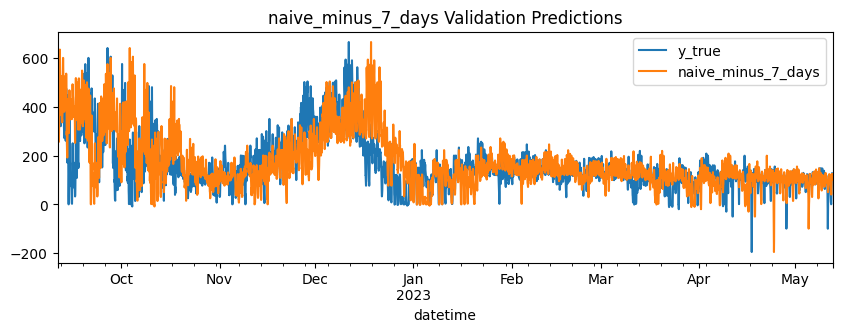

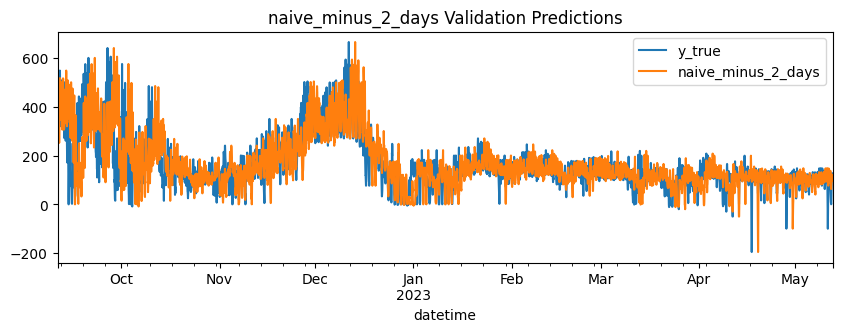

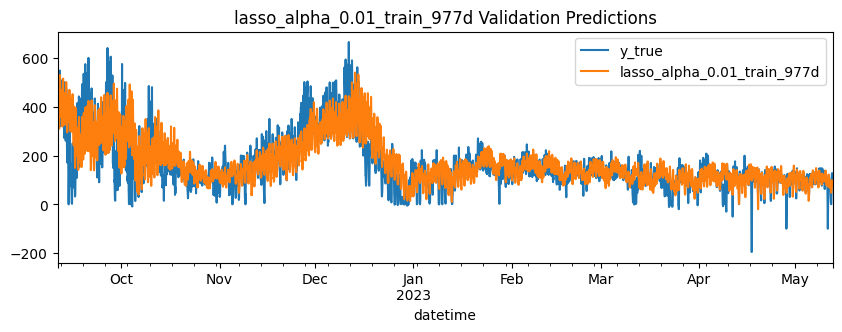

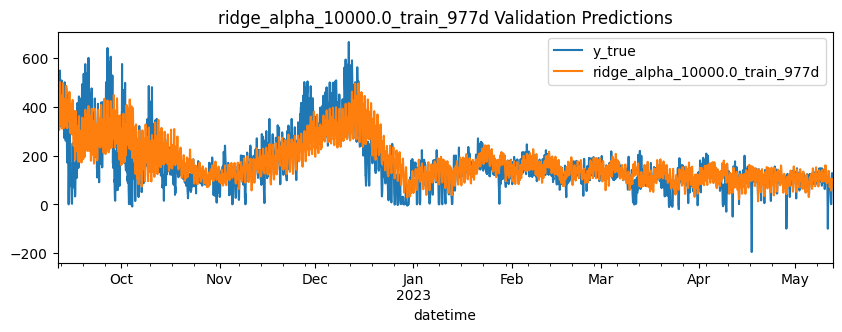

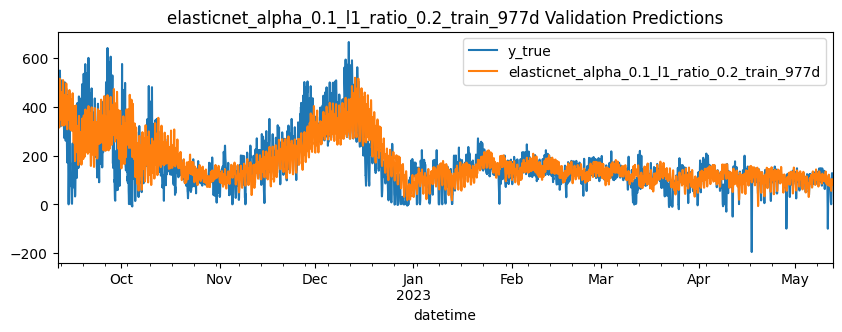

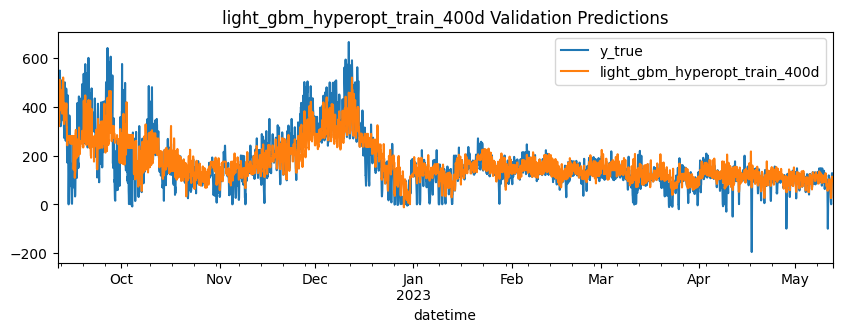

In [36]:
df_ae = []

for model in dict_pred_val.keys():
    fig, ax = plt.subplots(figsize=(10, 3))
    true = df_val.iloc[:24 * n_val_days].set_index("datetime")[target_name]
    pred = pd.DataFrame(dict_pred_val[model],columns=[model], index=true.index)
    ae = np.abs(true.values - pred[model].values)
    df_ae.append(pd.DataFrame(ae,columns=[model], index=true.index))
    true.plot(ax=ax, label='y_true', title=f'{model} Validation Predictions')
    pred.plot(ax=ax, label=model)                                   
    ax.legend()

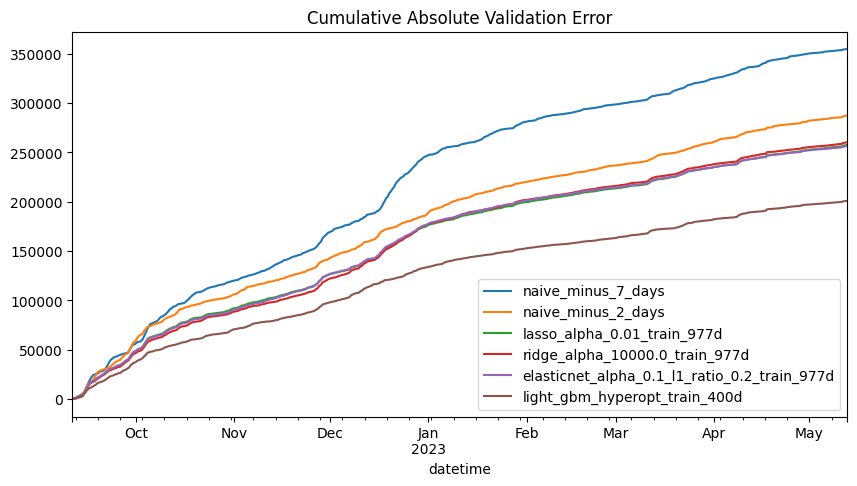

In [37]:
df_ae = pd.concat(df_ae, axis=1)

fig, ax = plt.subplots(figsize=(10, 5))
df_ae.cumsum().plot(ax=ax, title=f'Cumulative Absolute Validation Error')
ax.legend()

# Test Predictions

## Naive

In [5]:
test_days = len(df_test) // 24
startdate_test = df_test["datetime"].dt.date.min()
y_test = df_test[target_name].values
horizon_days_test = test_days
covariate_names = []

validation_days = len(df_test) // 24
startdate_val = df_test["datetime"].dt.date.min()
y_val = np.array([])
horizon_days_val = test_days

gap_days = 0

dict_models = {
    'naive': {
        'training_days':[training_days],
        'scale_data':False,
        'model_implementation':'sklearn',
        'model_params':{
            'lookback_horizon_days':[2,7]
        },
        'fit_params':{}
    }
}

save_predictions_flag = {
    'train':False,
    'val':False,
    'test':True
}

mlflow.set_experiment("/electricity-prices-test")

rwn = RollingWindowNaive(df, y_val, startdate_val, validation_days, horizon_days_val, y_test, startdate_test,
                         test_days, horizon_days_test, gap_days,target_name, covariate_names)

test_predictions_naive, test_results_naive =  rwn.train_models(dict_models, save_predictions_flag)

2024/07/01 17:27:16 INFO mlflow.tracking.fluent: Experiment with name '/electricity-prices-test' does not exist. Creating a new experiment.


Saving .\predictions\predictions_test_naive_lookback_horizon_days_2_train_914d_test_period_2023-05-19_2024-03-21.npy
Saving .\predictions\predictions_test_naive_lookback_horizon_days_7_train_914d_test_period_2023-05-19_2024-03-21.npy


## Linear Models

In [7]:
test_days = len(df_test) // 24
startdate_test = df_test["datetime"].dt.date.min()
y_test = df_test[target_name].values
horizon_days_test = 1

validation_days = len(df_test) // 24
startdate_val = startdate_test - timedelta(days=1)
y_val = np.array([])
horizon_days_val = 1

gap_days = 0

covariate_names = [col for col in df_train.columns]

for names in ['datetime', target_name]:
    covariate_names.remove(names)
    
binary_covariate_names = [
    'target_weekend',
    'target_is_holiday',
    'target_holiday_Eerste Kerstdag',
    'target_holiday_Eerste Pinksterdag',
    'target_holiday_Eerste paasdag',
    'target_holiday_Hemelvaartsdag',
    'target_holiday_Nieuwjaarsdag',
    'target_holiday_Tweede Kerstdag',
    'target_holiday_Tweede paasdag',
    'target_holiday_Tweede Pinksterdag',
]
categorical_covariate_names = [
    'target_hour_of_day',
    'target_day_of_week',
    'target_month'
]

rwlms = RollingWindowSklearn(df, y_val, startdate_val, validation_days, horizon_days_val, y_test, startdate_test,
                             test_days, horizon_days_test, gap_days, target_name, covariate_names,
                             binary_covariate_names, categorical_covariate_names)

dict_models = {
    'lasso': {
        'training_days':[100],
        'scale_data':True,
        'generate_dummy_features':True,
        'model_implementation':'sklearn',
        'model_instance': Lasso(random_state=0),
        'model_params':{
            'alpha':[0.1]
        },
        'fit_params':{}
    },
    'ridge': {
        'training_days':[200],
        'scale_data':True,
        'generate_dummy_features':True,
        'model_implementation':'sklearn',
        'model_instance': Ridge(random_state=0),
        'model_params':{
            'alpha':[5000.0]
        },
        'fit_params':{}
    },
    'elasticnet': {
        'training_days':[100],
        'scale_data':True,
        'generate_dummy_features':True,
        'model_implementation':'sklearn',
        'model_instance': ElasticNet(random_state=0),
        'model_params':{
            'alpha':[0.3],
            'l1_ratio':[0.5]
        },
        'fit_params':{}
    },    
}

save_predictions_flag = {
    'train':False,
    'val':False,
    'test':True
}


mlflow.set_experiment("/electricity-prices-test")
predictions_linear, results_linear = rwlms.train_models(dict_models, save_predictions_flag)

Loading predictions from .\predictions\predictions_test_lasso_alpha_0.1_train_100d_test_period_2023-05-19_2023-05-19.npy
Loading predictions from .\predictions\predictions_test_lasso_alpha_0.1_train_100d_test_period_2023-05-20_2023-05-20.npy
Loading predictions from .\predictions\predictions_test_lasso_alpha_0.1_train_100d_test_period_2023-05-21_2023-05-21.npy
Loading predictions from .\predictions\predictions_test_lasso_alpha_0.1_train_100d_test_period_2023-05-22_2023-05-22.npy
Loading predictions from .\predictions\predictions_test_lasso_alpha_0.1_train_100d_test_period_2023-05-23_2023-05-23.npy
Loading predictions from .\predictions\predictions_test_lasso_alpha_0.1_train_100d_test_period_2023-05-24_2023-05-24.npy
Loading predictions from .\predictions\predictions_test_lasso_alpha_0.1_train_100d_test_period_2023-05-25_2023-05-25.npy
Loading predictions from .\predictions\predictions_test_lasso_alpha_0.1_train_100d_test_period_2023-05-26_2023-05-26.npy
Loading predictions from .\predi

Loading predictions from .\predictions\predictions_test_ridge_alpha_5000.0_train_200d_test_period_2023-05-19_2023-05-19.npy
Loading predictions from .\predictions\predictions_test_ridge_alpha_5000.0_train_200d_test_period_2023-05-20_2023-05-20.npy
Loading model cache from .\models\model_cache_ridge_alpha_5000.0_train_200d_train_period_2022-11-02_2023-05-20.joblib
Saving model cache to .\models\model_cache_ridge_alpha_5000.0_train_200d_train_period_2022-11-02_2023-05-20.joblib
Loading model cache from .\models\model_cache_ridge_alpha_5000.0_train_200d_train_period_2022-11-02_2023-05-20.joblib
Saving .\predictions\predictions_test_ridge_alpha_5000.0_train_200d_test_period_2023-05-21_2023-05-21.npy
Loading model cache from .\models\model_cache_ridge_alpha_5000.0_train_200d_train_period_2022-11-03_2023-05-21.joblib
Saving model cache to .\models\model_cache_ridge_alpha_5000.0_train_200d_train_period_2022-11-03_2023-05-21.joblib
Loading model cache from .\models\model_cache_ridge_alpha_5000

Loading model cache from .\models\model_cache_ridge_alpha_5000.0_train_200d_train_period_2022-11-22_2023-06-09.joblib
Saving model cache to .\models\model_cache_ridge_alpha_5000.0_train_200d_train_period_2022-11-22_2023-06-09.joblib
Loading model cache from .\models\model_cache_ridge_alpha_5000.0_train_200d_train_period_2022-11-22_2023-06-09.joblib
Saving .\predictions\predictions_test_ridge_alpha_5000.0_train_200d_test_period_2023-06-10_2023-06-10.npy
Loading model cache from .\models\model_cache_ridge_alpha_5000.0_train_200d_train_period_2022-11-23_2023-06-10.joblib
Saving model cache to .\models\model_cache_ridge_alpha_5000.0_train_200d_train_period_2022-11-23_2023-06-10.joblib
Loading model cache from .\models\model_cache_ridge_alpha_5000.0_train_200d_train_period_2022-11-23_2023-06-10.joblib
Saving .\predictions\predictions_test_ridge_alpha_5000.0_train_200d_test_period_2023-06-11_2023-06-11.npy
Loading model cache from .\models\model_cache_ridge_alpha_5000.0_train_200d_train_peri

Loading model cache from .\models\model_cache_ridge_alpha_5000.0_train_200d_train_period_2022-12-11_2023-06-28.joblib
Saving model cache to .\models\model_cache_ridge_alpha_5000.0_train_200d_train_period_2022-12-11_2023-06-28.joblib
Loading model cache from .\models\model_cache_ridge_alpha_5000.0_train_200d_train_period_2022-12-11_2023-06-28.joblib
Saving .\predictions\predictions_test_ridge_alpha_5000.0_train_200d_test_period_2023-06-29_2023-06-29.npy
Loading model cache from .\models\model_cache_ridge_alpha_5000.0_train_200d_train_period_2022-12-12_2023-06-29.joblib
Saving model cache to .\models\model_cache_ridge_alpha_5000.0_train_200d_train_period_2022-12-12_2023-06-29.joblib
Loading model cache from .\models\model_cache_ridge_alpha_5000.0_train_200d_train_period_2022-12-12_2023-06-29.joblib
Saving .\predictions\predictions_test_ridge_alpha_5000.0_train_200d_test_period_2023-06-30_2023-06-30.npy
Loading model cache from .\models\model_cache_ridge_alpha_5000.0_train_200d_train_peri

Loading model cache from .\models\model_cache_ridge_alpha_5000.0_train_200d_train_period_2022-12-29_2023-07-16.joblib
Saving .\predictions\predictions_test_ridge_alpha_5000.0_train_200d_test_period_2023-07-17_2023-07-17.npy
Loading model cache from .\models\model_cache_ridge_alpha_5000.0_train_200d_train_period_2022-12-30_2023-07-17.joblib
Saving model cache to .\models\model_cache_ridge_alpha_5000.0_train_200d_train_period_2022-12-30_2023-07-17.joblib
Loading model cache from .\models\model_cache_ridge_alpha_5000.0_train_200d_train_period_2022-12-30_2023-07-17.joblib
Saving .\predictions\predictions_test_ridge_alpha_5000.0_train_200d_test_period_2023-07-18_2023-07-18.npy
Loading model cache from .\models\model_cache_ridge_alpha_5000.0_train_200d_train_period_2022-12-31_2023-07-18.joblib
Saving model cache to .\models\model_cache_ridge_alpha_5000.0_train_200d_train_period_2022-12-31_2023-07-18.joblib
Loading model cache from .\models\model_cache_ridge_alpha_5000.0_train_200d_train_peri

Loading model cache from .\models\model_cache_ridge_alpha_5000.0_train_200d_train_period_2023-01-16_2023-08-03.joblib
Saving .\predictions\predictions_test_ridge_alpha_5000.0_train_200d_test_period_2023-08-04_2023-08-04.npy
Loading model cache from .\models\model_cache_ridge_alpha_5000.0_train_200d_train_period_2023-01-17_2023-08-04.joblib
Saving model cache to .\models\model_cache_ridge_alpha_5000.0_train_200d_train_period_2023-01-17_2023-08-04.joblib
Loading model cache from .\models\model_cache_ridge_alpha_5000.0_train_200d_train_period_2023-01-17_2023-08-04.joblib
Saving .\predictions\predictions_test_ridge_alpha_5000.0_train_200d_test_period_2023-08-05_2023-08-05.npy
Loading model cache from .\models\model_cache_ridge_alpha_5000.0_train_200d_train_period_2023-01-18_2023-08-05.joblib
Saving model cache to .\models\model_cache_ridge_alpha_5000.0_train_200d_train_period_2023-01-18_2023-08-05.joblib
Loading model cache from .\models\model_cache_ridge_alpha_5000.0_train_200d_train_peri

Loading model cache from .\models\model_cache_ridge_alpha_5000.0_train_200d_train_period_2023-02-04_2023-08-22.joblib
Saving .\predictions\predictions_test_ridge_alpha_5000.0_train_200d_test_period_2023-08-23_2023-08-23.npy
Loading model cache from .\models\model_cache_ridge_alpha_5000.0_train_200d_train_period_2023-02-05_2023-08-23.joblib
Saving model cache to .\models\model_cache_ridge_alpha_5000.0_train_200d_train_period_2023-02-05_2023-08-23.joblib
Loading model cache from .\models\model_cache_ridge_alpha_5000.0_train_200d_train_period_2023-02-05_2023-08-23.joblib
Saving .\predictions\predictions_test_ridge_alpha_5000.0_train_200d_test_period_2023-08-24_2023-08-24.npy
Loading model cache from .\models\model_cache_ridge_alpha_5000.0_train_200d_train_period_2023-02-06_2023-08-24.joblib
Saving model cache to .\models\model_cache_ridge_alpha_5000.0_train_200d_train_period_2023-02-06_2023-08-24.joblib
Loading model cache from .\models\model_cache_ridge_alpha_5000.0_train_200d_train_peri

Saving model cache to .\models\model_cache_ridge_alpha_5000.0_train_200d_train_period_2023-02-23_2023-09-10.joblib
Loading model cache from .\models\model_cache_ridge_alpha_5000.0_train_200d_train_period_2023-02-23_2023-09-10.joblib
Saving .\predictions\predictions_test_ridge_alpha_5000.0_train_200d_test_period_2023-09-11_2023-09-11.npy
Saving model cache to .\models\model_cache_ridge_alpha_5000.0_train_200d_train_period_2023-02-24_2023-09-11.joblib
Loading model cache from .\models\model_cache_ridge_alpha_5000.0_train_200d_train_period_2023-02-24_2023-09-11.joblib
Saving .\predictions\predictions_test_ridge_alpha_5000.0_train_200d_test_period_2023-09-12_2023-09-12.npy
Saving model cache to .\models\model_cache_ridge_alpha_5000.0_train_200d_train_period_2023-02-25_2023-09-12.joblib
Loading model cache from .\models\model_cache_ridge_alpha_5000.0_train_200d_train_period_2023-02-25_2023-09-12.joblib
Saving .\predictions\predictions_test_ridge_alpha_5000.0_train_200d_test_period_2023-09-1

Saving model cache to .\models\model_cache_ridge_alpha_5000.0_train_200d_train_period_2023-03-22_2023-10-07.joblib
Loading model cache from .\models\model_cache_ridge_alpha_5000.0_train_200d_train_period_2023-03-22_2023-10-07.joblib
Saving .\predictions\predictions_test_ridge_alpha_5000.0_train_200d_test_period_2023-10-08_2023-10-08.npy
Saving model cache to .\models\model_cache_ridge_alpha_5000.0_train_200d_train_period_2023-03-23_2023-10-08.joblib
Loading model cache from .\models\model_cache_ridge_alpha_5000.0_train_200d_train_period_2023-03-23_2023-10-08.joblib
Saving .\predictions\predictions_test_ridge_alpha_5000.0_train_200d_test_period_2023-10-09_2023-10-09.npy
Saving model cache to .\models\model_cache_ridge_alpha_5000.0_train_200d_train_period_2023-03-24_2023-10-09.joblib
Loading model cache from .\models\model_cache_ridge_alpha_5000.0_train_200d_train_period_2023-03-24_2023-10-09.joblib
Saving .\predictions\predictions_test_ridge_alpha_5000.0_train_200d_test_period_2023-10-1

Saving model cache to .\models\model_cache_ridge_alpha_5000.0_train_200d_train_period_2023-04-18_2023-11-03.joblib
Loading model cache from .\models\model_cache_ridge_alpha_5000.0_train_200d_train_period_2023-04-18_2023-11-03.joblib
Saving .\predictions\predictions_test_ridge_alpha_5000.0_train_200d_test_period_2023-11-04_2023-11-04.npy
Saving model cache to .\models\model_cache_ridge_alpha_5000.0_train_200d_train_period_2023-04-19_2023-11-04.joblib
Loading model cache from .\models\model_cache_ridge_alpha_5000.0_train_200d_train_period_2023-04-19_2023-11-04.joblib
Saving .\predictions\predictions_test_ridge_alpha_5000.0_train_200d_test_period_2023-11-05_2023-11-05.npy
Saving model cache to .\models\model_cache_ridge_alpha_5000.0_train_200d_train_period_2023-04-20_2023-11-05.joblib
Loading model cache from .\models\model_cache_ridge_alpha_5000.0_train_200d_train_period_2023-04-20_2023-11-05.joblib
Saving .\predictions\predictions_test_ridge_alpha_5000.0_train_200d_test_period_2023-11-0

Saving model cache to .\models\model_cache_ridge_alpha_5000.0_train_200d_train_period_2023-05-14_2023-11-29.joblib
Loading model cache from .\models\model_cache_ridge_alpha_5000.0_train_200d_train_period_2023-05-14_2023-11-29.joblib
Saving .\predictions\predictions_test_ridge_alpha_5000.0_train_200d_test_period_2023-11-30_2023-11-30.npy
Saving model cache to .\models\model_cache_ridge_alpha_5000.0_train_200d_train_period_2023-05-15_2023-11-30.joblib
Loading model cache from .\models\model_cache_ridge_alpha_5000.0_train_200d_train_period_2023-05-15_2023-11-30.joblib
Saving .\predictions\predictions_test_ridge_alpha_5000.0_train_200d_test_period_2023-12-01_2023-12-01.npy
Saving model cache to .\models\model_cache_ridge_alpha_5000.0_train_200d_train_period_2023-05-16_2023-12-01.joblib
Loading model cache from .\models\model_cache_ridge_alpha_5000.0_train_200d_train_period_2023-05-16_2023-12-01.joblib
Saving .\predictions\predictions_test_ridge_alpha_5000.0_train_200d_test_period_2023-12-0

Saving .\predictions\predictions_test_ridge_alpha_5000.0_train_200d_test_period_2023-12-24_2023-12-24.npy
Saving model cache to .\models\model_cache_ridge_alpha_5000.0_train_200d_train_period_2023-06-08_2023-12-24.joblib
Loading model cache from .\models\model_cache_ridge_alpha_5000.0_train_200d_train_period_2023-06-08_2023-12-24.joblib
Saving .\predictions\predictions_test_ridge_alpha_5000.0_train_200d_test_period_2023-12-25_2023-12-25.npy
Saving model cache to .\models\model_cache_ridge_alpha_5000.0_train_200d_train_period_2023-06-09_2023-12-25.joblib
Loading model cache from .\models\model_cache_ridge_alpha_5000.0_train_200d_train_period_2023-06-09_2023-12-25.joblib
Saving .\predictions\predictions_test_ridge_alpha_5000.0_train_200d_test_period_2023-12-26_2023-12-26.npy
Saving model cache to .\models\model_cache_ridge_alpha_5000.0_train_200d_train_period_2023-06-10_2023-12-26.joblib
Loading model cache from .\models\model_cache_ridge_alpha_5000.0_train_200d_train_period_2023-06-10_2

Saving model cache to .\models\model_cache_ridge_alpha_5000.0_train_200d_train_period_2023-07-04_2024-01-19.joblib
Loading model cache from .\models\model_cache_ridge_alpha_5000.0_train_200d_train_period_2023-07-04_2024-01-19.joblib
Saving .\predictions\predictions_test_ridge_alpha_5000.0_train_200d_test_period_2024-01-20_2024-01-20.npy
Saving model cache to .\models\model_cache_ridge_alpha_5000.0_train_200d_train_period_2023-07-05_2024-01-20.joblib
Loading model cache from .\models\model_cache_ridge_alpha_5000.0_train_200d_train_period_2023-07-05_2024-01-20.joblib
Saving .\predictions\predictions_test_ridge_alpha_5000.0_train_200d_test_period_2024-01-21_2024-01-21.npy
Saving model cache to .\models\model_cache_ridge_alpha_5000.0_train_200d_train_period_2023-07-06_2024-01-21.joblib
Loading model cache from .\models\model_cache_ridge_alpha_5000.0_train_200d_train_period_2023-07-06_2024-01-21.joblib
Saving .\predictions\predictions_test_ridge_alpha_5000.0_train_200d_test_period_2024-01-2

Saving model cache to .\models\model_cache_ridge_alpha_5000.0_train_200d_train_period_2023-07-31_2024-02-15.joblib
Loading model cache from .\models\model_cache_ridge_alpha_5000.0_train_200d_train_period_2023-07-31_2024-02-15.joblib
Saving .\predictions\predictions_test_ridge_alpha_5000.0_train_200d_test_period_2024-02-16_2024-02-16.npy
Saving model cache to .\models\model_cache_ridge_alpha_5000.0_train_200d_train_period_2023-08-01_2024-02-16.joblib
Loading model cache from .\models\model_cache_ridge_alpha_5000.0_train_200d_train_period_2023-08-01_2024-02-16.joblib
Saving .\predictions\predictions_test_ridge_alpha_5000.0_train_200d_test_period_2024-02-17_2024-02-17.npy
Saving model cache to .\models\model_cache_ridge_alpha_5000.0_train_200d_train_period_2023-08-02_2024-02-17.joblib
Loading model cache from .\models\model_cache_ridge_alpha_5000.0_train_200d_train_period_2023-08-02_2024-02-17.joblib
Saving .\predictions\predictions_test_ridge_alpha_5000.0_train_200d_test_period_2024-02-1

Saving model cache to .\models\model_cache_ridge_alpha_5000.0_train_200d_train_period_2023-08-26_2024-03-12.joblib
Loading model cache from .\models\model_cache_ridge_alpha_5000.0_train_200d_train_period_2023-08-26_2024-03-12.joblib
Saving .\predictions\predictions_test_ridge_alpha_5000.0_train_200d_test_period_2024-03-13_2024-03-13.npy
Saving model cache to .\models\model_cache_ridge_alpha_5000.0_train_200d_train_period_2023-08-27_2024-03-13.joblib
Loading model cache from .\models\model_cache_ridge_alpha_5000.0_train_200d_train_period_2023-08-27_2024-03-13.joblib
Saving .\predictions\predictions_test_ridge_alpha_5000.0_train_200d_test_period_2024-03-14_2024-03-14.npy
Saving model cache to .\models\model_cache_ridge_alpha_5000.0_train_200d_train_period_2023-08-28_2024-03-14.joblib
Loading model cache from .\models\model_cache_ridge_alpha_5000.0_train_200d_train_period_2023-08-28_2024-03-14.joblib
Saving .\predictions\predictions_test_ridge_alpha_5000.0_train_200d_test_period_2024-03-1

Saving model cache to .\models\model_cache_elasticnet_alpha_0.3_l1_ratio_0.5_train_100d_train_period_2023-02-24_2023-06-03.joblib
Loading model cache from .\models\model_cache_elasticnet_alpha_0.3_l1_ratio_0.5_train_100d_train_period_2023-02-24_2023-06-03.joblib
Saving .\predictions\predictions_test_elasticnet_alpha_0.3_l1_ratio_0.5_train_100d_test_period_2023-06-04_2023-06-04.npy
Saving model cache to .\models\model_cache_elasticnet_alpha_0.3_l1_ratio_0.5_train_100d_train_period_2023-02-25_2023-06-04.joblib
Loading model cache from .\models\model_cache_elasticnet_alpha_0.3_l1_ratio_0.5_train_100d_train_period_2023-02-25_2023-06-04.joblib
Saving .\predictions\predictions_test_elasticnet_alpha_0.3_l1_ratio_0.5_train_100d_test_period_2023-06-05_2023-06-05.npy
Saving model cache to .\models\model_cache_elasticnet_alpha_0.3_l1_ratio_0.5_train_100d_train_period_2023-02-26_2023-06-05.joblib
Loading model cache from .\models\model_cache_elasticnet_alpha_0.3_l1_ratio_0.5_train_100d_train_perio

Saving model cache to .\models\model_cache_elasticnet_alpha_0.3_l1_ratio_0.5_train_100d_train_period_2023-03-19_2023-06-26.joblib
Loading model cache from .\models\model_cache_elasticnet_alpha_0.3_l1_ratio_0.5_train_100d_train_period_2023-03-19_2023-06-26.joblib
Saving .\predictions\predictions_test_elasticnet_alpha_0.3_l1_ratio_0.5_train_100d_test_period_2023-06-27_2023-06-27.npy
Saving model cache to .\models\model_cache_elasticnet_alpha_0.3_l1_ratio_0.5_train_100d_train_period_2023-03-20_2023-06-27.joblib
Loading model cache from .\models\model_cache_elasticnet_alpha_0.3_l1_ratio_0.5_train_100d_train_period_2023-03-20_2023-06-27.joblib
Saving .\predictions\predictions_test_elasticnet_alpha_0.3_l1_ratio_0.5_train_100d_test_period_2023-06-28_2023-06-28.npy
Saving model cache to .\models\model_cache_elasticnet_alpha_0.3_l1_ratio_0.5_train_100d_train_period_2023-03-21_2023-06-28.joblib
Loading model cache from .\models\model_cache_elasticnet_alpha_0.3_l1_ratio_0.5_train_100d_train_perio

Saving model cache to .\models\model_cache_elasticnet_alpha_0.3_l1_ratio_0.5_train_100d_train_period_2023-04-10_2023-07-18.joblib
Loading model cache from .\models\model_cache_elasticnet_alpha_0.3_l1_ratio_0.5_train_100d_train_period_2023-04-10_2023-07-18.joblib
Saving .\predictions\predictions_test_elasticnet_alpha_0.3_l1_ratio_0.5_train_100d_test_period_2023-07-19_2023-07-19.npy
Saving model cache to .\models\model_cache_elasticnet_alpha_0.3_l1_ratio_0.5_train_100d_train_period_2023-04-11_2023-07-19.joblib
Loading model cache from .\models\model_cache_elasticnet_alpha_0.3_l1_ratio_0.5_train_100d_train_period_2023-04-11_2023-07-19.joblib
Saving .\predictions\predictions_test_elasticnet_alpha_0.3_l1_ratio_0.5_train_100d_test_period_2023-07-20_2023-07-20.npy
Saving model cache to .\models\model_cache_elasticnet_alpha_0.3_l1_ratio_0.5_train_100d_train_period_2023-04-12_2023-07-20.joblib
Loading model cache from .\models\model_cache_elasticnet_alpha_0.3_l1_ratio_0.5_train_100d_train_perio

Saving model cache to .\models\model_cache_elasticnet_alpha_0.3_l1_ratio_0.5_train_100d_train_period_2023-05-02_2023-08-09.joblib
Loading model cache from .\models\model_cache_elasticnet_alpha_0.3_l1_ratio_0.5_train_100d_train_period_2023-05-02_2023-08-09.joblib
Saving .\predictions\predictions_test_elasticnet_alpha_0.3_l1_ratio_0.5_train_100d_test_period_2023-08-10_2023-08-10.npy
Saving model cache to .\models\model_cache_elasticnet_alpha_0.3_l1_ratio_0.5_train_100d_train_period_2023-05-03_2023-08-10.joblib
Loading model cache from .\models\model_cache_elasticnet_alpha_0.3_l1_ratio_0.5_train_100d_train_period_2023-05-03_2023-08-10.joblib
Saving .\predictions\predictions_test_elasticnet_alpha_0.3_l1_ratio_0.5_train_100d_test_period_2023-08-11_2023-08-11.npy
Saving model cache to .\models\model_cache_elasticnet_alpha_0.3_l1_ratio_0.5_train_100d_train_period_2023-05-04_2023-08-11.joblib
Loading model cache from .\models\model_cache_elasticnet_alpha_0.3_l1_ratio_0.5_train_100d_train_perio

Loading model cache from .\models\model_cache_elasticnet_alpha_0.3_l1_ratio_0.5_train_100d_train_period_2023-05-23_2023-08-30.joblib
Saving .\predictions\predictions_test_elasticnet_alpha_0.3_l1_ratio_0.5_train_100d_test_period_2023-08-31_2023-08-31.npy
Saving model cache to .\models\model_cache_elasticnet_alpha_0.3_l1_ratio_0.5_train_100d_train_period_2023-05-24_2023-08-31.joblib
Loading model cache from .\models\model_cache_elasticnet_alpha_0.3_l1_ratio_0.5_train_100d_train_period_2023-05-24_2023-08-31.joblib
Saving .\predictions\predictions_test_elasticnet_alpha_0.3_l1_ratio_0.5_train_100d_test_period_2023-09-01_2023-09-01.npy
Saving model cache to .\models\model_cache_elasticnet_alpha_0.3_l1_ratio_0.5_train_100d_train_period_2023-05-25_2023-09-01.joblib
Loading model cache from .\models\model_cache_elasticnet_alpha_0.3_l1_ratio_0.5_train_100d_train_period_2023-05-25_2023-09-01.joblib
Saving .\predictions\predictions_test_elasticnet_alpha_0.3_l1_ratio_0.5_train_100d_test_period_2023

Saving model cache to .\models\model_cache_elasticnet_alpha_0.3_l1_ratio_0.5_train_100d_train_period_2023-06-14_2023-09-21.joblib
Loading model cache from .\models\model_cache_elasticnet_alpha_0.3_l1_ratio_0.5_train_100d_train_period_2023-06-14_2023-09-21.joblib
Saving .\predictions\predictions_test_elasticnet_alpha_0.3_l1_ratio_0.5_train_100d_test_period_2023-09-22_2023-09-22.npy
Saving model cache to .\models\model_cache_elasticnet_alpha_0.3_l1_ratio_0.5_train_100d_train_period_2023-06-15_2023-09-22.joblib
Loading model cache from .\models\model_cache_elasticnet_alpha_0.3_l1_ratio_0.5_train_100d_train_period_2023-06-15_2023-09-22.joblib
Saving .\predictions\predictions_test_elasticnet_alpha_0.3_l1_ratio_0.5_train_100d_test_period_2023-09-23_2023-09-23.npy
Saving model cache to .\models\model_cache_elasticnet_alpha_0.3_l1_ratio_0.5_train_100d_train_period_2023-06-16_2023-09-23.joblib
Loading model cache from .\models\model_cache_elasticnet_alpha_0.3_l1_ratio_0.5_train_100d_train_perio

Saving model cache to .\models\model_cache_elasticnet_alpha_0.3_l1_ratio_0.5_train_100d_train_period_2023-07-08_2023-10-15.joblib
Loading model cache from .\models\model_cache_elasticnet_alpha_0.3_l1_ratio_0.5_train_100d_train_period_2023-07-08_2023-10-15.joblib
Saving .\predictions\predictions_test_elasticnet_alpha_0.3_l1_ratio_0.5_train_100d_test_period_2023-10-16_2023-10-16.npy
Saving model cache to .\models\model_cache_elasticnet_alpha_0.3_l1_ratio_0.5_train_100d_train_period_2023-07-09_2023-10-16.joblib
Loading model cache from .\models\model_cache_elasticnet_alpha_0.3_l1_ratio_0.5_train_100d_train_period_2023-07-09_2023-10-16.joblib
Saving .\predictions\predictions_test_elasticnet_alpha_0.3_l1_ratio_0.5_train_100d_test_period_2023-10-17_2023-10-17.npy
Saving model cache to .\models\model_cache_elasticnet_alpha_0.3_l1_ratio_0.5_train_100d_train_period_2023-07-10_2023-10-17.joblib
Loading model cache from .\models\model_cache_elasticnet_alpha_0.3_l1_ratio_0.5_train_100d_train_perio

Saving model cache to .\models\model_cache_elasticnet_alpha_0.3_l1_ratio_0.5_train_100d_train_period_2023-08-01_2023-11-08.joblib
Loading model cache from .\models\model_cache_elasticnet_alpha_0.3_l1_ratio_0.5_train_100d_train_period_2023-08-01_2023-11-08.joblib
Saving .\predictions\predictions_test_elasticnet_alpha_0.3_l1_ratio_0.5_train_100d_test_period_2023-11-09_2023-11-09.npy
Saving model cache to .\models\model_cache_elasticnet_alpha_0.3_l1_ratio_0.5_train_100d_train_period_2023-08-02_2023-11-09.joblib
Loading model cache from .\models\model_cache_elasticnet_alpha_0.3_l1_ratio_0.5_train_100d_train_period_2023-08-02_2023-11-09.joblib
Saving .\predictions\predictions_test_elasticnet_alpha_0.3_l1_ratio_0.5_train_100d_test_period_2023-11-10_2023-11-10.npy
Saving model cache to .\models\model_cache_elasticnet_alpha_0.3_l1_ratio_0.5_train_100d_train_period_2023-08-03_2023-11-10.joblib
Loading model cache from .\models\model_cache_elasticnet_alpha_0.3_l1_ratio_0.5_train_100d_train_perio

Saving model cache to .\models\model_cache_elasticnet_alpha_0.3_l1_ratio_0.5_train_100d_train_period_2023-08-25_2023-12-02.joblib
Loading model cache from .\models\model_cache_elasticnet_alpha_0.3_l1_ratio_0.5_train_100d_train_period_2023-08-25_2023-12-02.joblib
Saving .\predictions\predictions_test_elasticnet_alpha_0.3_l1_ratio_0.5_train_100d_test_period_2023-12-03_2023-12-03.npy
Saving model cache to .\models\model_cache_elasticnet_alpha_0.3_l1_ratio_0.5_train_100d_train_period_2023-08-26_2023-12-03.joblib
Loading model cache from .\models\model_cache_elasticnet_alpha_0.3_l1_ratio_0.5_train_100d_train_period_2023-08-26_2023-12-03.joblib
Saving .\predictions\predictions_test_elasticnet_alpha_0.3_l1_ratio_0.5_train_100d_test_period_2023-12-04_2023-12-04.npy
Saving model cache to .\models\model_cache_elasticnet_alpha_0.3_l1_ratio_0.5_train_100d_train_period_2023-08-27_2023-12-04.joblib
Loading model cache from .\models\model_cache_elasticnet_alpha_0.3_l1_ratio_0.5_train_100d_train_perio

Loading model cache from .\models\model_cache_elasticnet_alpha_0.3_l1_ratio_0.5_train_100d_train_period_2023-09-17_2023-12-25.joblib
Saving .\predictions\predictions_test_elasticnet_alpha_0.3_l1_ratio_0.5_train_100d_test_period_2023-12-26_2023-12-26.npy
Saving model cache to .\models\model_cache_elasticnet_alpha_0.3_l1_ratio_0.5_train_100d_train_period_2023-09-18_2023-12-26.joblib
Loading model cache from .\models\model_cache_elasticnet_alpha_0.3_l1_ratio_0.5_train_100d_train_period_2023-09-18_2023-12-26.joblib
Saving .\predictions\predictions_test_elasticnet_alpha_0.3_l1_ratio_0.5_train_100d_test_period_2023-12-27_2023-12-27.npy
Saving model cache to .\models\model_cache_elasticnet_alpha_0.3_l1_ratio_0.5_train_100d_train_period_2023-09-19_2023-12-27.joblib
Loading model cache from .\models\model_cache_elasticnet_alpha_0.3_l1_ratio_0.5_train_100d_train_period_2023-09-19_2023-12-27.joblib
Saving .\predictions\predictions_test_elasticnet_alpha_0.3_l1_ratio_0.5_train_100d_test_period_2023

Saving model cache to .\models\model_cache_elasticnet_alpha_0.3_l1_ratio_0.5_train_100d_train_period_2023-10-10_2024-01-17.joblib
Loading model cache from .\models\model_cache_elasticnet_alpha_0.3_l1_ratio_0.5_train_100d_train_period_2023-10-10_2024-01-17.joblib
Saving .\predictions\predictions_test_elasticnet_alpha_0.3_l1_ratio_0.5_train_100d_test_period_2024-01-18_2024-01-18.npy
Saving model cache to .\models\model_cache_elasticnet_alpha_0.3_l1_ratio_0.5_train_100d_train_period_2023-10-11_2024-01-18.joblib
Loading model cache from .\models\model_cache_elasticnet_alpha_0.3_l1_ratio_0.5_train_100d_train_period_2023-10-11_2024-01-18.joblib
Saving .\predictions\predictions_test_elasticnet_alpha_0.3_l1_ratio_0.5_train_100d_test_period_2024-01-19_2024-01-19.npy
Saving model cache to .\models\model_cache_elasticnet_alpha_0.3_l1_ratio_0.5_train_100d_train_period_2023-10-12_2024-01-19.joblib
Loading model cache from .\models\model_cache_elasticnet_alpha_0.3_l1_ratio_0.5_train_100d_train_perio

Saving model cache to .\models\model_cache_elasticnet_alpha_0.3_l1_ratio_0.5_train_100d_train_period_2023-11-01_2024-02-08.joblib
Loading model cache from .\models\model_cache_elasticnet_alpha_0.3_l1_ratio_0.5_train_100d_train_period_2023-11-01_2024-02-08.joblib
Saving .\predictions\predictions_test_elasticnet_alpha_0.3_l1_ratio_0.5_train_100d_test_period_2024-02-09_2024-02-09.npy
Saving model cache to .\models\model_cache_elasticnet_alpha_0.3_l1_ratio_0.5_train_100d_train_period_2023-11-02_2024-02-09.joblib
Loading model cache from .\models\model_cache_elasticnet_alpha_0.3_l1_ratio_0.5_train_100d_train_period_2023-11-02_2024-02-09.joblib
Saving .\predictions\predictions_test_elasticnet_alpha_0.3_l1_ratio_0.5_train_100d_test_period_2024-02-10_2024-02-10.npy
Saving model cache to .\models\model_cache_elasticnet_alpha_0.3_l1_ratio_0.5_train_100d_train_period_2023-11-03_2024-02-10.joblib
Loading model cache from .\models\model_cache_elasticnet_alpha_0.3_l1_ratio_0.5_train_100d_train_perio

Loading model cache from .\models\model_cache_elasticnet_alpha_0.3_l1_ratio_0.5_train_100d_train_period_2023-11-23_2024-03-01.joblib
Saving .\predictions\predictions_test_elasticnet_alpha_0.3_l1_ratio_0.5_train_100d_test_period_2024-03-02_2024-03-02.npy
Saving model cache to .\models\model_cache_elasticnet_alpha_0.3_l1_ratio_0.5_train_100d_train_period_2023-11-24_2024-03-02.joblib
Loading model cache from .\models\model_cache_elasticnet_alpha_0.3_l1_ratio_0.5_train_100d_train_period_2023-11-24_2024-03-02.joblib
Saving .\predictions\predictions_test_elasticnet_alpha_0.3_l1_ratio_0.5_train_100d_test_period_2024-03-03_2024-03-03.npy
Saving model cache to .\models\model_cache_elasticnet_alpha_0.3_l1_ratio_0.5_train_100d_train_period_2023-11-25_2024-03-03.joblib
Loading model cache from .\models\model_cache_elasticnet_alpha_0.3_l1_ratio_0.5_train_100d_train_period_2023-11-25_2024-03-03.joblib
Saving .\predictions\predictions_test_elasticnet_alpha_0.3_l1_ratio_0.5_train_100d_test_period_2024

## Light GBM

In [18]:
test_days = len(df_test) // 24
startdate_test = df_test["datetime"].dt.date.min()
y_test = df_test[target_name].values
horizon_days_test = 1

validation_days = len(df_test) // 24
startdate_val = startdate_test - timedelta(days=1)
y_val = np.array([])
horizon_days_val = 1

gap_days = 0

covariate_names = [
    'day_ahead_prices_lag_120',
    'day_ahead_prices',
    'target_month',
    'generation_fossil_gas_missing_qty',
    'generation_fossil_gas_missing_qty_lag_120',
    'pressure_weighted',
    'generation_Biomass',
    'generation_forecast_lag_120',
    'Forecasted Load_lag_120',
    'generation_Fossil Hard coal_lag_120',
    'target_hour_of_day',
    'generation_forecast_Wind_lag_120',
    'generation_Biomass_lag_120',
    'imports_lag_120',
    'target_day_of_week',
    'dew_point_weighted',
    'generation_Wind_lag_120',
    'generation_Nuclear',
    'generation_Fossil Hard coal',
    'generation_fossil_hard_coal_missing_qty',
    'generation_Fossil Gas',
    'imports',
    'generation_Wind',
    'generation_Waste',
]

categorical_covariate_names = [
    'target_month',
    'target_hour_of_day',
    'target_day_of_week',
    'target_weekend',
    'target_is_holiday',
    'target_holiday_Eerste Kerstdag',
    'target_holiday_Eerste Pinksterdag',
    'target_holiday_Eerste paasdag',
    'target_holiday_Hemelvaartsdag',
    'target_holiday_Nieuwjaarsdag',
    'target_holiday_Tweede Kerstdag',
    'target_holiday_Tweede paasdag',
    'target_holiday_Tweede Pinksterdag'
]


binary_covariate_names = None

training_days = 200

mlflow.set_experiment("/electricity-prices-test")

model_name = "light_gbm_hyperopt"
    
rwlgbm = RollingWindowLightGBM(df, y_val, startdate_val, validation_days, horizon_days_val, y_test, startdate_test,
                               test_days, horizon_days_test, gap_days, target_name, covariate_names,
                               binary_covariate_names, categorical_covariate_names)

filename = f".\\models\\hyperparams_{model_name}_{training_days}d.joblib"
params = rwlgbm.load_model_cache(filename)

params["n_estimators"] = params.pop('num_iterations')

dict_models = {
    model_name: {
        'training_days': [training_days],
        'scale_data': False,
        'generate_dummy_features': False,
        'model_implementation': 'sklearn',
        'model_instance': LGBMRegressor(n_jobs=-1, random_state=0, verbosity=-1, **params),
        'model_params': {},
        'fit_params':{}
    }
}

save_predictions_flag = {
    'train':False,
    'val':False,
    'test':True
}

predictions_light_gbm, results_light_gbm = rwlgbm.train_models(dict_models, save_predictions_flag)

Loading model cache from .\models\hyperparams_light_gbm_hyperopt_200d.joblib
Loading predictions from .\predictions\predictions_test_light_gbm_hyperopt__train_200d_test_period_2023-05-19_2023-05-19.npy
Loading predictions from .\predictions\predictions_test_light_gbm_hyperopt__train_200d_test_period_2023-05-20_2023-05-20.npy
Loading predictions from .\predictions\predictions_test_light_gbm_hyperopt__train_200d_test_period_2023-05-21_2023-05-21.npy
Loading predictions from .\predictions\predictions_test_light_gbm_hyperopt__train_200d_test_period_2023-05-22_2023-05-22.npy
Loading predictions from .\predictions\predictions_test_light_gbm_hyperopt__train_200d_test_period_2023-05-23_2023-05-23.npy
Loading predictions from .\predictions\predictions_test_light_gbm_hyperopt__train_200d_test_period_2023-05-24_2023-05-24.npy
Loading predictions from .\predictions\predictions_test_light_gbm_hyperopt__train_200d_test_period_2023-05-25_2023-05-25.npy
Loading predictions from .\predictions\predictio

## GAM

In [70]:
n_val_days = len(df_val) // 24
y_val = df_val[target_name].values[:24 * n_val_days]
val_startdate = df_val["datetime"].dt.date.min()

rwlg = RollingWindowLinearGam()

In [73]:
covariate_names = [col for col in df_train.columns if ("holiday_" not in col)]

cols_2_remove = ['datetime', target_name]

for col in cols_2_remove:
    covariate_names.remove(col)
    
discrete_features  =  ['month', 'is_holiday', 'weekend', 'hour_of_day', 'day_of_week']
ind_discrete_features = [i for i, feature in enumerate(covariate_names) if feature in discrete_features]
    
df_y = df_train[target_name].copy()
df_X = df_train[covariate_names].copy()

mutual_info = mutual_info_regression(df_X, df_y, discrete_features=ind_discrete_features)
mutual_info = pd.Series(mutual_info)
mutual_info.index = df_X.columns
mutual_info = mutual_info.sort_values(ascending=False)
mutual_info

day_ahead_prices_lag_120                           1.025859
day_ahead_prices                                   0.946776
generation_fossil_gas_missing_qty_lag_120          0.634711
generation_fossil_gas_missing_qty                  0.608783
generation_fossil_hard_coal_missing_qty_lag_120    0.580432
generation_fossil_hard_coal_missing_qty            0.573288
generation_Nuclear_lag_120                         0.401010
generation_Nuclear                                 0.389156
generation_Fossil Hard coal_lag_120                0.371345
generation_Fossil Hard coal                        0.334944
generation_Biomass_lag_120                         0.334643
generation_Biomass                                 0.331503
month                                              0.295602
imports_lag_120                                    0.259171
imports                                            0.257733
generation_Solar                                   0.176692
generation_Solar_lag_120                

### 50 training days

In [ ]:
covariate_names = mutual_info.index.to_list()
covariate_names.remove('target_month')

binary_covariate_names = ['target_is_holiday', 'target_weekend', 'target_hour_of_day', 'target_day_of_week']
cat_covariate_names = None
n_train_day = 50
use_grid_search = True
n_parameter_trials = 25
lamda_alpha = 0
lamda_beta = 2

_, _, _, _ = rwlg.get_optimal_gam_covariates_and_lamdas(df, n_train_day, val_startdate, target_name, covariate_names, 
                                                     binary_covariate_names, cat_covariate_names, print_summary=True,
                                                     use_grid_search=use_grid_search, n_parameter_trials=n_parameter_trials,
                                                     lamda_alpha=lamda_alpha, lamda_beta=lamda_beta)

In [ ]:
temp_model_name = f"Linear_GAM_train_{n_train_day}d_grid_search_{use_grid_search}_lam_alpha_{lamda_alpha}_lamda_beta_{lamda_beta}"

rwlg.plot_partial_dependence(temp_model_name, val_startdate, n_train_day)

In [ ]:
use_grid_search = True
n_parameter_trials = 25
lamda_alpha = 0
lamda_beta = 3

_, _, _ = rwlg.get_optimal_gam_covariates_and_lamdas(df, n_train_day, val_startdate, target_name, covariate_names, 
                                                     binary_covariate_names, cat_covariate_names, print_summary=True,
                                                     use_grid_search=use_grid_search, n_parameter_trials=n_parameter_trials,
                                                     lamda_alpha=lamda_alpha, lamda_beta=lamda_beta)

In [ ]:
temp_model_name = f"Linear_GAM_train_{n_train_day}d_grid_search_{use_grid_search}_lam_alpha_{lamda_alpha}_lamda_beta_{lamda_beta}"

rwlg.plot_partial_dependence(temp_model_name, val_startdate, n_train_day)

In [ ]:
covariate_names = mutual_info[mutual_info > 0.1].index.to_list()
covariate_names.remove('month')
binary_covariate_names = None
cat_covariate_names = None
list_alphas = [0]
list_betas = [2, 3]
params = [list_alphas, list_betas]
params = list(itertools.product(*params))
train_days = [50]
tensor_term_names = None


mlflow.set_experiment("/electricity-prices-lineargam-hyperparameteropt")

for temp_lamda_alpha, temp_lamda_beta in params:
    temp_dict_pred_train, temp_dict_pred_val = {}, {}
    _,_,_ = rwlg.train_models(df, y_val, train_days, n_val_days, val_startdate, target_name, covariate_names, 
                              binary_covariate_names, cat_covariate_names, temp_dict_pred_train, temp_dict_pred_val, 
                              tensor_term_names=tensor_term_names, use_grid_search=True, n_parameter_trials=25, 
                              lamda_alpha=temp_lamda_alpha, lamda_beta=temp_lamda_beta)

For many feature it is hard to see if there is a significant relationship with the target. I will experiment with increasing the lambda value to avoid modelling too much noise

In [ ]:
use_grid_search = True
n_parameter_trials = 25
lamda_alpha = 0
lamda_beta = 2

_, _, _ = rwlg.get_optimal_gam_covariates_and_lamdas(df, n_train_day, val_startdate, target_name, covariate_names, 
                                                     binary_covariate_names, cat_covariate_names, print_summary=True,
                                                     use_grid_search=use_grid_search, n_parameter_trials=n_parameter_trials,
                                                     lamda_alpha=lamda_alpha, lamda_beta=lamda_beta)

In [ ]:
use_grid_search = True
n_parameter_trials = 25
lamda_alpha = 0
lamda_beta = 3

_, _, _ = rwlg.get_optimal_gam_covariates_and_lamdas(df, n_train_day, val_startdate, target_name, covariate_names, 
                                                     binary_covariate_names, cat_covariate_names, print_summary=True,
                                                     use_grid_search=use_grid_search, n_parameter_trials=n_parameter_trials,
                                                     lamda_alpha=lamda_alpha, lamda_beta=lamda_beta)

In [ ]:
temp_model_name = f"Linear_GAM_train_{n_train_day}d_grid_search_{use_grid_search}_lam_alpha_{lamda_alpha}_lamda_beta_{lamda_beta}"

rwlg.plot_partial_dependence(temp_model_name, val_startdate, n_train_day)

In [14]:
covariate_names_reduced = [
    'day_ahead_prices',
    'generation_Biomass',
    'generation_Fossil Gas',
    'generation_Fossil Hard coal',
    'generation_Nuclear',
    'generation_Other',
    'generation_Solar',
    'generation_Waste',
    'crossborder_flow_net',
    'imports',
    'Forecasted Load',
    'generation_forecast',
    'generation_forecast_Solar',
    'generation_total',
    'residual_load',
    'generation_Wind',
    'generation_forecast_Wind',
    'dew_point_weighted',
    'temp_weighted',
    'pressure_weighted',
    'humidity_weighted',
    'wind_speed_weighted',
    'generation_fossil_gas_missing_qty',
    'generation_fossil_hard_coal_missing_qty',
    'generation_nuclear_missing_qty',
    'hour_of_day',
    'day_of_week',
    'weekend',
    'is_holiday',
    'RLI_24',
    'RLI_48',
    'RLI_168',
    'day_ahead_prices_lag_1',
    'day_ahead_prices_lag_2',
    'day_ahead_prices_lag_24',
    'day_ahead_prices_lag_48',
    'day_ahead_prices_lag_72',
    'day_ahead_prices_lag_96',
    'day_ahead_prices_lag_120',
    'generation_Biomass_lag_24',
    'generation_Wind_lag_24',
    'generation_Wind_lag_48',
]

In [ ]:
use_grid_search = True
n_parameter_trials = 100
lamda_alpha = 0
lamda_beta = 2

mlflow.set_experiment("/electricity-prices-lineargam-hyperparameteropt")

_, _, _, _ = rwlg.get_optimal_gam_covariates_and_lamdas(df, n_train_day, val_startdate, target_name, covariate_names_reduced,
                                                        binary_covariate_names, cat_covariate_names, print_summary=True,
                                                        use_grid_search=use_grid_search, n_parameter_trials=n_parameter_trials,
                                                        lamda_alpha=lamda_alpha, lamda_beta=lamda_beta)

In [ ]:
temp_model_name = f"Linear_GAM_train_{n_train_day}d_grid_search_{use_grid_search}_lam_alpha_{lamda_alpha}_lamda_beta_{lamda_beta}"

rwlg.plot_partial_dependence(temp_model_name, val_startdate, n_train_day, figsize=(20,20))

In [ ]:
use_grid_search = True
n_parameter_trials = 100
lamda_alpha = 0
lamda_beta = 3

_, _, _, _ = rwlg.get_optimal_gam_covariates_and_lamdas(df, n_train_day, val_startdate, target_name, covariate_names_reduced,
                                                        binary_covariate_names, cat_covariate_names, print_summary=True,
                                                        use_grid_search=use_grid_search, n_parameter_trials=n_parameter_trials,
                                                        lamda_alpha=lamda_alpha, lamda_beta=lamda_beta)

In [ ]:
temp_model_name = f"Linear_GAM_train_{n_train_day}d_grid_search_{use_grid_search}_lam_alpha_{lamda_alpha}_lamda_beta_{lamda_beta}"

rwlg.plot_partial_dependence(temp_model_name, val_startdate, n_train_day, figsize=(20,20))

In [ ]:
covariate_names = [
    'day_ahead_prices',
    'generation_Biomass',
    'generation_Fossil Gas',
    'generation_Fossil Hard coal',
    'generation_Nuclear',
    'generation_Other',
    'generation_Solar',
    'generation_Waste',
    'crossborder_flow_net',
    'imports',
    'Forecasted Load',
    'generation_forecast',
    'generation_forecast_Solar',
    'generation_total',
    'residual_load',
    'generation_Wind',
    'generation_forecast_Wind',
    'dew_point_weighted',
    'temp_weighted',
    'pressure_weighted',
    'humidity_weighted',
    'wind_speed_weighted',
    'generation_fossil_gas_missing_qty',
    'generation_fossil_hard_coal_missing_qty',
    'generation_nuclear_missing_qty',
    'hour_of_day',
    'day_of_week',
    'weekend',
    'is_holiday',
    'RLI_24',
    'RLI_48',
    'RLI_168',
    'day_ahead_prices_lag_1',
    'day_ahead_prices_lag_2',
    'day_ahead_prices_lag_24',
    'day_ahead_prices_lag_48',
    'day_ahead_prices_lag_72',
    'day_ahead_prices_lag_96',
    'day_ahead_prices_lag_120',
    'generation_Biomass_lag_24',
    'generation_Wind_lag_24',
    'generation_Wind_lag_48',
]

binary_covariate_names = ['target_hour_of_day', 'target_day_of_week', 'target_weekend', 'target_is_holiday']
cat_covariate_names = None
list_alphas = [0]
list_betas = [2, 3]
params = [list_alphas, list_betas]
params = list(itertools.product(*params))
train_days = [50]
tensor_term_names = None


mlflow.set_experiment("/electricity-prices-lineargam-hyperparameteropt")

for temp_lamda_alpha, temp_lamda_beta in params:
    temp_dict_pred_train, temp_dict_pred_val = {}, {}
    _,_,_ = rwlg.train_models(df, y_val, train_days, n_val_days, val_startdate, target_name, covariate_names, 
                              binary_covariate_names, cat_covariate_names, temp_dict_pred_train, temp_dict_pred_val, 
                              tensor_term_names=tensor_term_names, use_grid_search=True, n_parameter_trials=100, 
                              lamda_alpha=temp_lamda_alpha, lamda_beta=temp_lamda_beta)

In [167]:
covariate_names_reduced = [
    'generation_Biomass',
    'generation_Nuclear',
    'residual_load',
    'dew_point_weighted',
    'pressure_weighted',
    'generation_fossil_hard_coal_missing_qty',
    'hour_of_day',
    'day_of_week',
    'day_ahead_prices_lag_24',
    'day_ahead_prices_lag_48',
    'day_ahead_prices_lag_120',
    'generation_Biomass_lag_24',
]


In [ ]:
use_grid_search = True
n_parameter_trials = 200
lamda_alpha = 0
lamda_beta = 2

_, _, _, _ = rwlg.get_optimal_gam_covariates_and_lamdas(df, n_train_day, val_startdate, target_name, covariate_names_reduced,
                                                        binary_covariate_names, cat_covariate_names, print_summary=True,
                                                        use_grid_search=use_grid_search, n_parameter_trials=n_parameter_trials,
                                                        lamda_alpha=lamda_alpha, lamda_beta=lamda_beta)

In [ ]:
temp_model_name = f"Linear_GAM_train_{n_train_day}d_grid_search_{use_grid_search}_lam_alpha_{lamda_alpha}_lamda_beta_{lamda_beta}"

rwlg.plot_partial_dependence(temp_model_name, val_startdate, n_train_day, figsize=(20, 15))

In [ ]:
use_grid_search = True
n_parameter_trials = 200
lamda_alpha = 0
lamda_beta = 3

_, _, _, _ = rwlg.get_optimal_gam_covariates_and_lamdas(df, n_train_day, val_startdate, target_name, covariate_names_reduced,
                                                        binary_covariate_names, cat_covariate_names, print_summary=True,
                                                        use_grid_search=use_grid_search, n_parameter_trials=n_parameter_trials,
                                                        lamda_alpha=lamda_alpha, lamda_beta=lamda_beta)

In [ ]:
temp_model_name = f"Linear_GAM_train_{n_train_day}d_grid_search_{use_grid_search}_lam_alpha_{lamda_alpha}_lamda_beta_{lamda_beta}"

rwlg.plot_partial_dependence(temp_model_name, val_startdate, n_train_day, figsize=(20, 15))

In [203]:
covariate_names_reduced = [
    'generation_Biomass',
    'generation_Nuclear',
    'dew_point_weighted',
    'pressure_weighted',
    'generation_fossil_hard_coal_missing_qty',
    'hour_of_day',
    'day_of_week',
    'day_ahead_prices_lag_24',
    'day_ahead_prices_lag_120',
    'generation_Biomass_lag_24',
]


In [ ]:
temp_covariate_names = [
    'generation_Biomass',
    'generation_Nuclear',
    'dew_point_weighted',
    'pressure_weighted',
    'generation_fossil_hard_coal_missing_qty',
    'day_ahead_prices_lag_24',
    'day_ahead_prices_lag_120',
    'generation_Biomass_lag_24',
]

df_y = df_train[target_name].copy()
df_X = df_train[temp_covariate_names].copy()

df_interactions = rwlg.get_interaction_terms(df_X, df_y, temp_covariate_names)
tensor_term_names = df_interactions.index.to_list()
df_interactions

In [ ]:
use_grid_search = True
n_parameter_trials = 100
lamda_alpha = 0
lamda_beta = 3
tensor_term_names = df_interactions.index.to_list()

_, _, _, _ = rwlg.get_optimal_gam_covariates_and_lamdas(df, n_train_day, val_startdate, target_name, covariate_names_reduced,
                                                        binary_covariate_names, cat_covariate_names, tensor_term_names, 
                                                        print_summary=True, use_grid_search=use_grid_search, 
                                                        n_parameter_trials=n_parameter_trials,
                                                        lamda_alpha=lamda_alpha, lamda_beta=lamda_beta)

In [ ]:
temp_model_name = f"Linear_GAM_train_{n_train_day}d_grid_search_{use_grid_search}_lam_alpha_{lamda_alpha}_lamda_beta_{lamda_beta}_interactions_True"

rwlg.plot_partial_dependence(temp_model_name, val_startdate, n_train_day, figsize=(20,10))

In [ ]:
temp_model_name = f"Linear_GAM_train_{n_train_day}d_grid_search_{use_grid_search}_lam_alpha_{lamda_alpha}_lamda_beta_{lamda_beta}_interactions_True"

rwlg.plot_partial_dependence_tensor(temp_model_name, val_startdate, n_train_day, figsize=(20, 10))

In [ ]:
list_tensor_term_names = [None, tensor_term_names]
list_alphas = [0]
list_betas = [2, 3]
params = [list_tensor_term_names, list_alphas, list_betas]
params = list(itertools.product(*params))
params

In [ ]:
covariate_names = [
    'generation_Biomass',
    'generation_Nuclear',
    'dew_point_weighted',
    'pressure_weighted',
    'generation_fossil_hard_coal_missing_qty',
    'hour_of_day',
    'day_of_week',
    'day_ahead_prices_lag_24',
    'day_ahead_prices_lag_120',
    'generation_Biomass_lag_24',
]

binary_covariate_names = ['target_hour_of_day', 'target_day_of_week']
cat_covariate_names = None
list_tensor_term_names = [tensor_term_names]
list_alphas = [0]
list_betas = [2, 3]
params = [list_tensor_term_names, list_alphas, list_betas]
params = list(itertools.product(*params))
train_days = [50]


mlflow.set_experiment("/electricity-prices-lineargam-hyperparameteropt")

for temp_tensor_term_names, temp_lamda_alpha, temp_lamda_beta in params:
    temp_dict_pred_train, temp_dict_pred_val = {}, {}
    _,_,_ = rwlg.train_models(df, y_val, train_days, n_val_days, val_startdate, target_name, covariate_names, 
                              binary_covariate_names, cat_covariate_names, temp_dict_pred_train, temp_dict_pred_val, 
                              tensor_term_names=temp_tensor_term_names, use_grid_search=True, n_parameter_trials=100, 
                              lamda_alpha=temp_lamda_alpha, lamda_beta=temp_lamda_beta)

In [ ]:
train_days = [50]
temp_dict_pred_train, temp_dict_pred_val = {}, {}
lamda_alpha_beta = [(0, 3)]

mlflow.set_experiment("/electricity-prices-lineargam-hyperparameteropt")

for lamda_alpha, lamda_beta in lamda_alpha_beta:
    _,_,_ = rwlg.train_models(df, y_val, train_days, n_val_days, val_startdate, target_name, covariate_names, 
                              binary_covariate_names, cat_covariate_names, temp_dict_pred_train, temp_dict_pred_val, 
                              use_grid_search=True, n_parameter_trials=100, lamda_alpha=lamda_alpha, lamda_beta=lamda_beta)

In [ ]:
n_val_days = len(df_val) // 24
train_days = [50]
y_val = df_val[target_name].values[:24 * n_val_days]
use_grid_search = True
n_parameter_trials = 100
lamda_alpha = 0 
lamda_beta = 3

mlflow.set_experiment("/electricity-prices")

res_gam, _,_ = rwlg.train_models(df, y_val, train_days, n_val_days, val_startdate, target_name, covariate_names, 
                                 binary_covariate_names, cat_covariate_names, dict_pred_train, dict_pred_val, 
                                 use_grid_search=use_grid_search, n_parameter_trials=n_parameter_trials, 
                                 lamda_alpha=lamda_alpha, lamda_beta=lamda_beta, calc_rmae=True)

In [ ]:
# df_res = pd.DataFrame(res_naive + res_arima + res_linear + res_gam)
df_res = pd.DataFrame(res_naive + res_linear + res_gam)
df_res.sort_values(['mae']).round(2)

In [ ]:
fig, ax = plt.subplots(figsize=(10, 5))
test.cumsum().plot(ax=ax)
ax.legend()

In [ ]:
# Generate test predictions

covariate_names = [col for col in df_train.columns if ("holiday_" not in col)]
covariate_names.remove('datetime')
covariate_names.remove(target_name)
binary_covariate_names = ['target_is_holiday', 'target_weekend']
cat_covariate_names = ['target_month', 'target_hour_of_day', 'target_day_of_week']

n_test_days = len(df_test) // 24
test_startdate = df_test["datetime"].dt.date.min()
test_enddate = df_test["datetime"].dt.date.max()
train_days = [len(df_train) // 24]
y_test = df_test[target_name].values[:24 * n_test_days]

df_out = df_test.set_index("datetime")[target_name].to_frame().rename(columns={target_name:"ground_truth"})


dict_models = {
    'ridge': {
        'model_instance': Ridge(random_state=0),
        'model_params':{
            'alpha':[1075.0]
        },
        'n_train_days':[len(df_train) // 24]
        
    },
}

temp_dict_pred_train, temp_dict_pred_val = {}, {}

_, temp_dict_pred_train, temp_dict_pred_val = train_linear_models(df, y_test, dict_models, n_test_days, test_startdate,
                                                                  target_name, covariate_names, binary_covariate_names, 
                                                                  cat_covariate_names, temp_dict_pred_train, 
                                                                  temp_dict_pred_val, calc_rmae=False)

df_out["Prediction"] =  list(temp_dict_pred_val.values())[0]
filename_output = f".\\app\\backend\\predictions_test_{list(temp_dict_pred_val.keys())[0]}_{str(test_startdate)}_{str(test_enddate)}.csv"
df_out.to_csv(filename_output)